# Azure Machine Learning - Many Models Training/Forecasting Pipeline Creation
This notebook demonstrates creation and execution of an Azure ML pipeline designed to load bulk time-series data from an AML-linked datastore, split the data into individual time-series and register as a File Dataset, train a forecasting model for each distinct time-series using AutoML, generate a forward-looking forecast for each distinct time-series, and finally aggregate all forecasted results and register them as a dataset in the AML workspace

### Import required packages

In [1]:
from azureml.core import Workspace, Experiment, Datastore, Environment, Dataset
from azureml.core.compute import ComputeTarget, AmlCompute, DataFactoryCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.runconfig import DEFAULT_CPU_IMAGE
from azureml.pipeline.core import Pipeline, PipelineParameter, PipelineData
from azureml.pipeline.steps import PythonScriptStep
from azureml.pipeline.core import PipelineParameter, PipelineData
from azureml.data.output_dataset_config import OutputTabularDatasetConfig, OutputDatasetConfig, OutputFileDatasetConfig
from azureml.data.datapath import DataPath
from azureml.data.data_reference import DataReference
from azureml.data.sql_data_reference import SqlDataReference
from azureml.pipeline.steps import DataTransferStep
import logging

### Connect to Azure ML workspace, provision compute resources, and get references to datastores
Connect to workspace using config associated config file. Get a reference to you pre-existing AML compute cluster or provision a new cluster to facilitate processing. Finally, get references to your default blob datastore.

In [2]:
# Connect to AML Workspace
ws = Workspace.from_config()

#Select AML Compute Cluster
compute_target_name = 'cpucluster'

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=compute_target_name)
    print('Found an existing cluster, using it instead.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D13_V2',
                                                           min_nodes=0,
                                                           max_nodes=5)
    compute_target = ComputeTarget.create(ws, compute_target_name, compute_config)
    compute_target.wait_for_completion(show_output=True)
    
#Get default datastore
ds = ws.get_default_datastore()

Found an existing cluster, using it instead.


### Create Run Configuration
The `RunConfiguration` defines the environment used across all python steps. You can optionally add additional conda or pip packages to be added to your environment. [More details here](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.conda_dependencies.condadependencies?view=azure-ml-py).
Here, we also register the environment to the AML workspace so that it can be used for future retraining and inferencing operations.

<b>1/24/2023 Update:</b> Utilize AzureML-AutoML curated environment (version 132) for data splitting.

In [3]:
run_config = RunConfiguration()
run_config.docker.use_docker = True
# run_config.environment = Environment(name='many_models_env')
# run_config.environment.docker.base_image = DEFAULT_CPU_IMAGE
# run_config.environment.python.conda_dependencies = CondaDependencies.create()
# run_config.environment.python.conda_dependencies = CondaDependencies.create(pip_packages=['sklearn', 'pandas', 'joblib', 'azureml-defaults', 'azureml-core', 'azureml-dataprep[fuse]'])
# run_config.environment.python.conda_dependencies.set_python_version('3.8.10')

# #Register environment for reuse 
# run_config.environment.register(ws)
run_config.environment = Environment.get(ws, 'AzureML-AutoML', version='132')

### Define Output Datasets
Below we define the configuration for datasets that will be passed between steps in our pipeline. Note, in all cases we specify the datastore that should hold the datasets and whether they should be registered following step completion or not. This can optionally be disabled by removing the register_on_complete() call. In this example, we also define column types to support AutoML operations during training.

In [4]:
forecast_dataset = OutputFileDatasetConfig(name='bookings_forecast_data', destination=(ds, 'bookings_forecast_data/{run-id}')).register_on_complete(name='bookings_forecast_data')
train_dataset = OutputFileDatasetConfig(name='bookings_train_data',destination=(ds, 'bookings_train_data/{run-id}')).register_on_complete(name='bookings_train_data')
result_dataset = OutputFileDatasetConfig(name='bookings_result_data',destination=(ds, 'bookings_result_data/{run-id}')).read_delimited_files().register_on_complete(name='bookings_result_data')

### Define Pipeline Parameters
`PipelineParameter` objects serve as variable inputs to an Azure ML pipeline and can be specified at runtime. Below we define the following parameters for our Azure ML Pipeline:

| Parameter Name  | Parameter Description |
|------------- | -------------|
|`source_dataset_name`  | The name of the bulk time-series dataset available in the AML workspace. |
|`group_column_names`  | Semicolon-delimited list of column names which uniquely identify individual time-series.|
|`timestamp_column`  | Name of the column which contains timestamps.|
|`cutoff_date`  | Final date in the dataset to be included in forecast model training. All datapoints after the cutoff date will be included in the `forecast_dataset`.|

<b><i>Modification Note:</i></b> When leveraging this sample for your own forecasting activities, update the default values of all columns to reflect your registered dataset, group columns, timestamp column, and cutoff date within your dataset.

In [5]:
source_dataset_name = PipelineParameter(name='source_dataset_name', default_value='BOOKINGS')
group_column_names = PipelineParameter(name='group_column_names', default_value='Segment;Customer ID')
timestamp_column = PipelineParameter(name='timestamp_column', default_value='Booking Period')

### Define Pipeline Steps
The pipeline below consists of four distinct steps to prepare data, train models, generate forecasts, and aggregate results. First, we call `organize_data.py` and retrieve data from the registered datastore, split into individual time-series according to the columns listed in `group_column_names`, then further separate into training and forecasting subsets based on the specified `cutoff_date`, save each time-series to a file and register as a new File Dataset. 

From here we configure an AutoML job forecasting job which will train a model for each distinct time-series (using it's associated training data) and register into the workspace. For efficiency, these models are trained in parallel across multiple nodes in a compute cluster. To reduce training/inferencing time, increase the number of nodes in your cluster.

Following training, we generate a forecast for each individual time-series across the dates included in the `forecast_dataset` using each time-series' best-performing model.

Finally, we aggregate all of the forecasted results across time-series into a single dataset (`result_dataset`) and register that in the AML datastore.

Each component is broken out individually and described in more detail below.

### Organize Data (Pipeline Step)
The step below executes the script included in `pipeline_step_scripts/organize_data.py` and separates out individual time series into test/inference subsets that get saved into multiple files.

<b><i>Modification Note:</i></b> If you need to extrapolate dates further into the future to support forward looking forecasting, the underlying code can be modified to generate dates that extend into the future. [See this document for reference](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html).

In [6]:
#Create PythonScriptStep to gather data from remote source and register as AML dataset
organize_data_step = PythonScriptStep(
    name='Organize Time-Series Data',
    script_name="organize_data.py", 
    arguments=["--train_dataset", train_dataset, 
               "--forecast_dataset", forecast_dataset, 
               "--source_dataset_name", source_dataset_name, 
               '--group_column_names', group_column_names,
              '--timestamp_column', timestamp_column],
    outputs=[train_dataset, forecast_dataset],
    compute_target=compute_target, 
    source_directory='./pipeline_step_scripts',
    allow_reuse=True,
    runconfig=run_config
)


### Configure and Run Many Models AutoML Training Job 
The code below configures the settings for your AutoML job (`automl_settings`). This code is adapted from Microsoft's Many Models solution accelerator and utilizes AutoMLPipelineBuilder functionality from the SDK to create a many models training run. The task below runs the job after configuring and the notebook will not proceed forward to additional cells until the training job has completed.

See: https://github.com/microsoft/solution-accelerator-many-models/blob/master/Automated_ML/02_AutoML_Training_Pipeline/02_AutoML_Training_Pipeline.ipynb

In [7]:
experiment = Experiment(ws, 'bookings-many-models-pipeline-run-01')

from azureml.contrib.automl.pipeline.steps import AutoMLPipelineBuilder

import sys
sys.path.append(".")
from automl_train.scripts.helper import write_automl_settings_to_file, build_parallel_run_config
from azureml.pipeline.core import PipelineParameter, PipelineData

#Set up AutoML configuration and write to a file
automl_settings = {
    "task" : 'forecasting',
    "primary_metric" : 'normalized_root_mean_squared_error',
    "iteration_timeout_minutes" : 10, # This needs to be changed based on the dataset. We ask customer to explore how long training is taking before settings this value
    "iterations" : 15,
    "experiment_timeout_hours" : 1,
    "label_column_name" : 'Bookings',
    "n_cross_validations" : 3,
    # "verbosity" : logging.INFO, 
    # "debug_log": 'automl_sales_debug.txt',
    "time_column_name": 'Booking Period',
    "max_horizon" : 12,
    "track_child_runs": False,
    "group_column_names": ['Segment', 'Customer ID'],
    "partition_column_names": ['Segment', 'Customer ID'],
    "pipeline_fetch_max_batch_size": 15
}

train_steps = AutoMLPipelineBuilder.get_many_models_train_steps(experiment=experiment,
                                                                automl_settings=automl_settings,
                                                                train_data=train_dataset,
                                                                compute_target=compute_target,
                                                                partition_column_names=['Segment', 'Customer ID'],
                                                                node_count=5,
                                                                process_count_per_node=20,
                                                                run_invocation_timeout=4000,
                                                                output_datastore=ds)

steps = [organize_data_step] + train_steps
pipeline = Pipeline(workspace=ws, steps=steps)
run = experiment.submit(pipeline)
run.wait_for_completion(show_output=True)

2023-02-15:20:16:58,660 WARNING  [automl_pipeline_builder.py:463] Parameter automl_settings will be deprecated in the future. Please use ManyModelsParameters instead.
2023-02-15:20:16:59,511 WARNING  [automl_pipeline_builder.py:463] Parameter partition_column_names will be deprecated in the future. Please use ManyModelsParameters instead.
2023-02-15:20:16:59,849 INFO     [datastore_client.py:991] <azureml.core.authentication.InteractiveLoginAuthentication object at 0x7f6d557cf040>


Created step Organize Time-Series Data [8daee01a][0e9f987a-18c0-49b8-bca4-2392e5cfb8a8], (This step will run and generate new outputs)
Created step many-models-train [5a357940][33afe7c0-2d8a-4f0f-a9b4-da03a1a45db3], (This step will run and generate new outputs)
Submitted PipelineRun cfc078e9-1820-4c2a-ba7f-c3c0831a9f3b
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/cfc078e9-1820-4c2a-ba7f-c3c0831a9f3b?wsid=/subscriptions/d3bfdf2d-4a5b-4a36-b6e3-54253284f9c1/resourcegroups/rg-petfue-amldemo-dev/workspaces/amlws-petfue-amldemo-scus-dev-01&tid=16b3c013-d300-468d-ac64-7eda0820b6d3
PipelineRunId: cfc078e9-1820-4c2a-ba7f-c3c0831a9f3b
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/cfc078e9-1820-4c2a-ba7f-c3c0831a9f3b?wsid=/subscriptions/d3bfdf2d-4a5b-4a36-b6e3-54253284f9c1/resourcegroups/rg-petfue-amldemo-dev/workspaces/amlws-petfue-amldemo-scus-dev-01&tid=16b3c013-d300-468d-ac64-7eda0820b6d3
PipelineRun Status: NotStarted
PipelineRun Status: Running


Step

'Finished'

### Get many models run ID for reference 

In [10]:
print(run.id)

cfc078e9-1820-4c2a-ba7f-c3c0831a9f3b


In [11]:
run_id = 'cfc078e9-1820-4c2a-ba7f-c3c0831a9f3b'

### Configure and Run Many Models AutoML Inferencing Job 
The code below configures the settings for your many models inferencing job. This code is adapted from Microsoft's Many Models solution accelerator and utilizes AutoMLPipelineBuilder functionality from the SDK to create a many models inferencing run. The task below runs the job after first executing a many models training run and running to completion. To run this, you must provide an experiment name/run ID for a completed many models training run.

See: https://github.com/microsoft/solution-accelerator-many-models/blob/master/Automated_ML/03_AutoML_Forecasting_Pipeline/03_AutoML_Forecasting_Pipeline.ipynb

In [12]:
experiment = Experiment(ws, 'bookings-many-models-inferencing-pipeline-run-01')
inference_steps = AutoMLPipelineBuilder.get_many_models_batch_inference_steps(experiment=experiment,
                                                                              inference_data=forecast_dataset,
                                                                              compute_target=compute_target,
                                                                              node_count=5,
                                                                              process_count_per_node=8,
                                                                              run_invocation_timeout=300,
                                                                              output_datastore=ds,
                                                                              train_experiment_name='bookings-many-models-pipeline-run-01',
                                                                              train_run_id=run_id,
                                                                              partition_column_names=['Segment', 'Customer ID'],
                                                                              time_column_name="Booking Period",
                                                                              target_column_name="Bookings")

steps = inference_steps
pipeline = Pipeline(workspace=ws, steps=steps)
run = experiment.submit(pipeline)
run.wait_for_completion(show_output=True)

2023-02-15:20:56:21,955 WARNING  [automl_pipeline_builder.py:463] Parameter target_column_names will be deprecated in the future. Please use ManyModelsParameters instead.
2023-02-15:20:56:21,956 WARNING  [automl_pipeline_builder.py:463] Parameter time_column_name will be deprecated in the future. Please use ManyModelsParameters instead.
2023-02-15:20:56:21,957 WARNING  [automl_pipeline_builder.py:463] Parameter partition_column_names will be deprecated in the future. Please use ManyModelsParameters instead.
2023-02-15:20:56:25,375 WARNING  [automl_pipeline_builder.py:354] Output in the txt file does not include column header, use 'csv' file extension in 'append_row_file_name' parameter in 'get_many_models_batch_inference_steps' method to get column header in the output file.
2023-02-15:20:56:25,638 INFO     [datastore_client.py:991] <azureml.core.authentication.InteractiveLoginAuthentication object at 0x7f6d557cf040>


Created step many-models-inference [57382c49][dc6269bd-6787-4dab-9793-8fdf4cdbacb4], (This step will run and generate new outputs)
Created step Organize Time-Series Data [9cfe57a6][0e9f987a-18c0-49b8-bca4-2392e5cfb8a8], (This step is eligible to reuse a previous run's output)
Submitted PipelineRun 9cea597e-b233-40cc-a847-2592a3774326
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/9cea597e-b233-40cc-a847-2592a3774326?wsid=/subscriptions/d3bfdf2d-4a5b-4a36-b6e3-54253284f9c1/resourcegroups/rg-petfue-amldemo-dev/workspaces/amlws-petfue-amldemo-scus-dev-01&tid=16b3c013-d300-468d-ac64-7eda0820b6d3
PipelineRunId: 9cea597e-b233-40cc-a847-2592a3774326
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/9cea597e-b233-40cc-a847-2592a3774326?wsid=/subscriptions/d3bfdf2d-4a5b-4a36-b6e3-54253284f9c1/resourcegroups/rg-petfue-amldemo-dev/workspaces/amlws-petfue-amldemo-scus-dev-01&tid=16b3c013-d300-468d-ac64-7eda0820b6d3
PipelineRun Status: Running


StepRunId: 57389282-

'Finished'

### Retrieve many models inferencing results 

Code below is adapted from Many Models accelerator repo and retrieves forecasted results from the previous run. We will join these with source data to show forecasts compared to actual bookings. We can calculate metrics which indicate a percent change in forecasted booking volume relative to actual bookings (in the past 12 months) to identify at-risk customers.

In [13]:
def keep_root_folder(root_path, cur_path):
    for filename in os.listdir(cur_path):
        if os.path.isfile(os.path.join(cur_path, filename)):
            shutil.move(os.path.join(cur_path, filename),
                        os.path.join(root_path, filename))
        elif os.path.isdir(os.path.join(cur_path, filename)):
            keep_root_folder(root_path, os.path.join(cur_path, filename))
        else:
            sys.exit("No files found.")

    # remove empty folders
    if root_path != cur_path:
        os.rmdir(cur_path)
    return

def get_output(run, results_name, output_name):
    # remove previous run results, if present
    shutil.rmtree(results_name, ignore_errors=True)

    parallel_run_output_file_name = "parallel_run_step.txt"

    # download the contents of the output folder
    batch_run = next(run.get_children())
    batch_output = batch_run.get_output_data(output_name)
    batch_output.download(local_path=results_name)

    keep_root_folder(results_name, results_name)
    for root, dirs, files in os.walk(results_name):
        for file in files:
            if file.endswith(parallel_run_output_file_name):
                result_file = os.path.join(root, file)
                break

    return result_file

import pandas as pd
import shutil
import os
import sys 

forecasting_results_name = "forecasting_results"
forecasting_output_name = "many_models_inference_output"

forecast_file = get_output(run, forecasting_results_name, forecasting_output_name)
df = pd.read_csv(forecast_file, delimiter=" ", header=None)
df.columns = ["Booking Period", "Customer ID", "Blank", "Segment",  "Bookings"]
df = df.drop(columns=['Blank'])
df['Predicted'] = True
df.head()

2023-02-15:21:21:39,846 INFO     [datastore_client.py:991] <azureml.core.authentication.InteractiveLoginAuthentication object at 0x7f6d557cf040>
2023-02-15:21:21:40,91 INFO     [datastore_client.py:991] <azureml.core.authentication.InteractiveLoginAuthentication object at 0x7f6d557cf040>
2023-02-15:21:21:40,200 INFO     [azure_storage_datastore.py:858] Called AzureBlobDatastore.download
2023-02-15:21:21:40,291 INFO     [azure_storage_datastore.py:1019] Found empty file azureml that has the same name as a folder, skipping it.
2023-02-15:21:21:40,293 INFO     [azure_storage_datastore.py:1019] Found empty file azureml/36de1022-c68f-46f0-99e6-e73cbf4be66e that has the same name as a folder, skipping it.
2023-02-15:21:21:40,293 INFO     [azure_storage_datastore.py:1019] Found empty file azureml/36de1022-c68f-46f0-99e6-e73cbf4be66e/many_models_inference_output that has the same name as a folder, skipping it.
2023-02-15:21:21:40,638 INFO     [azure_storage_datastore.py:372] Downloading azurem

Booking Period      Customer ID    Segment  Bookings  Predicted
0     2021-04-01  300000032450488  COMMITTED   7058.31       True
1     2021-05-01  300000032450488  COMMITTED   7080.82       True
2     2021-06-01  300000032450488  COMMITTED   7368.03       True
3     2021-07-01  300000032450488  COMMITTED   6985.15       True
4     2021-08-01  300000032450488  COMMITTED   7609.48       True

### Load source data and resample time-series
Resample all bookings data such that any missing values are filled with zeros

In [14]:
import numpy as np
source_dataset = Dataset.get_by_name(ws, 'BOOKINGS')
source_df = source_dataset.to_pandas_dataframe()
processed_df = source_df
processed_df['Segment'] = processed_df['Segment'].astype(str)
processed_df.rename(columns = {' Bookings ':'Bookings'}, inplace = True)
processed_df['Bookings'] = processed_df['Bookings'].replace('[\$,]', '', regex=True)
processed_df['Bookings'] = processed_df['Bookings'].replace(" -   ", "0")
processed_df['Bookings'] = pd.to_numeric(processed_df['Bookings'])
processed_df['Booking Period'] = pd.to_datetime(processed_df['Booking Period'], format='%Y%m')
processed_df['Predicted'] = False
processed_df.head()

def create_train_forecast_df(filtered_df, months_to_add=0, months_for_forecasting=4, timestamp_column='Booking Period', target_column='Bookings'):
    filtered_df = filtered_df.sort_values(by=timestamp_column)
    min_date = min(filtered_df[timestamp_column])
    max_date = max(filtered_df[timestamp_column])
    future_date = max_date + np.timedelta64(months_to_add, 'M')
    future_row = filtered_df.iloc[0]
    future_row[timestamp_column] = future_date
    future_row[target_column]=0
    filtered_df = filtered_df.append(future_row)
    filtered_df[timestamp_column] = filtered_df[timestamp_column]
    filtered_df.set_index(timestamp_column, inplace=True)
    final_df = filtered_df.resample('1MS').mean()
    final_df = final_df.reset_index()
    final_df = final_df.fillna(0)
    final_df['Segment'] = filtered_df.iloc[0]['Segment']
    final_df['Customer ID'] = filtered_df.iloc[0]['Customer ID']
    new_max = max(final_df[timestamp_column]) - np.timedelta64(months_for_forecasting, 'M')
    train_df = final_df[:-months_for_forecasting]
    forecast_df = final_df.iloc[-months_for_forecasting:]

    return train_df, forecast_df


new_processed_df = pd.DataFrame()
grouped_dfs = processed_df.groupby(['Segment', 'Customer ID'])
for idx, new_df in grouped_dfs:
    train_df, forecast_df = create_train_forecast_df(new_df, 12, 12, 'Booking Period', 'Bookings')
    train_df['Predicted']=False
    new_processed_df = pd.concat([new_processed_df, train_df])
    
processed_df = new_processed_df

### Merged actuals & forecast data

In [15]:
final_df = pd.concat([processed_df, df])
final_df['Booking Period'] = pd.to_datetime(final_df['Booking Period'])
final_df.head()

Booking Period      Customer ID  Bookings  Predicted    Segment
0     2017-02-01  300000032450488  12431.00      False  COMMITTED
1     2017-03-01  300000032450488  19980.00      False  COMMITTED
2     2017-04-01  300000032450488  11611.00      False  COMMITTED
3     2017-05-01  300000032450488  11494.00      False  COMMITTED
4     2017-06-01  300000032450488  13805.00      False  COMMITTED

### Identify At-Risk Customers

The logic below iterates over each unique customer (unique pairing of Customer ID and Segment) and calculates a percent change in forecasted bookings. Below, all items are shown.

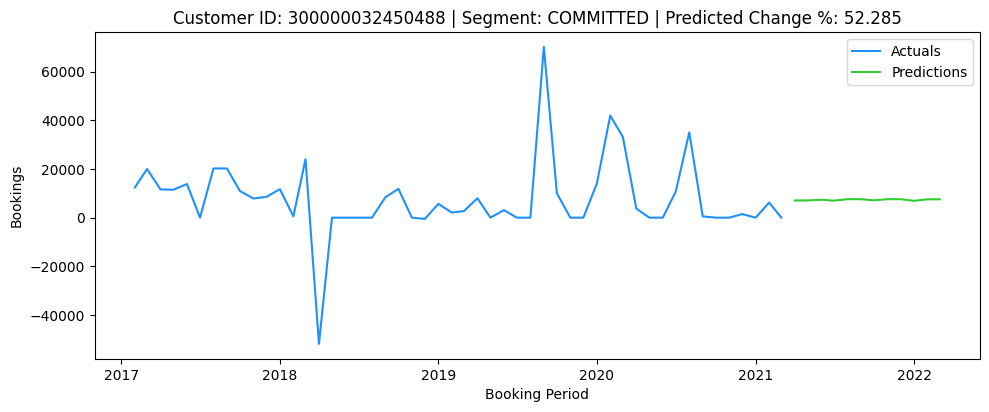

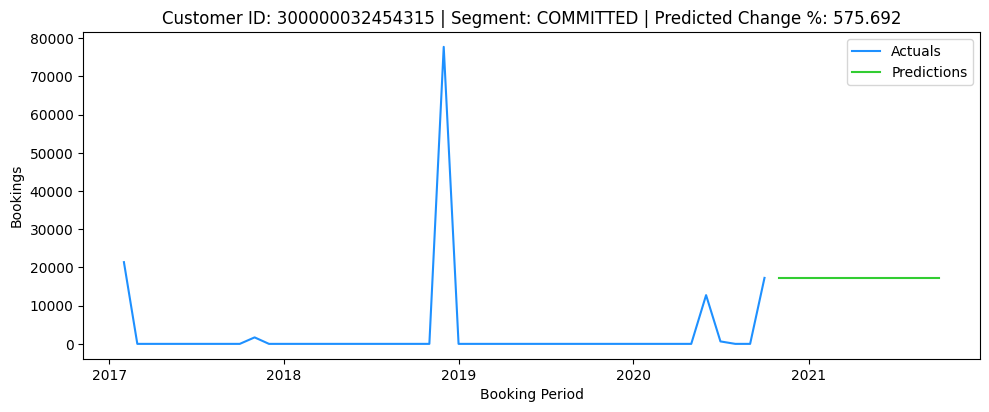

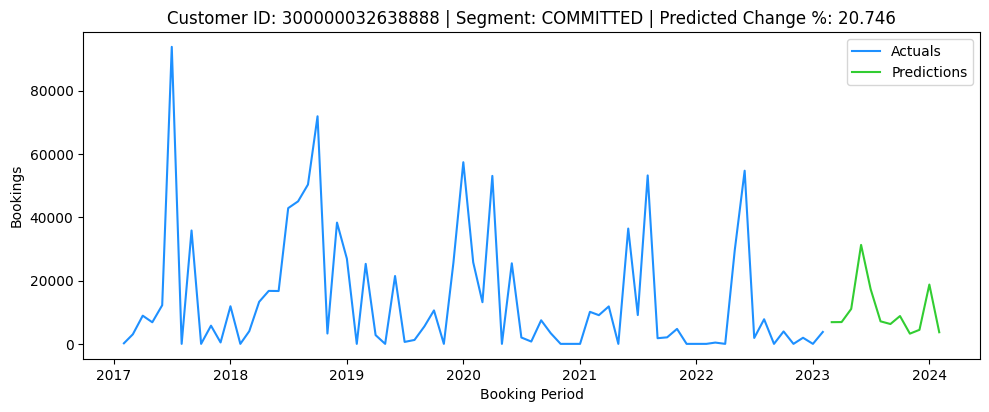

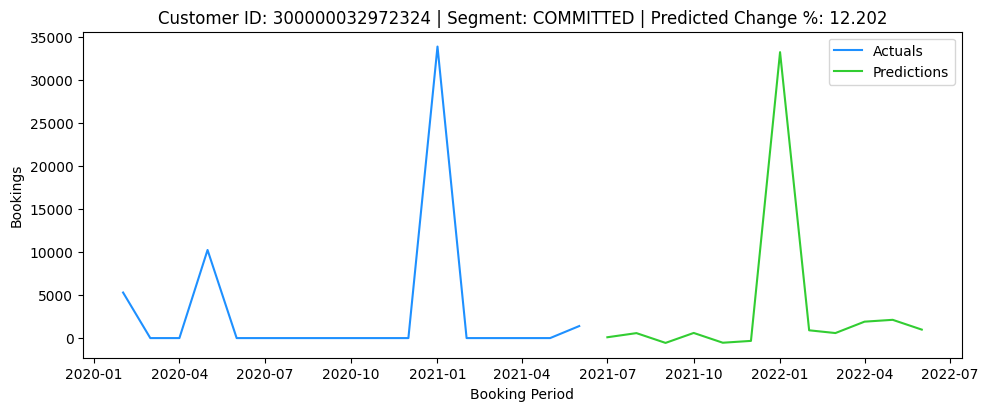

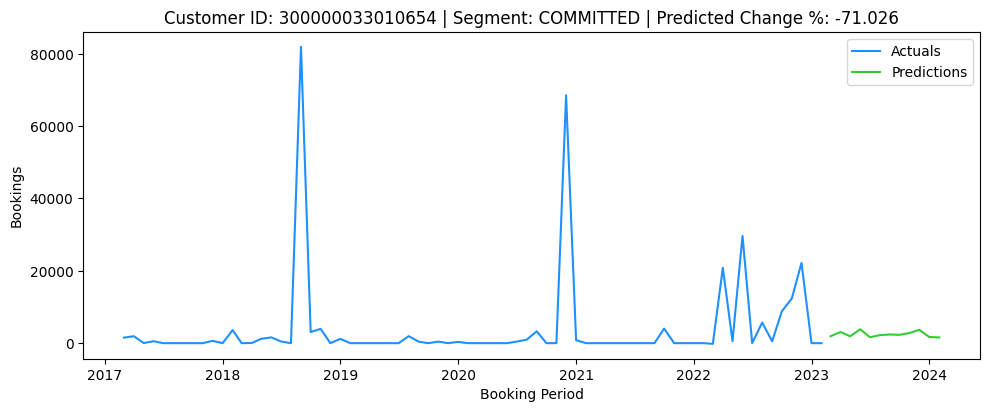

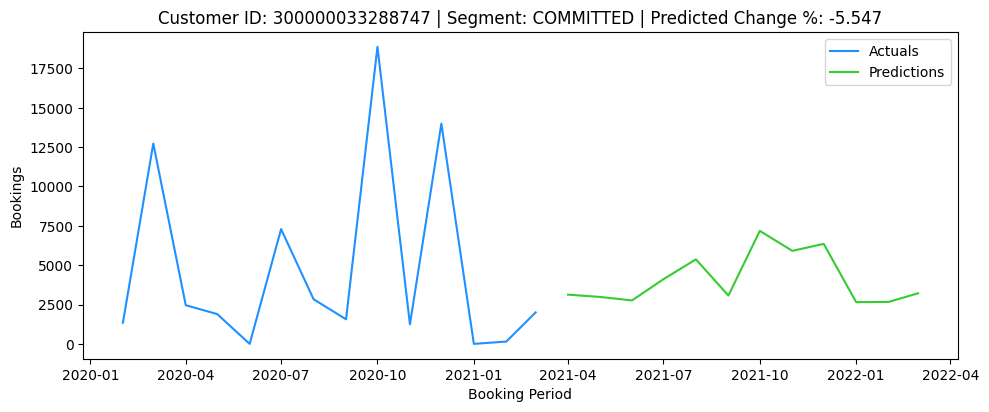

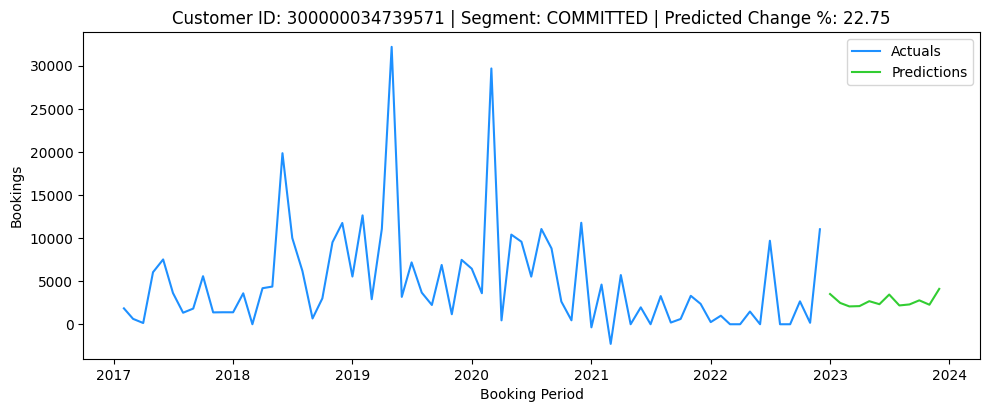

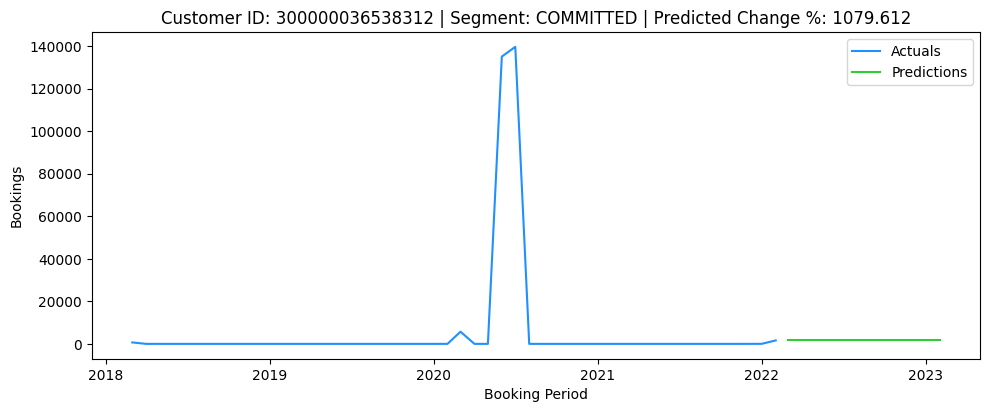

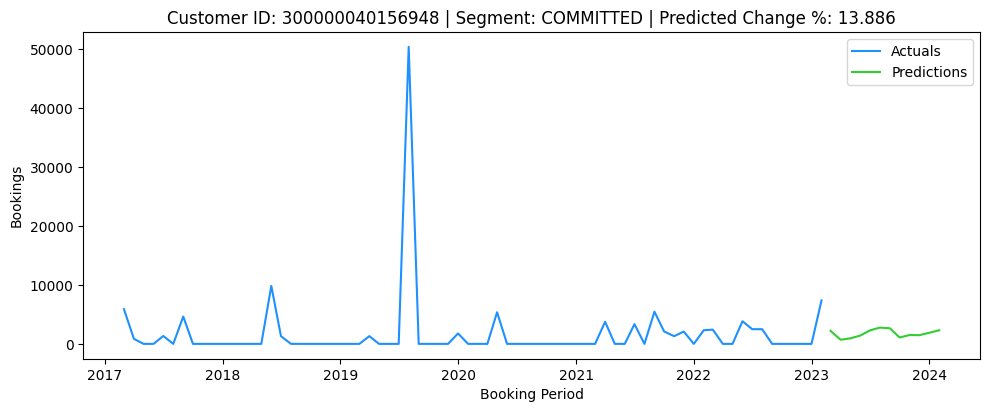

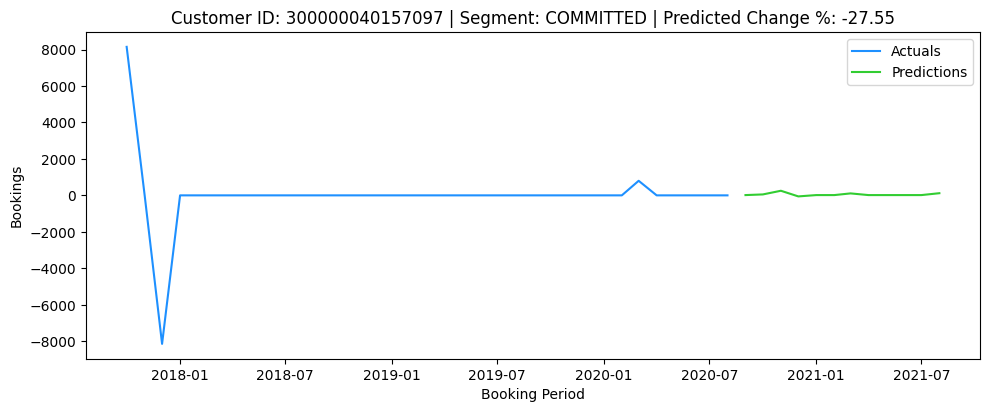

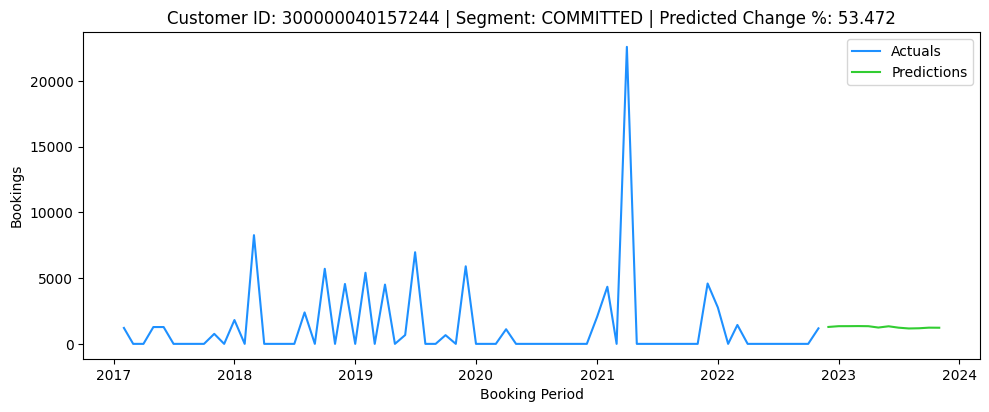

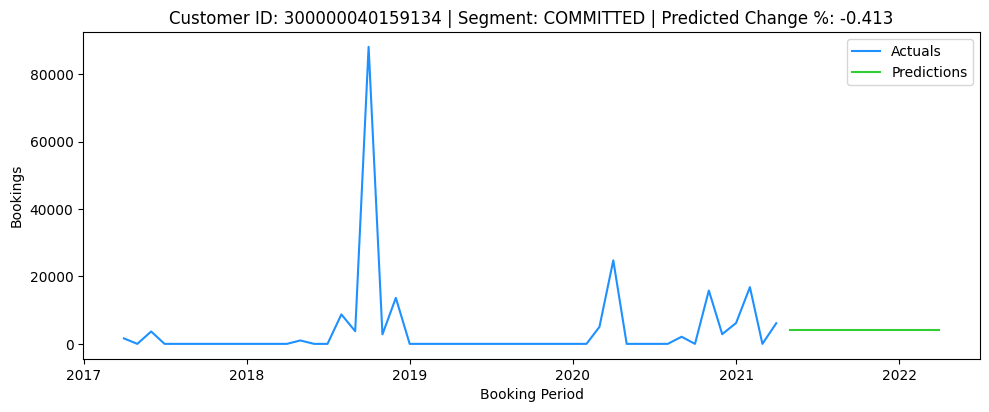

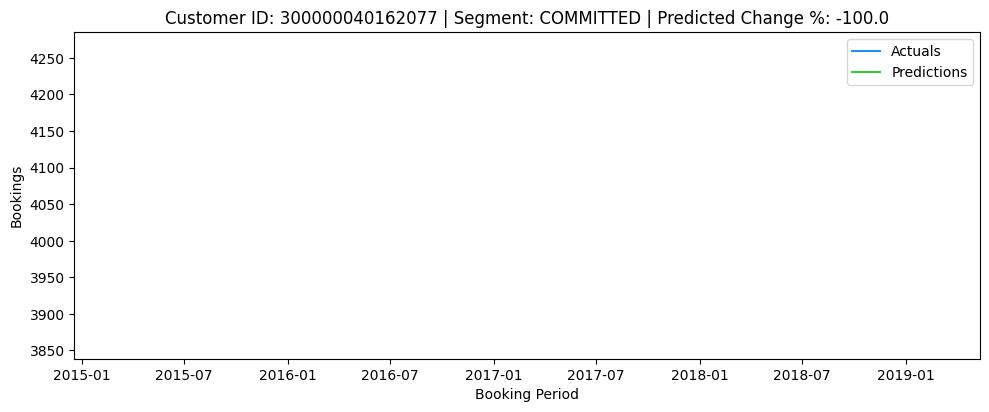

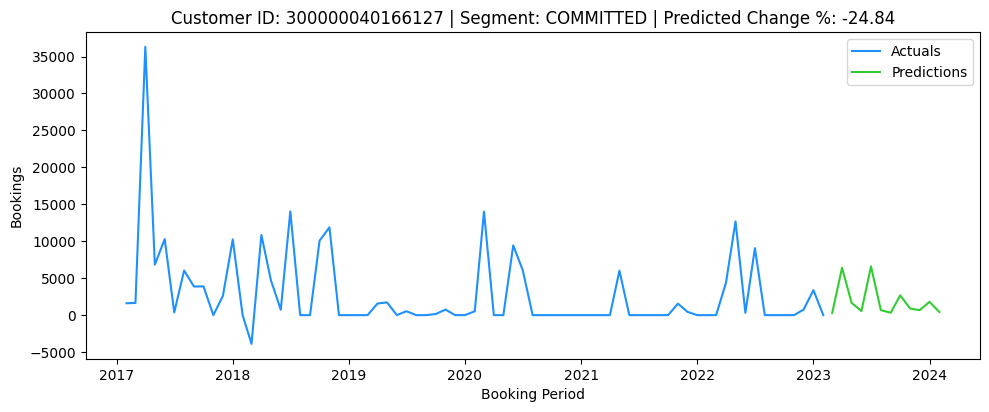

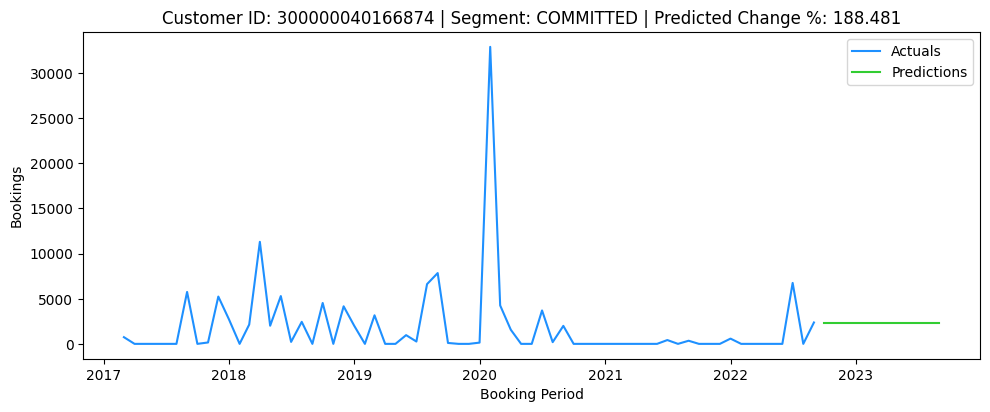

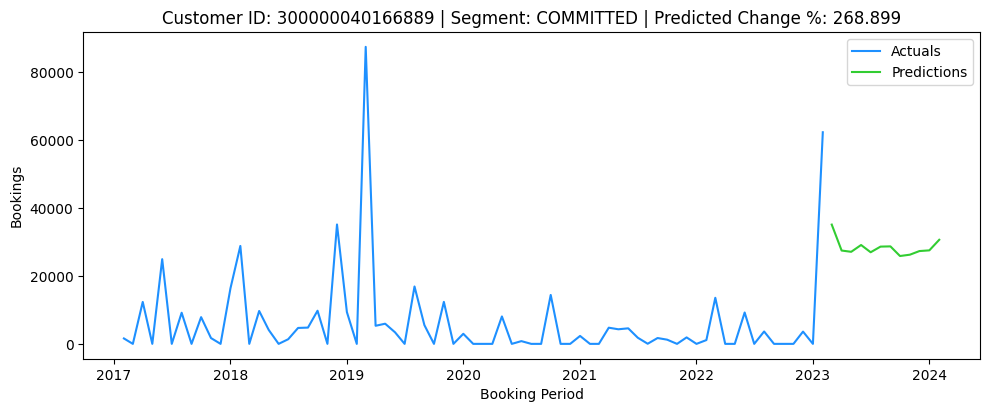

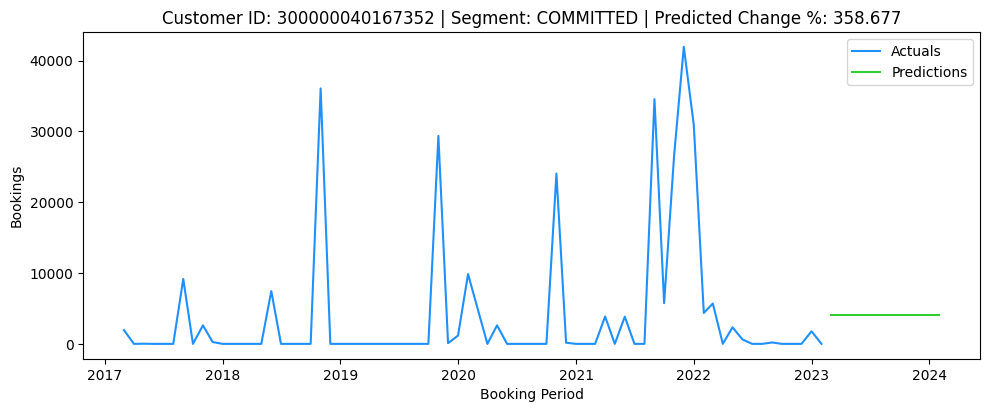

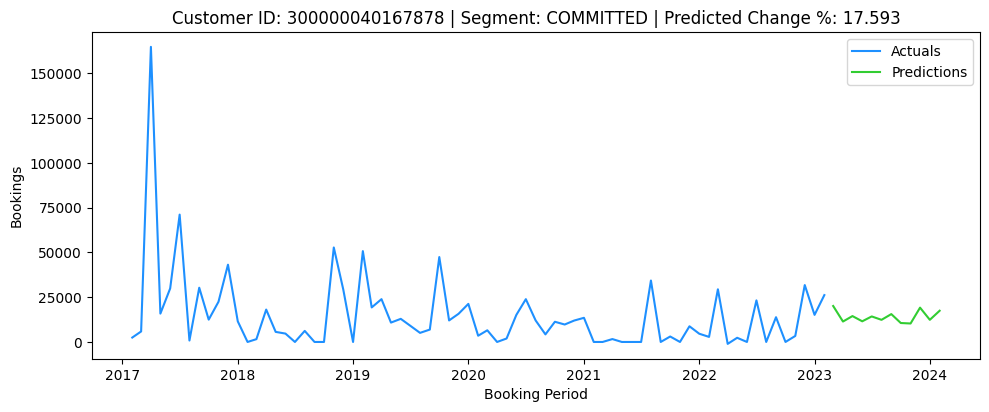

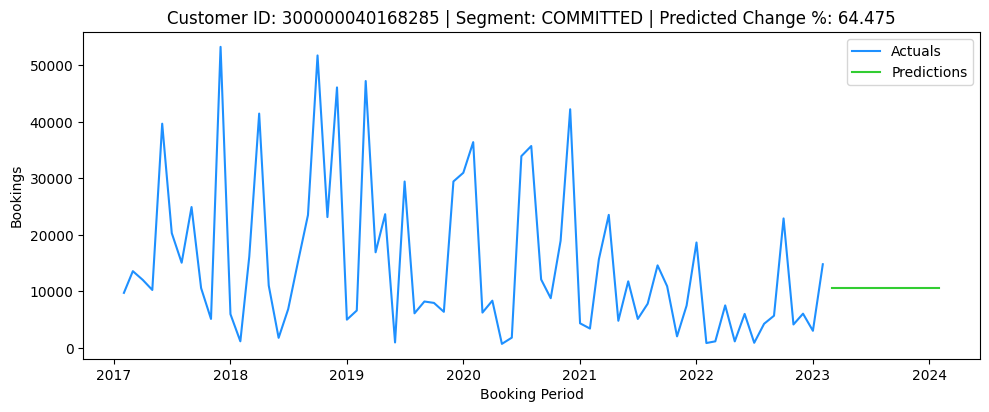

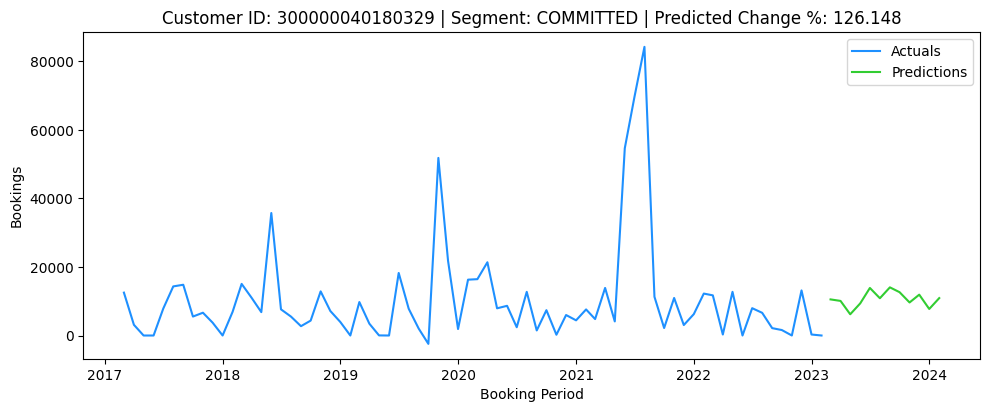

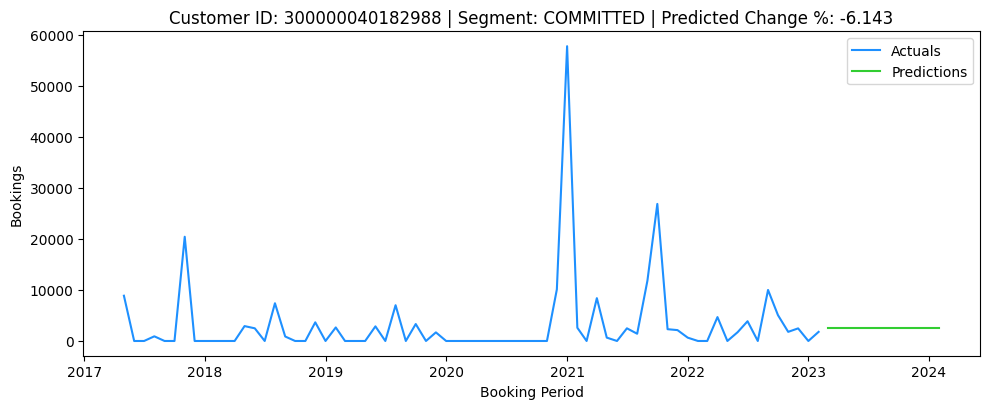

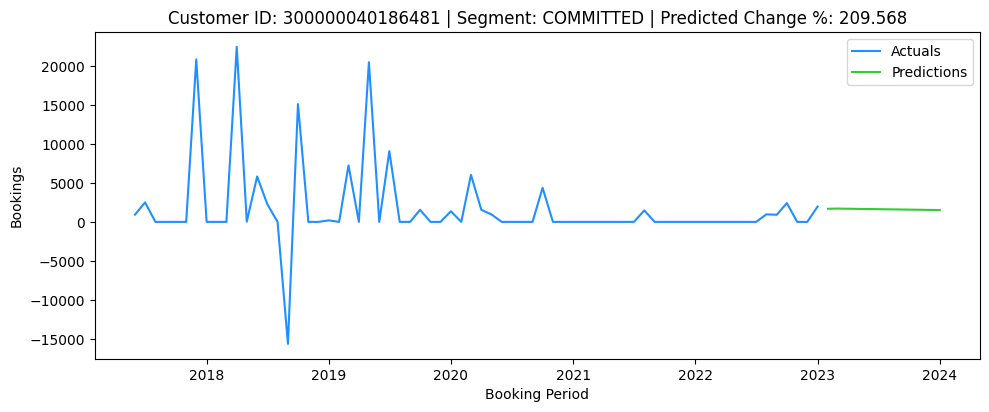

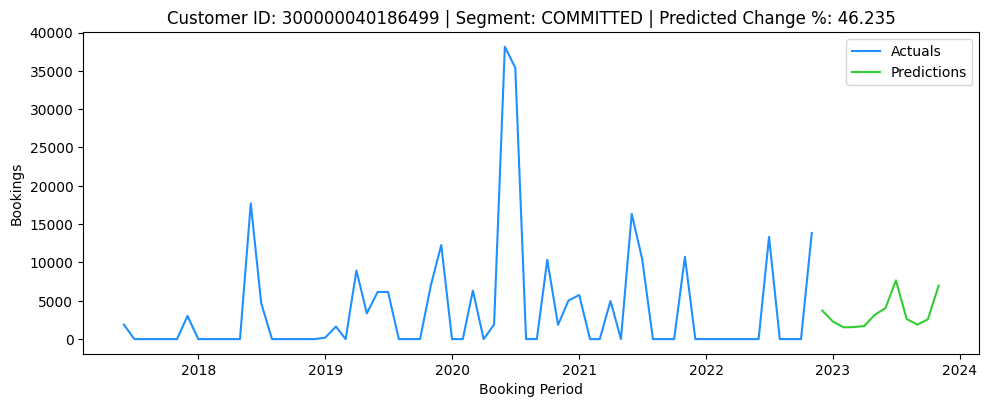

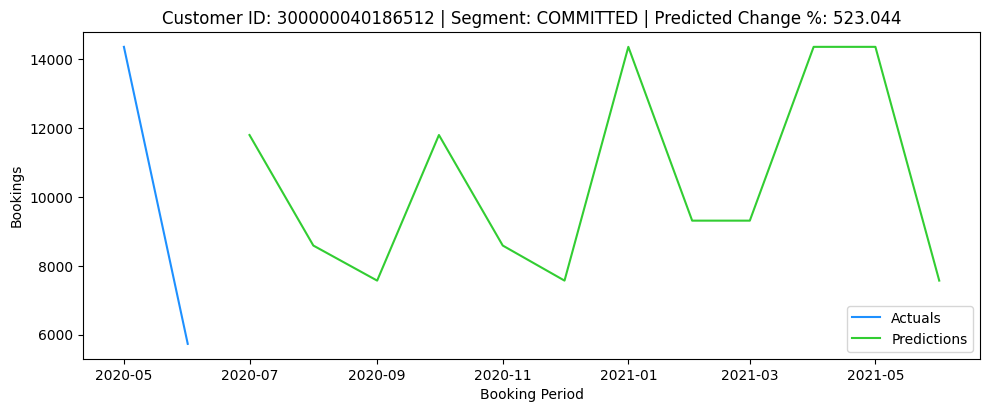

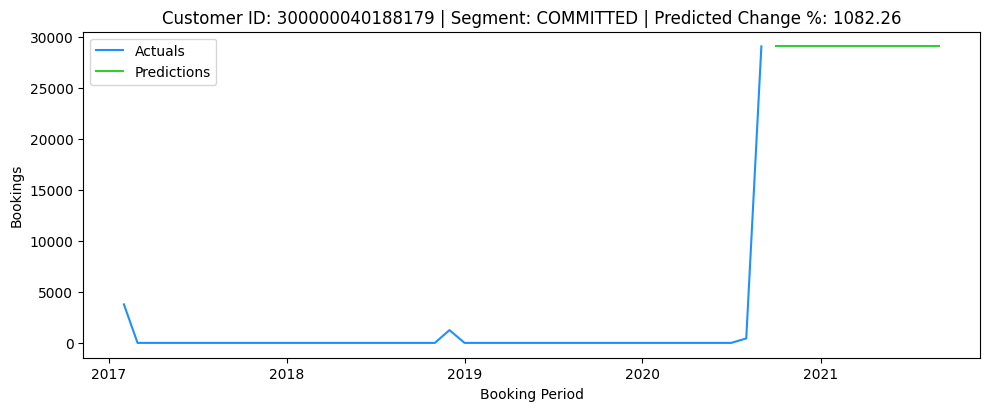

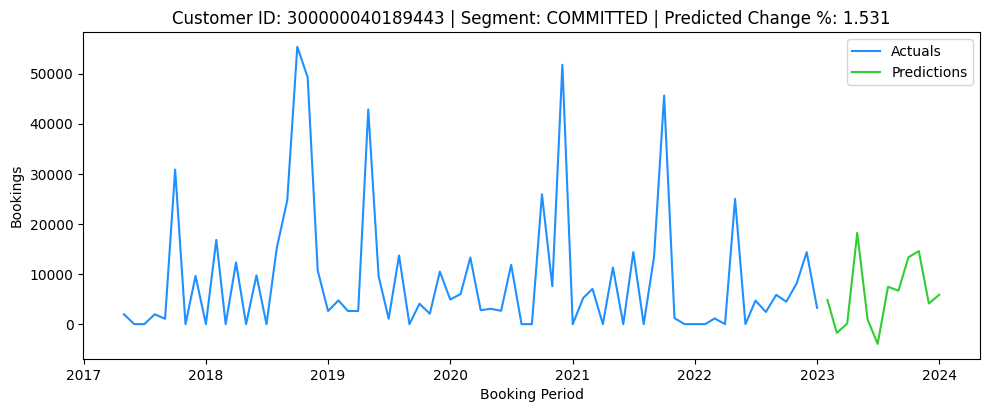

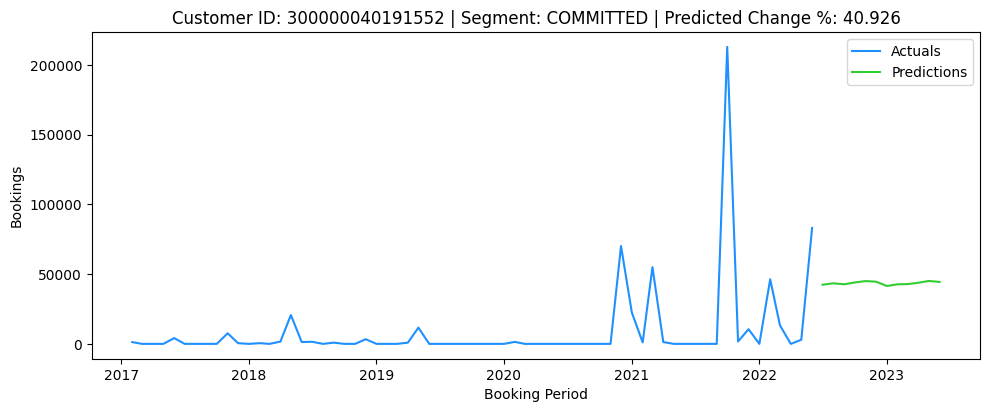

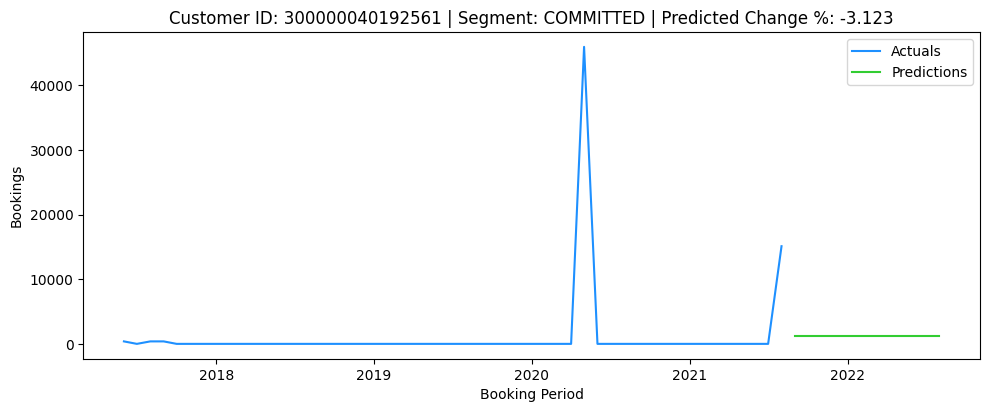

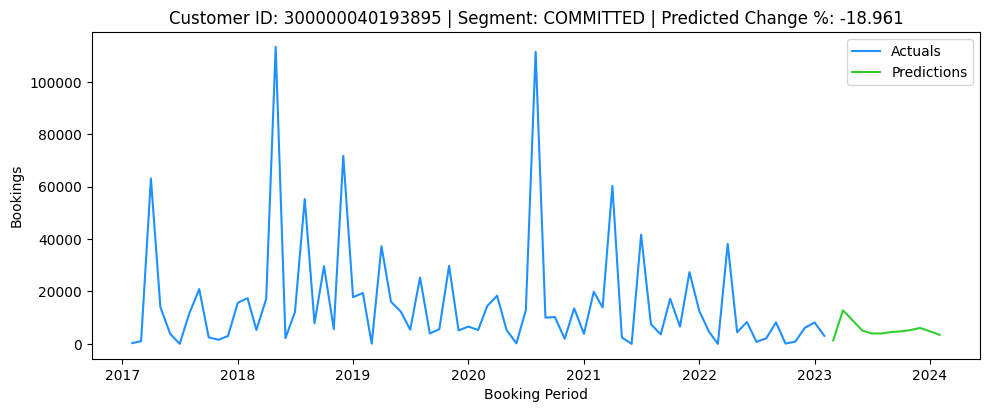

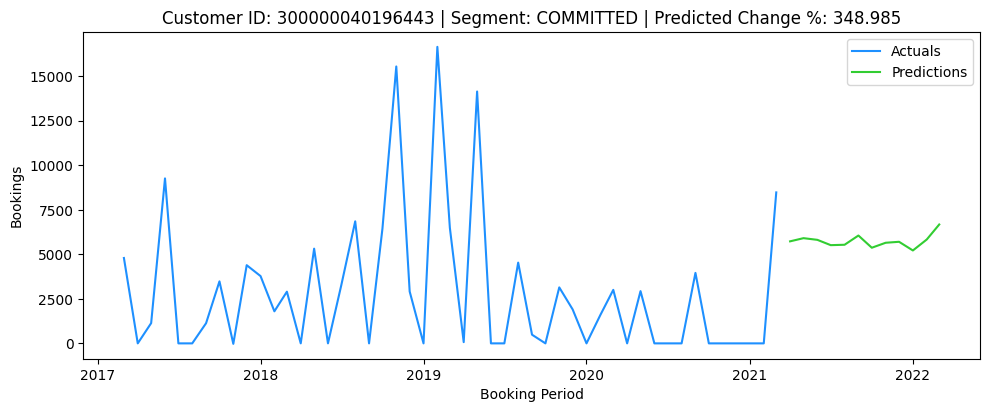

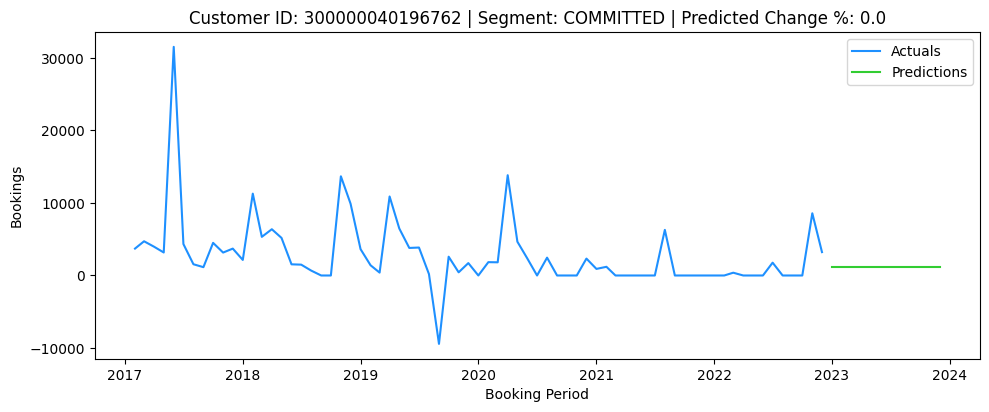

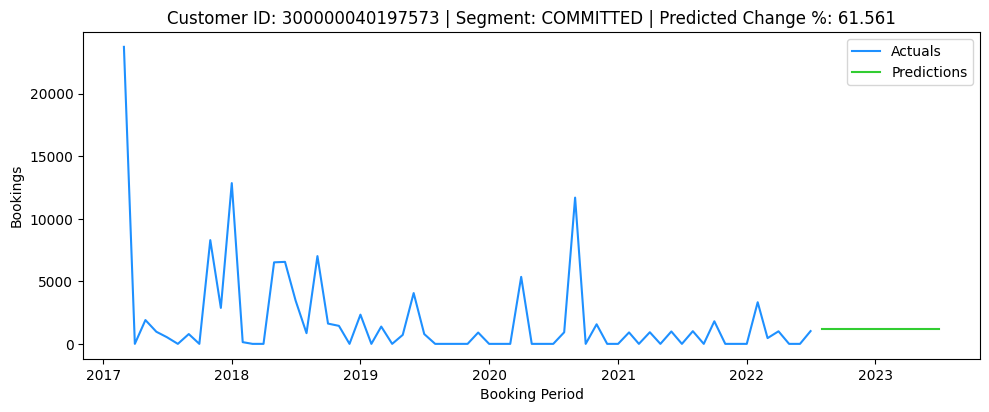

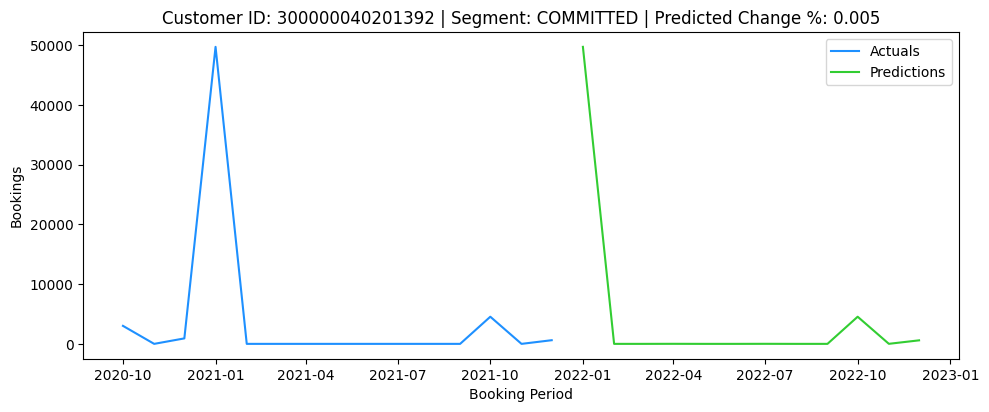

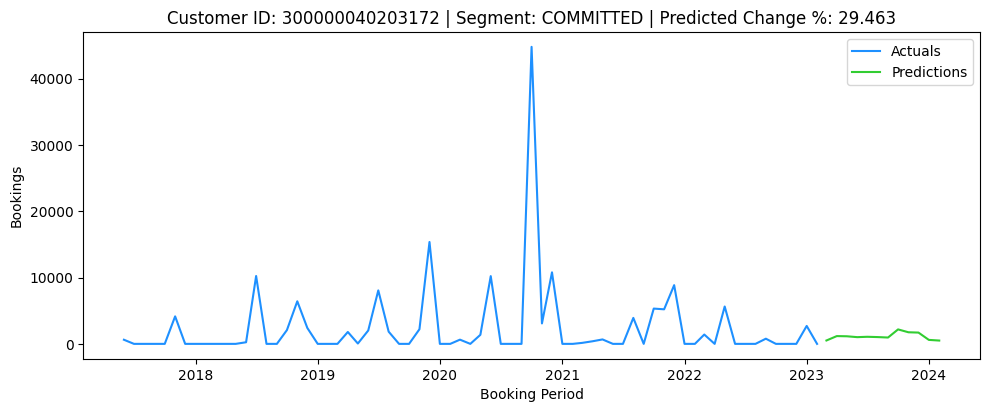

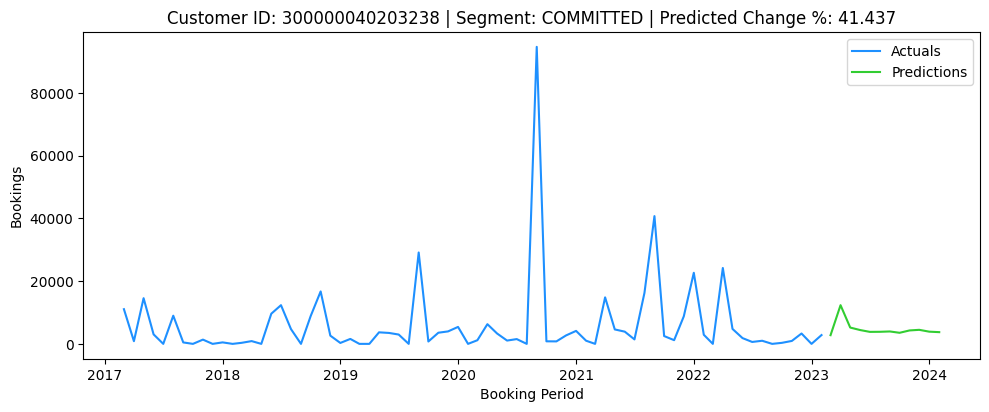

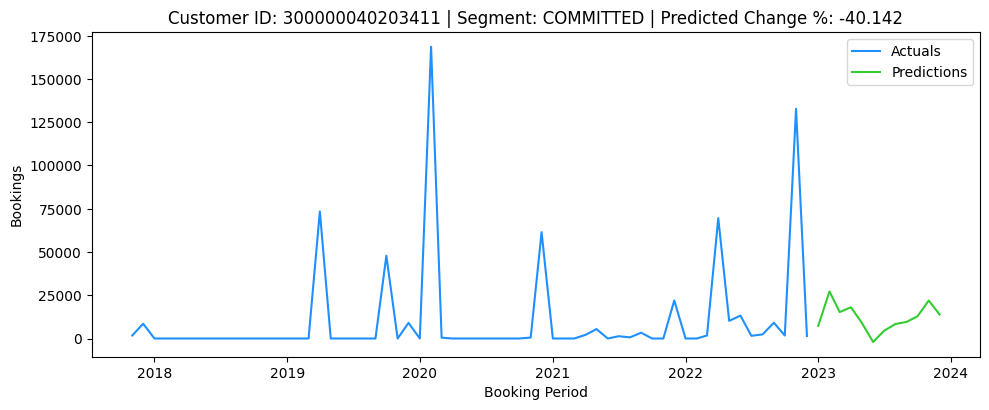

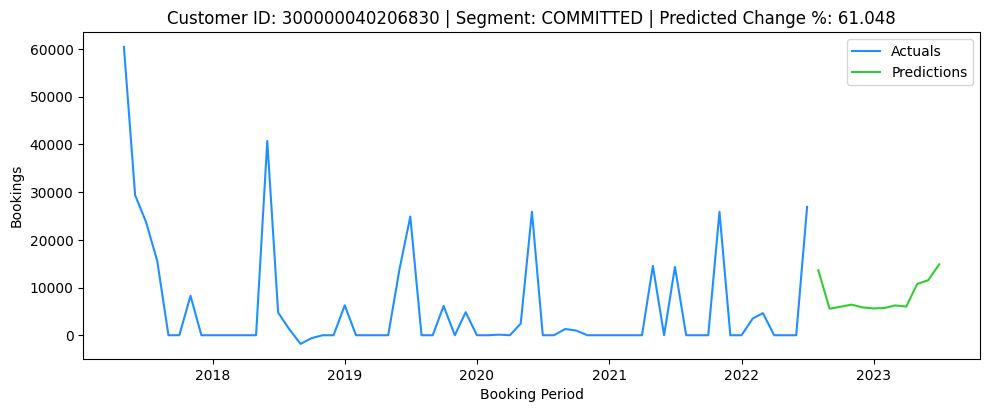

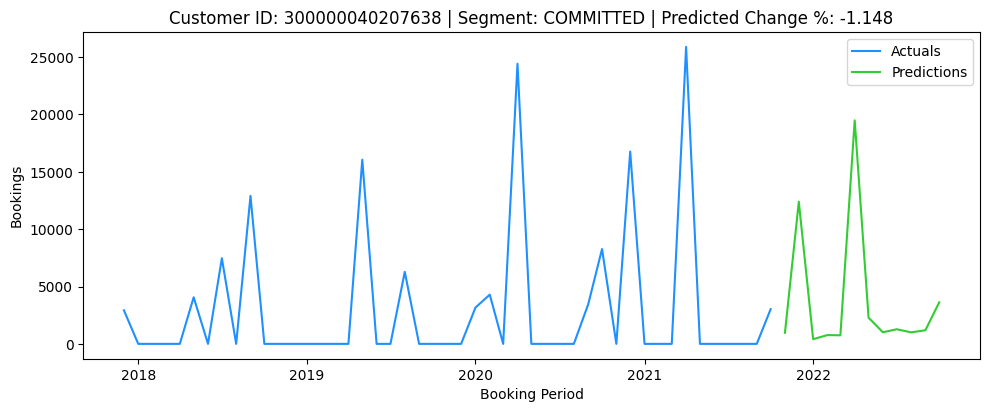

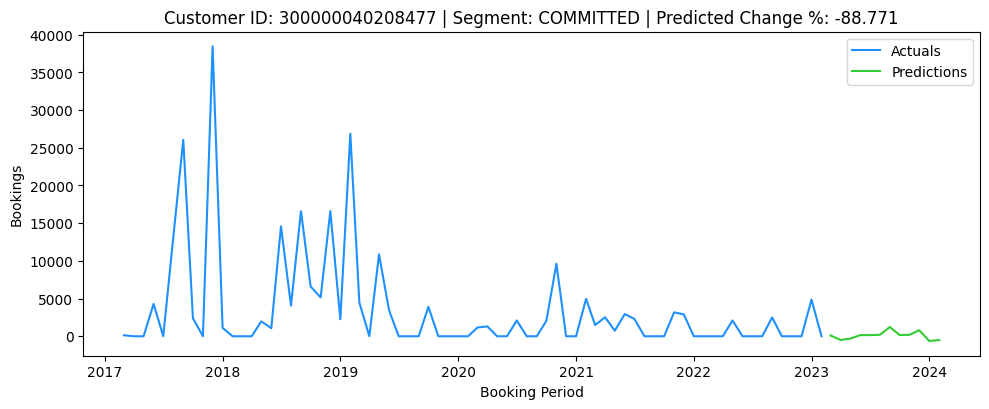

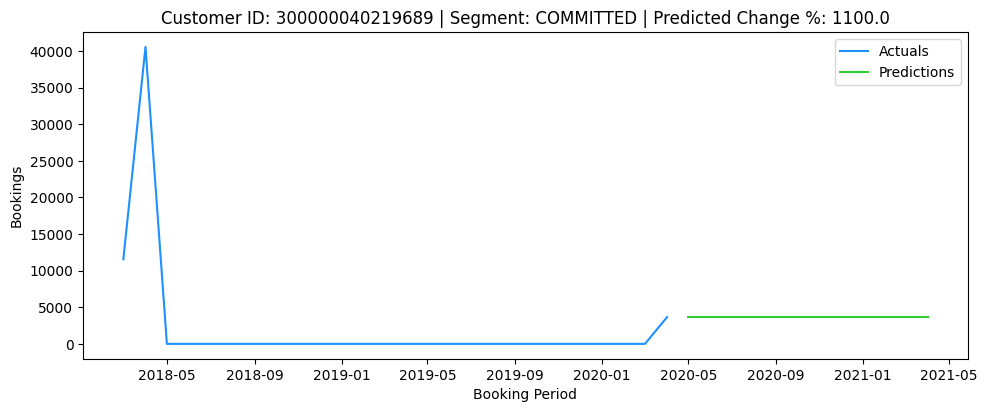

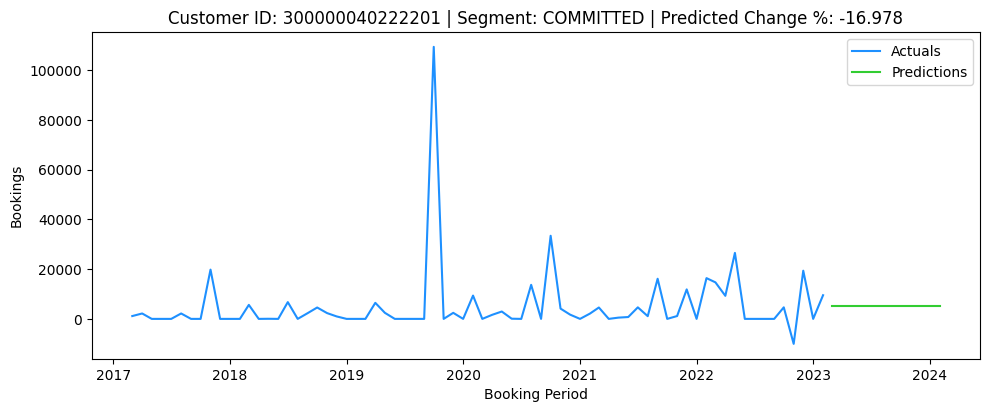

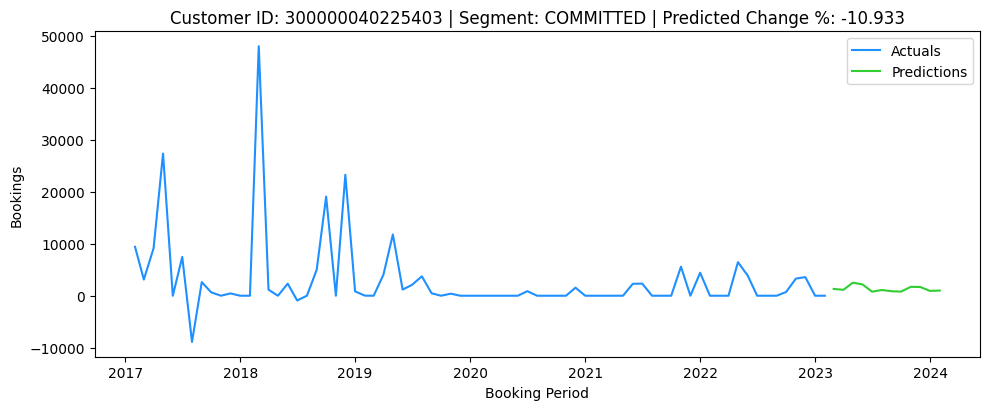

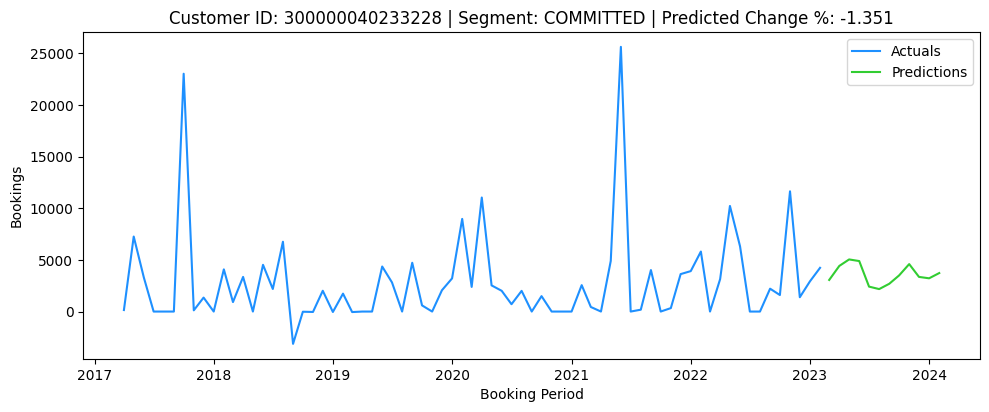

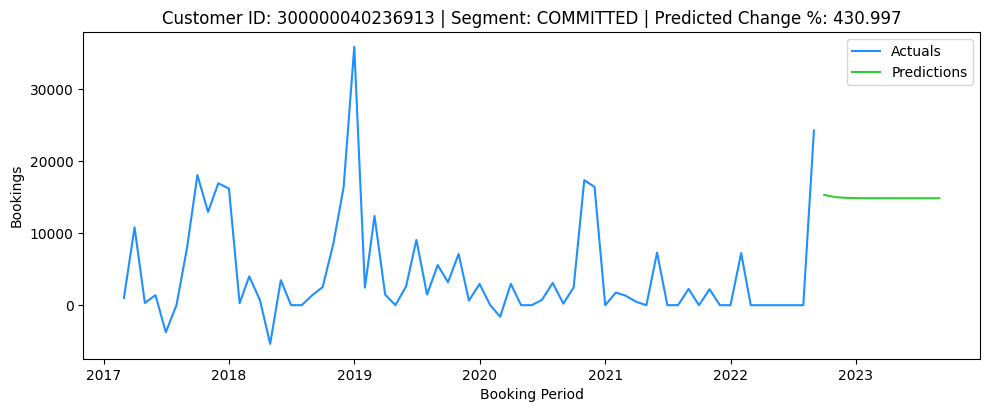

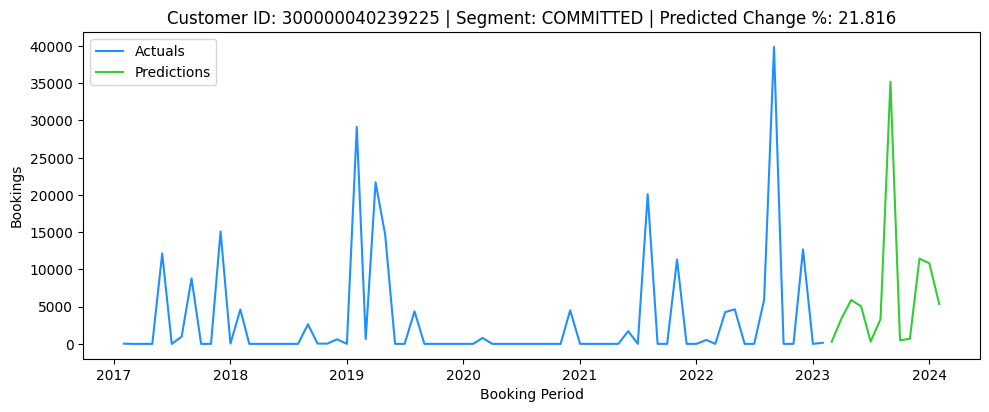

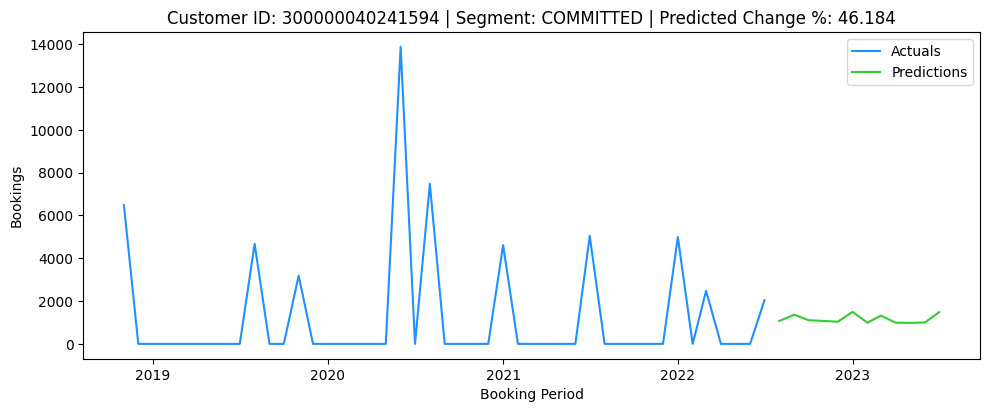

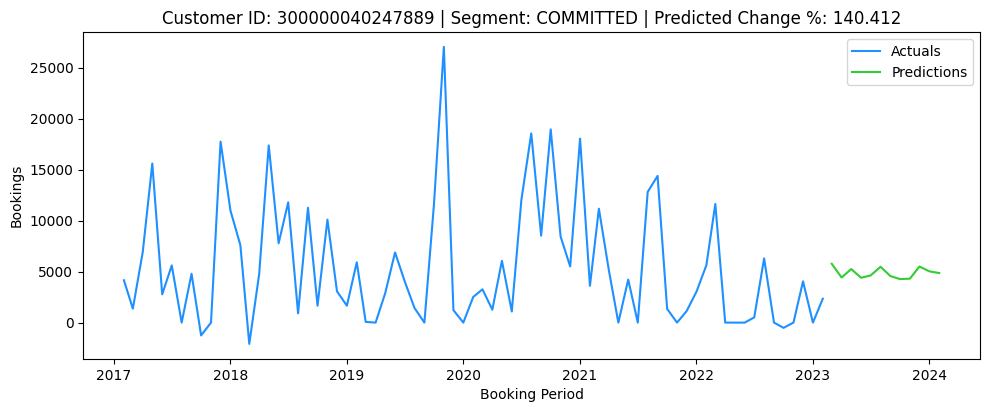

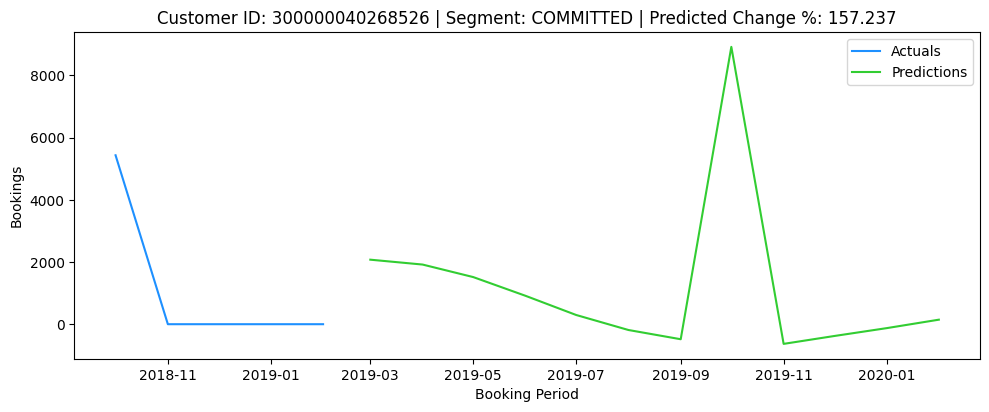

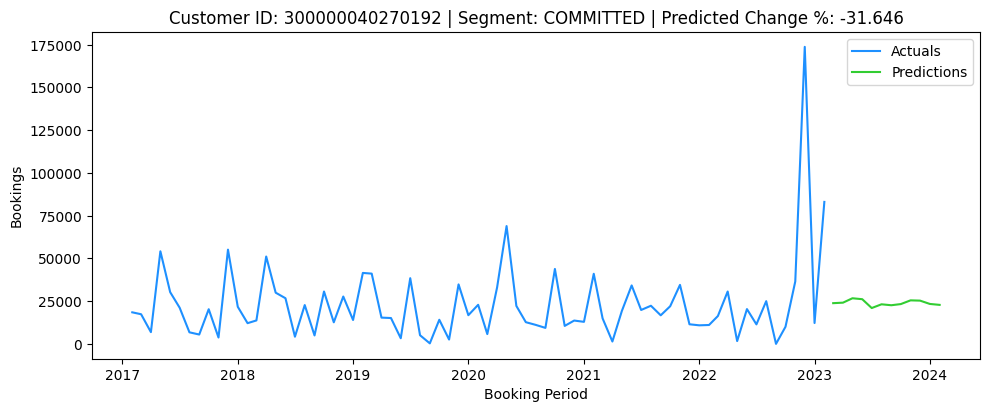

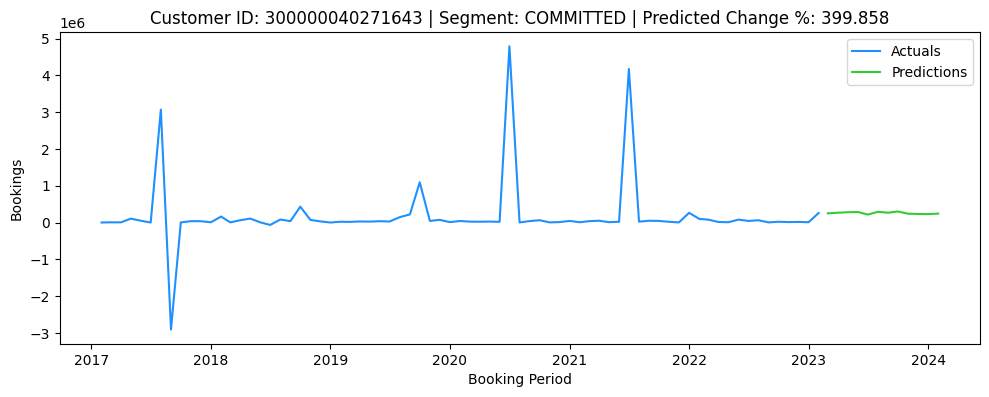

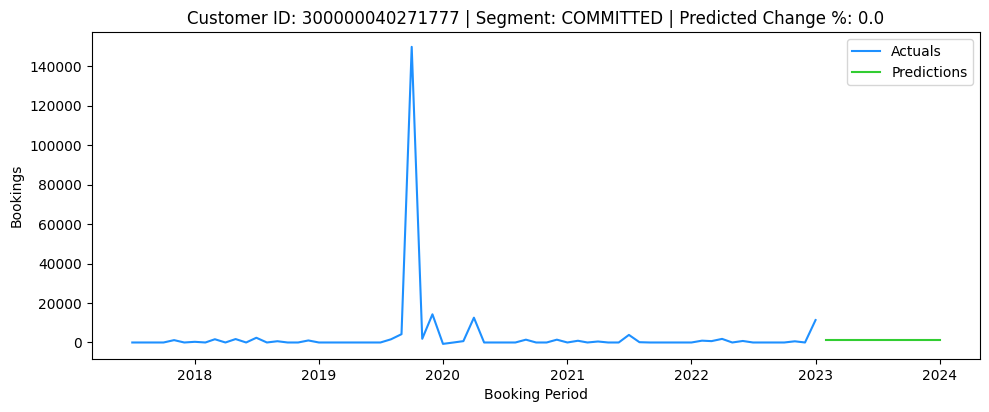

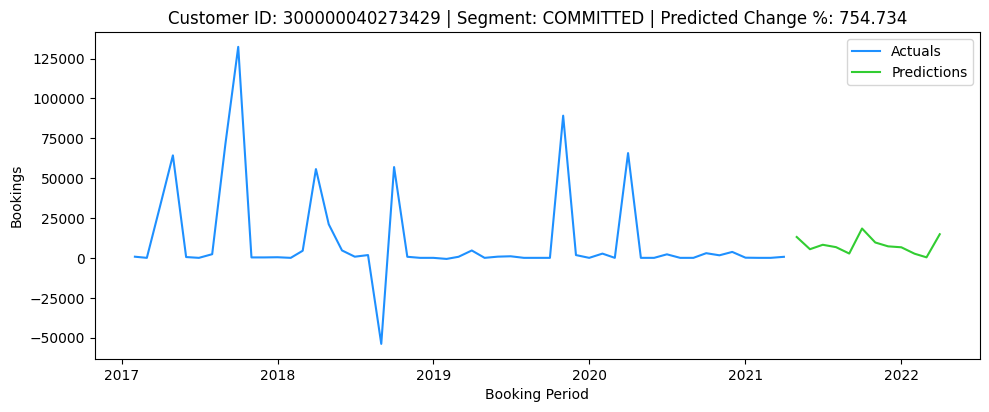

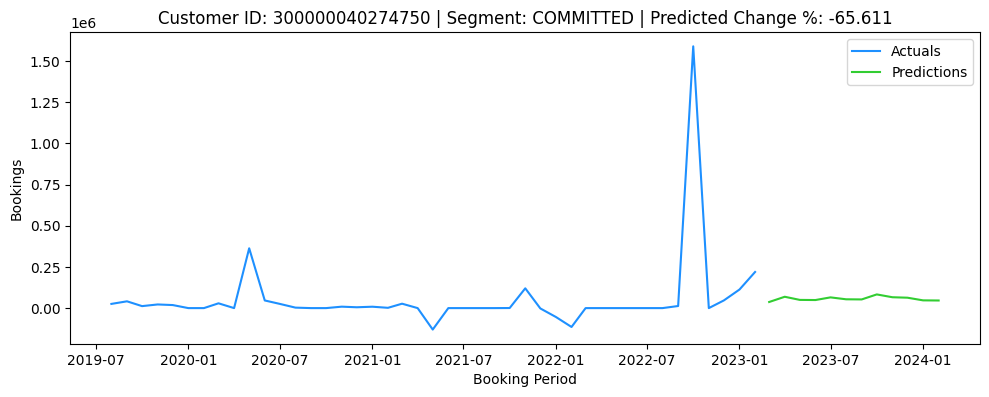

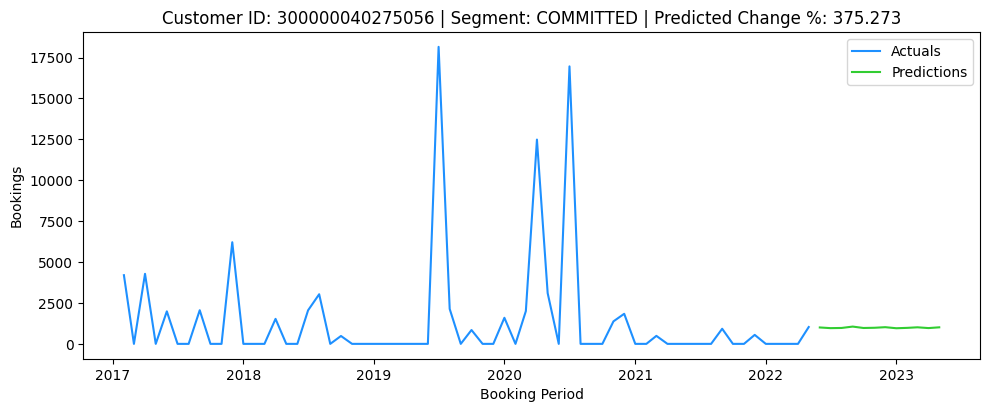

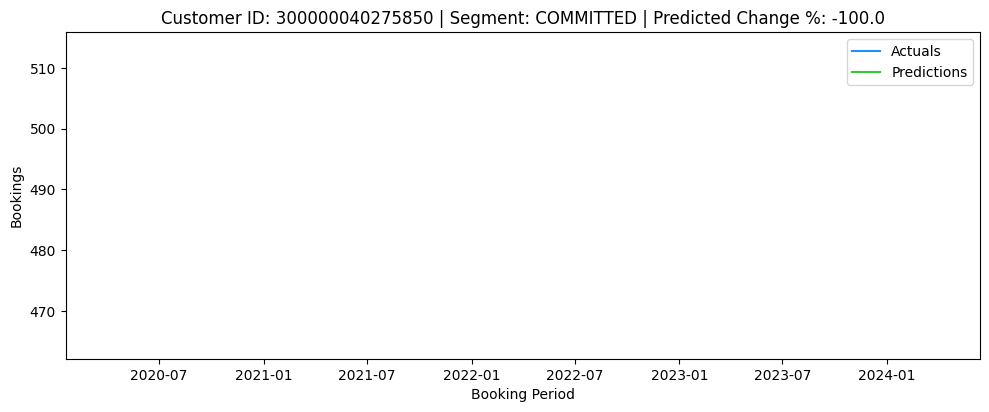

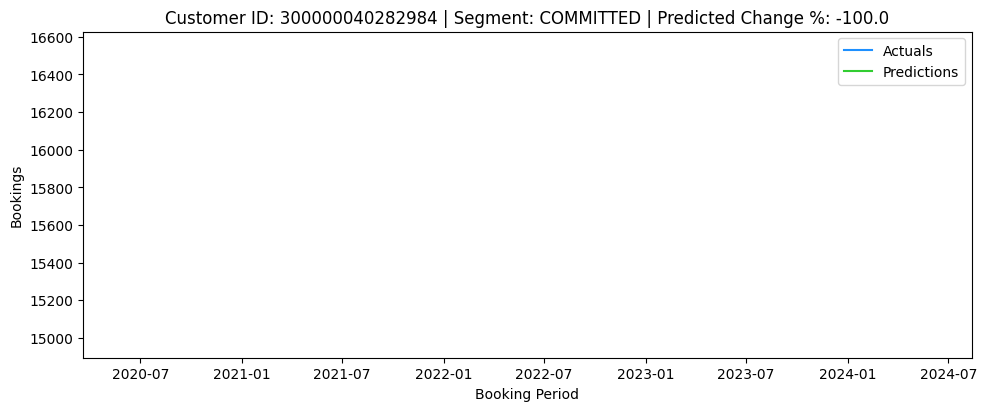

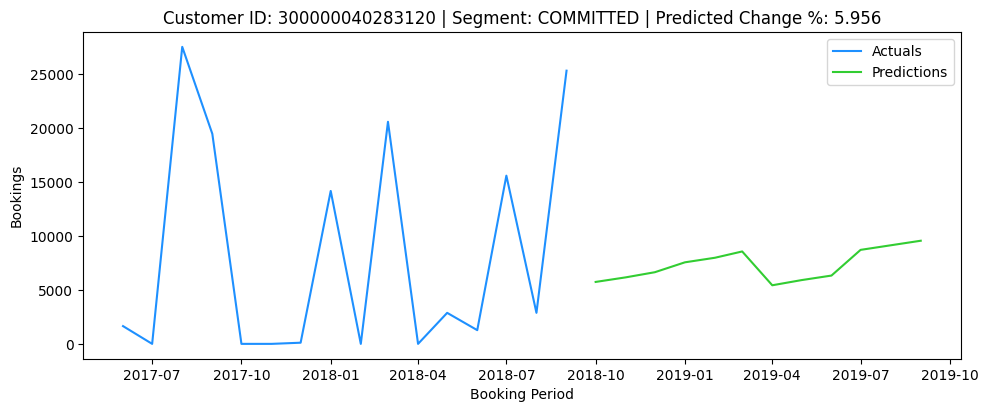

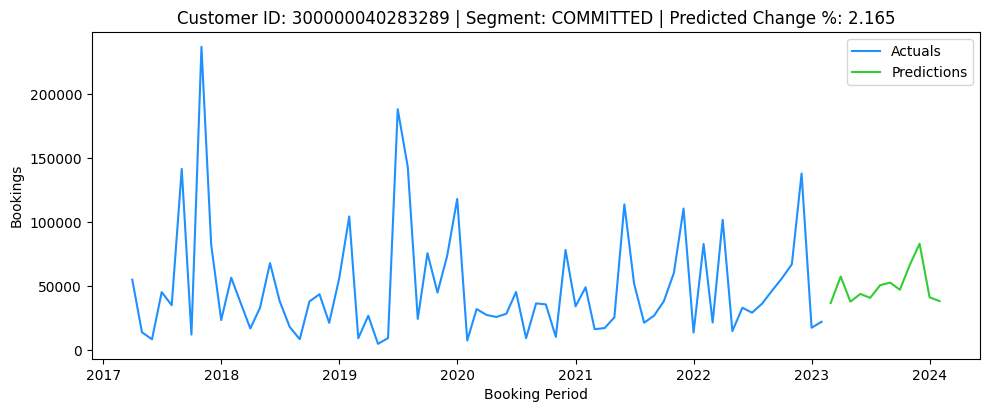

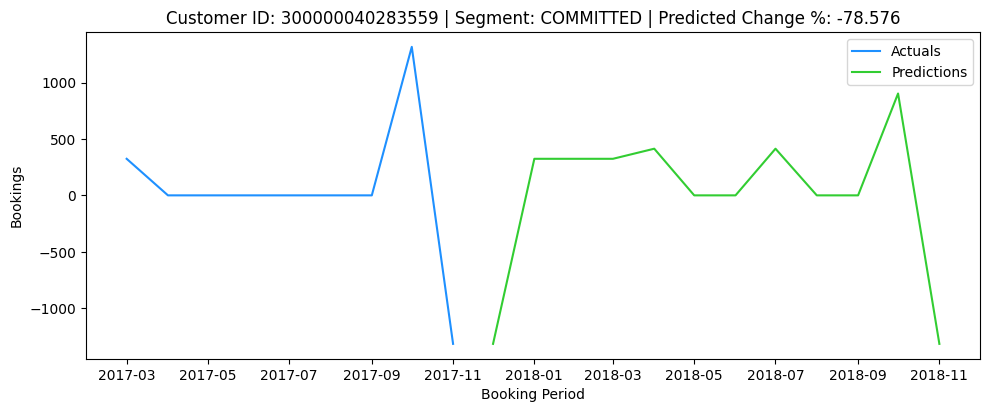

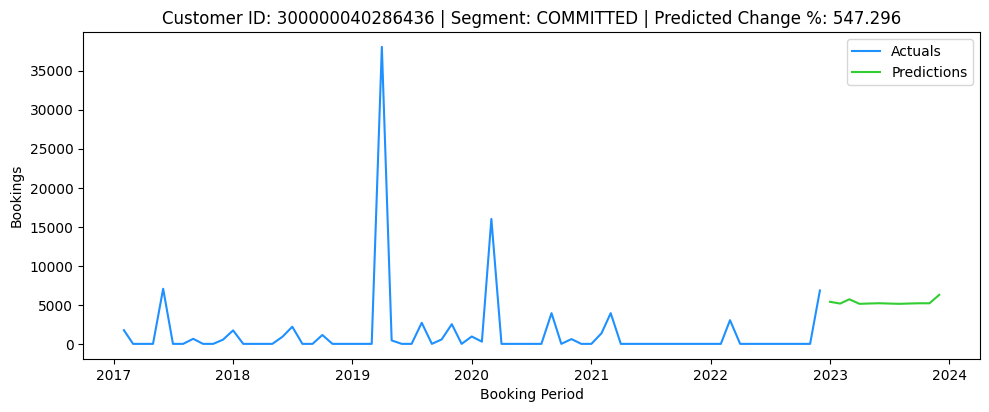

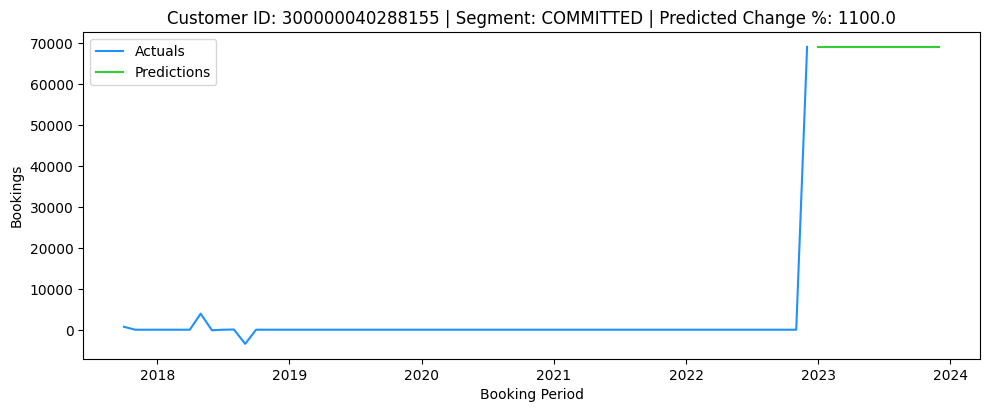

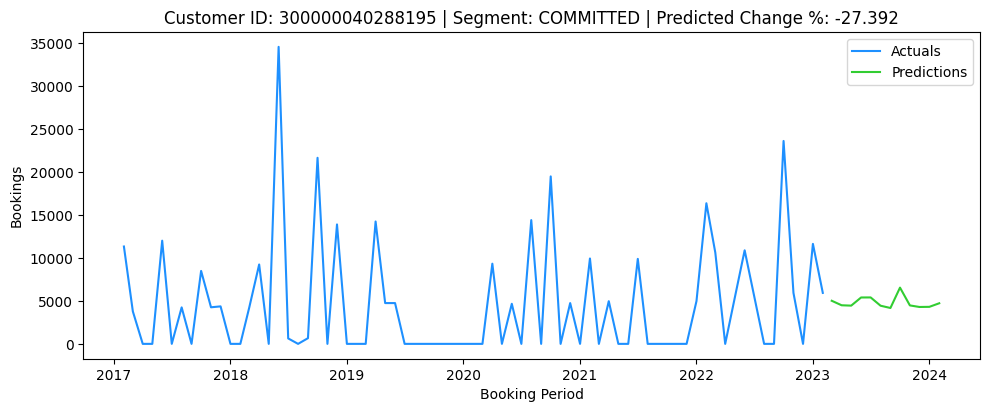

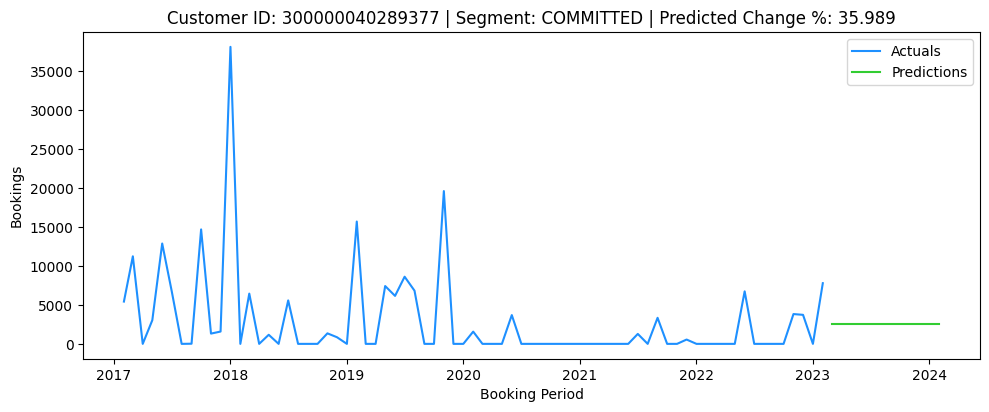

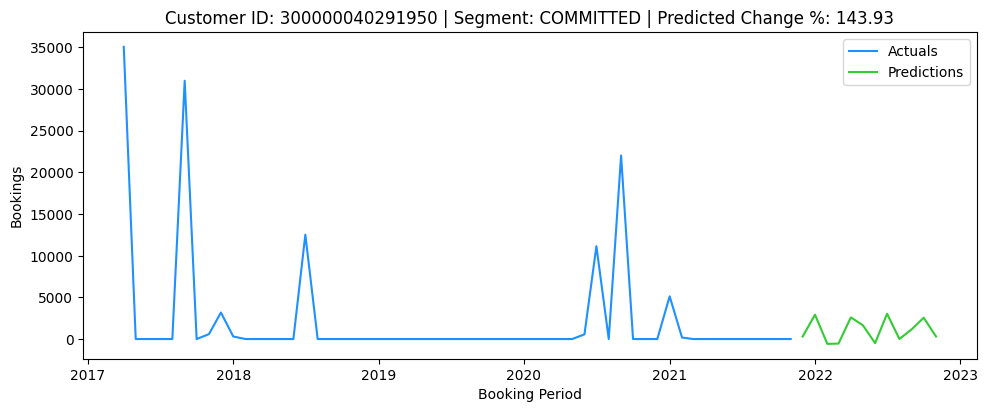

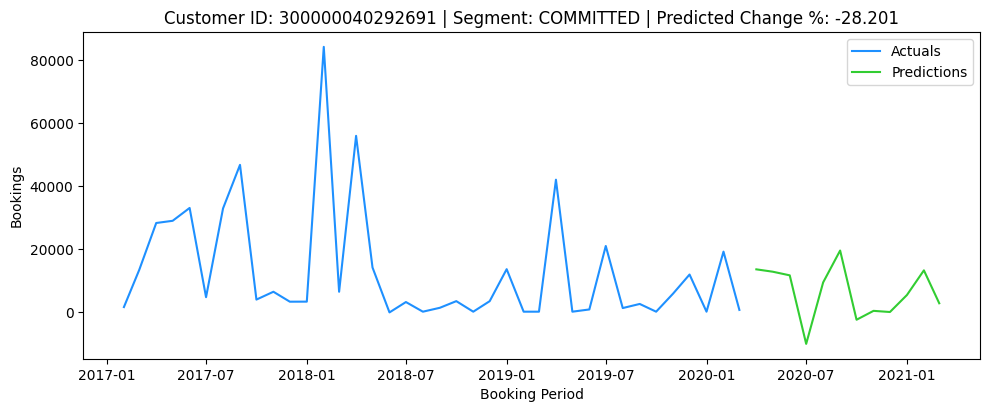

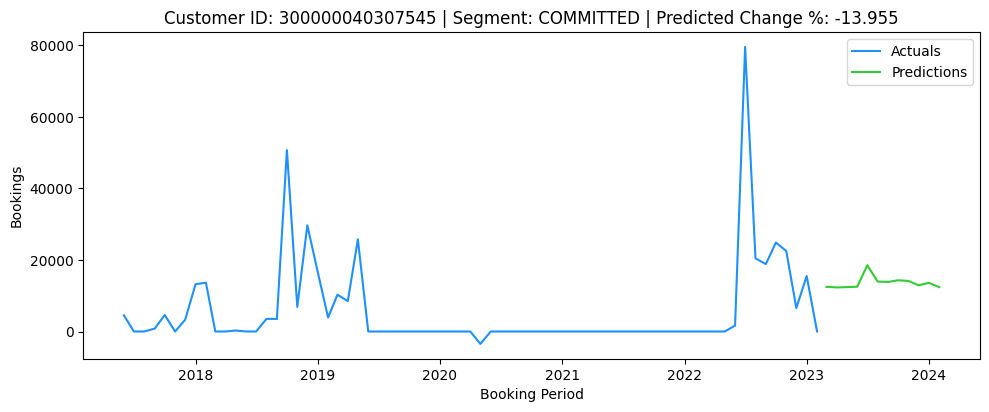

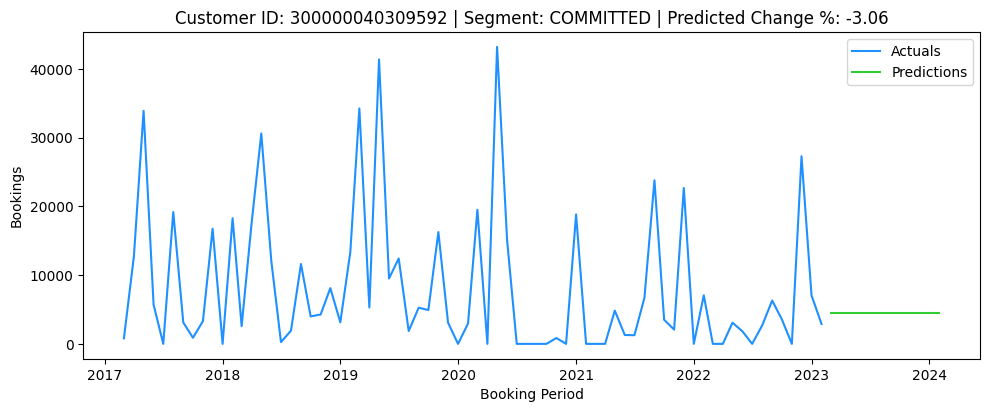

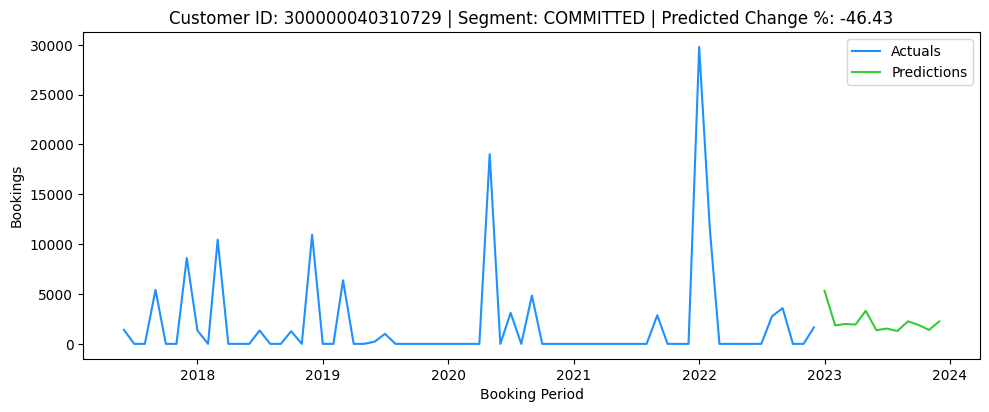

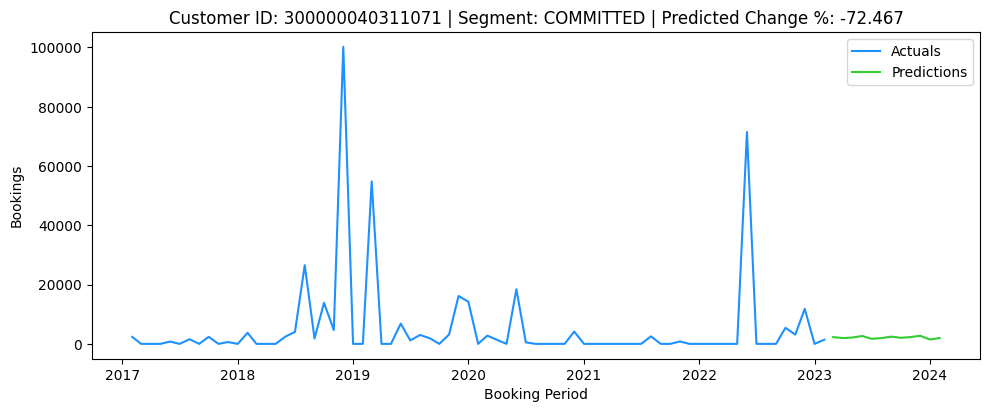

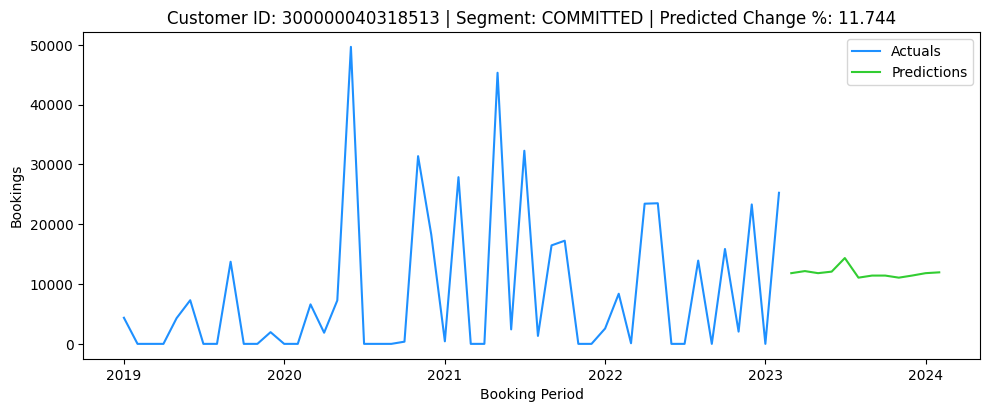

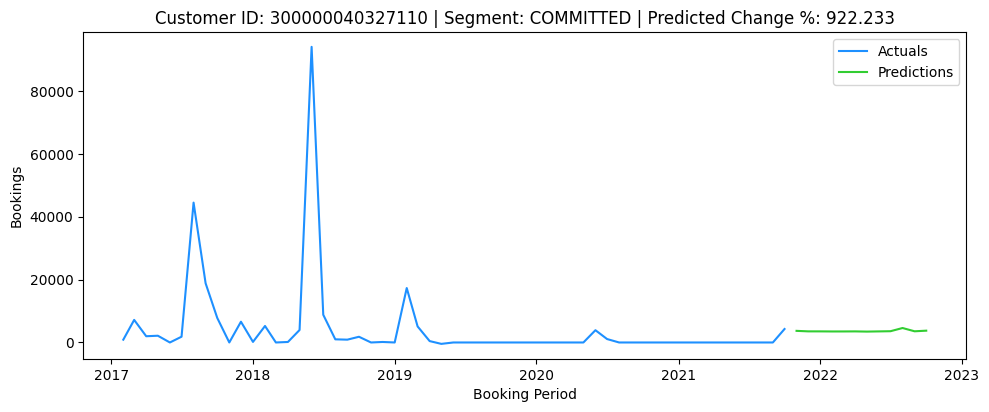

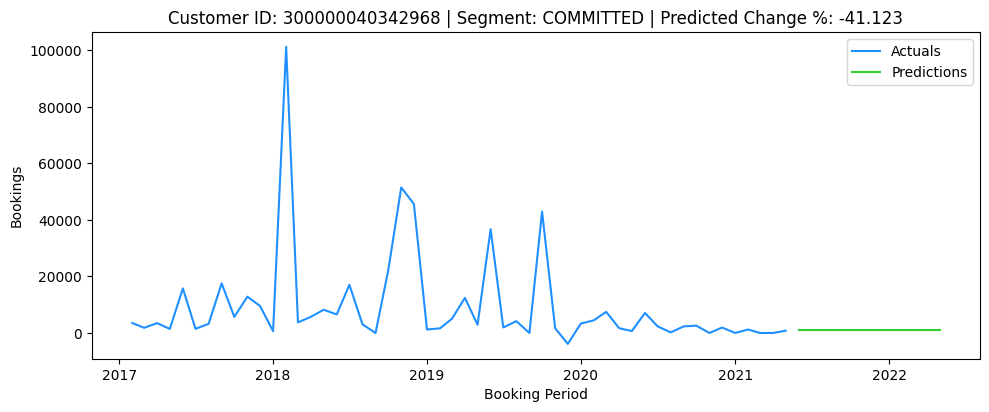

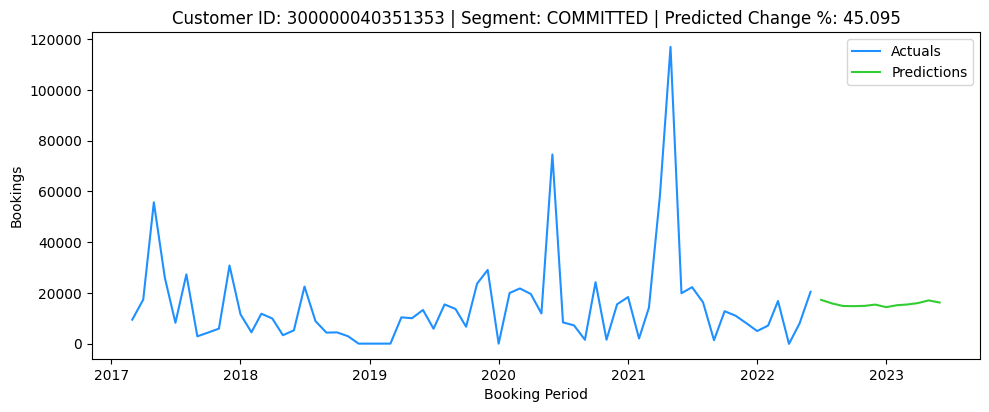

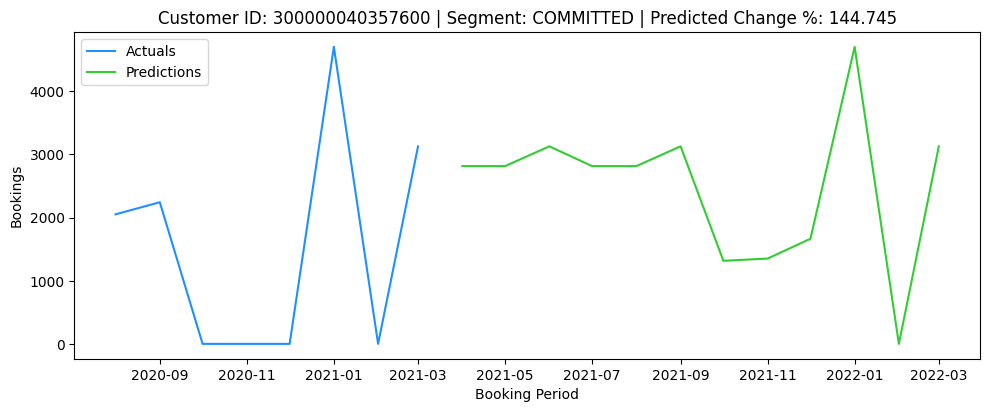

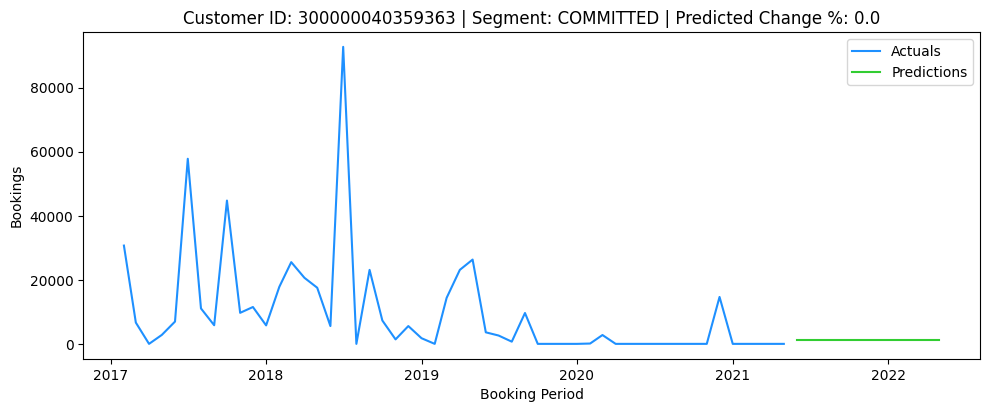

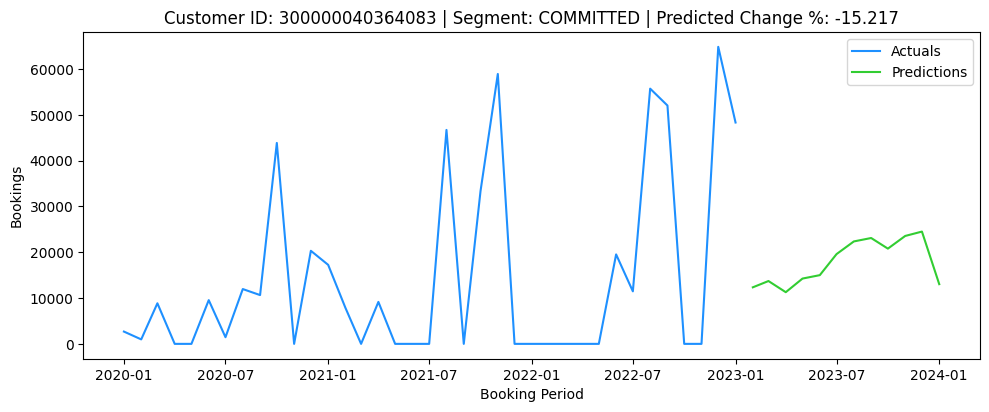

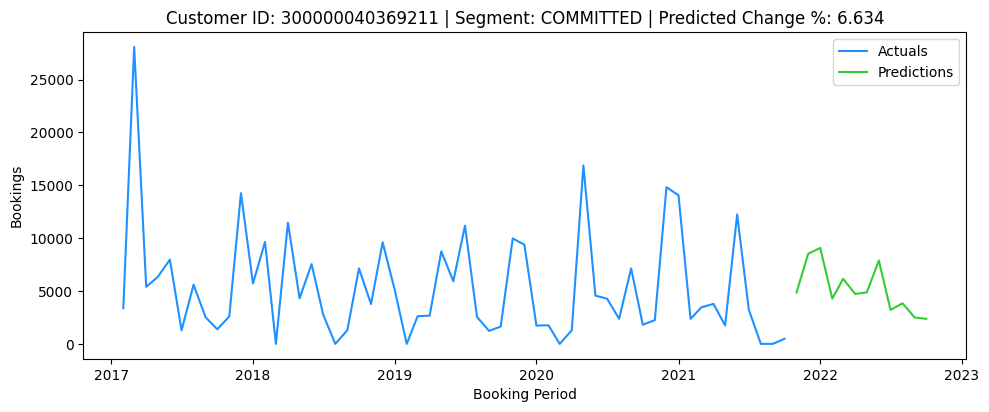

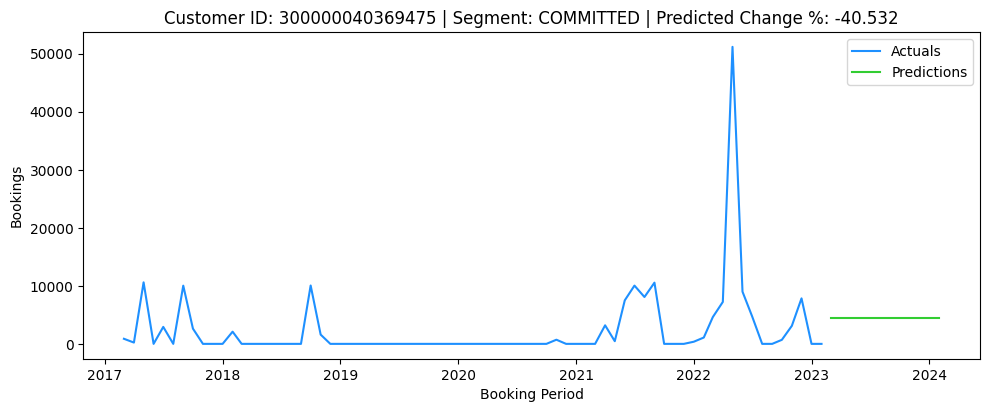

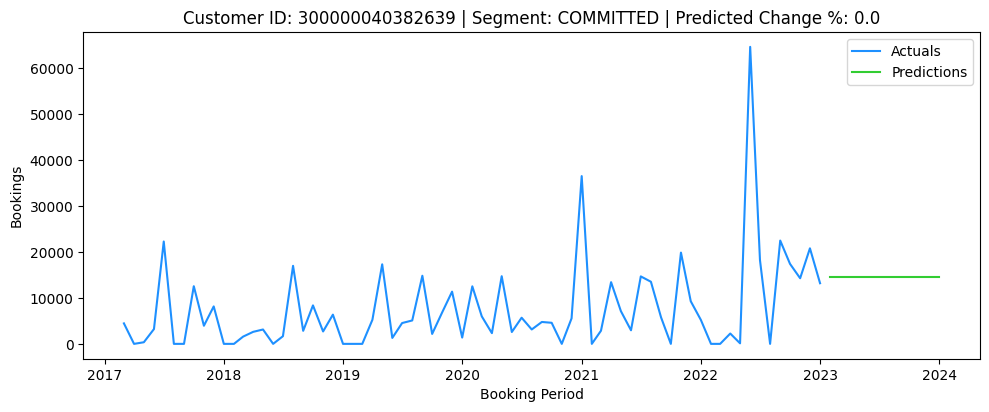

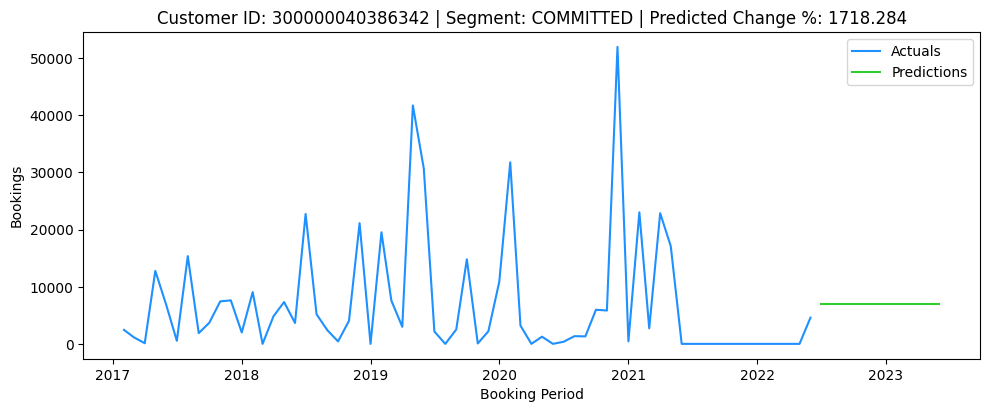

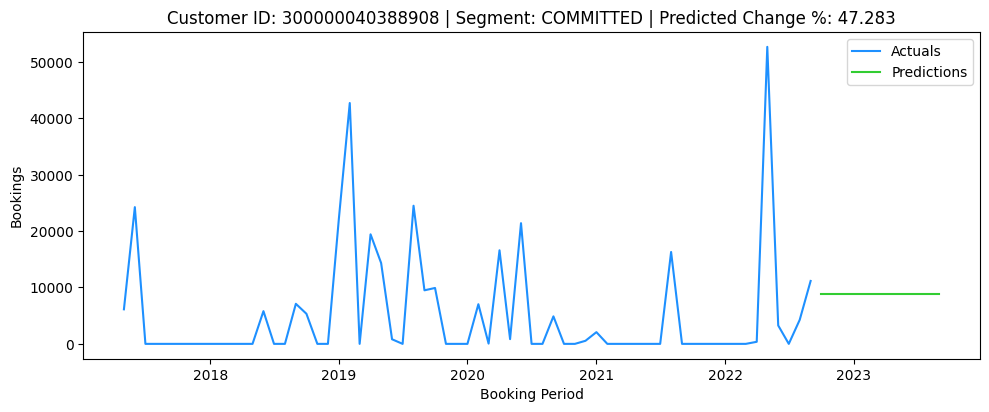

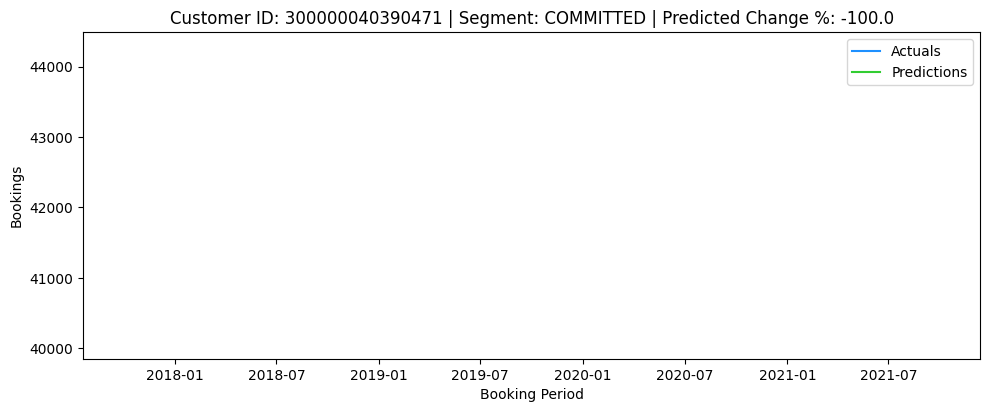

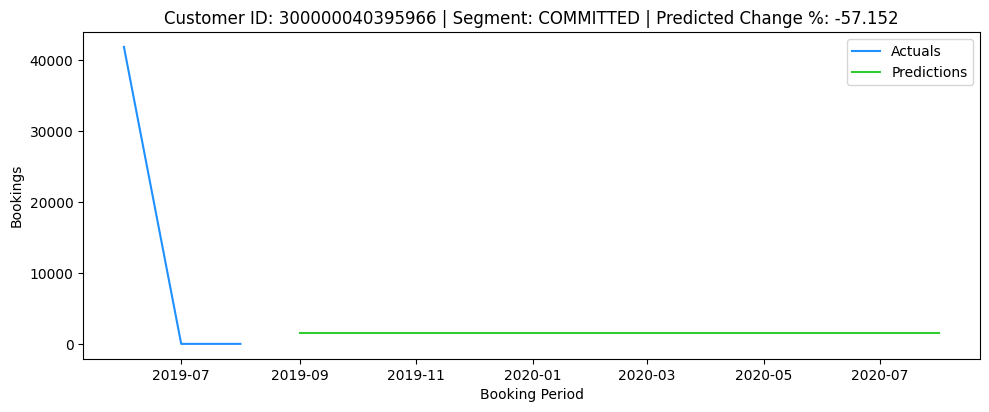

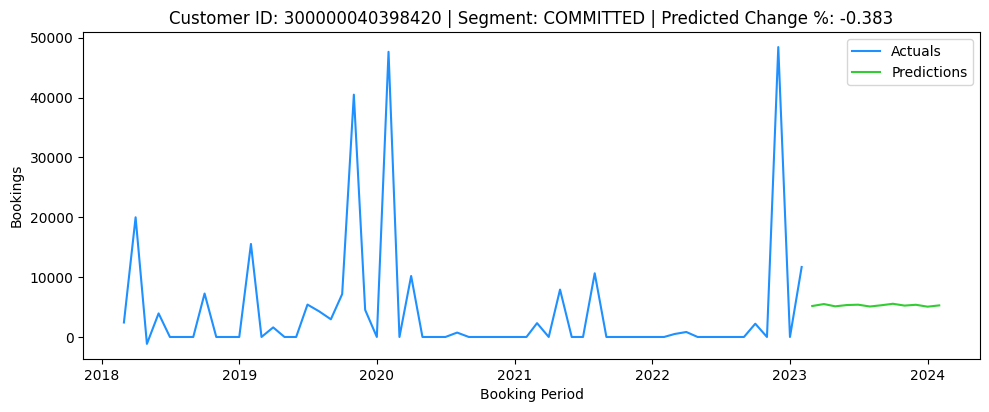

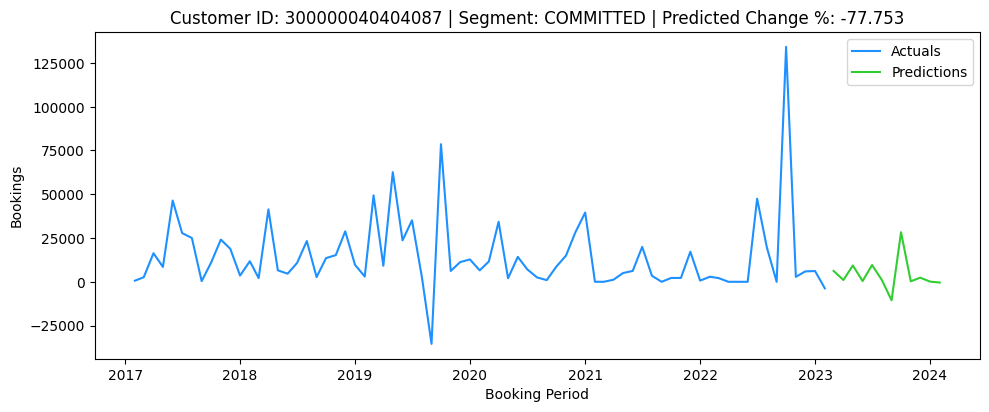

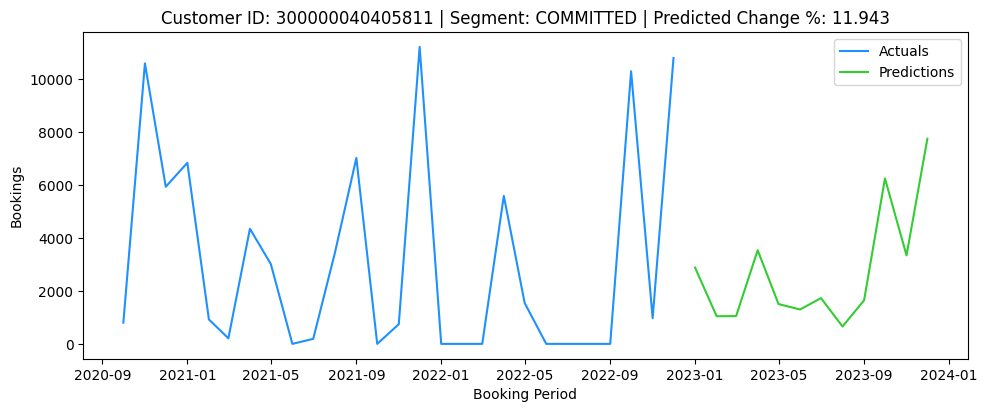

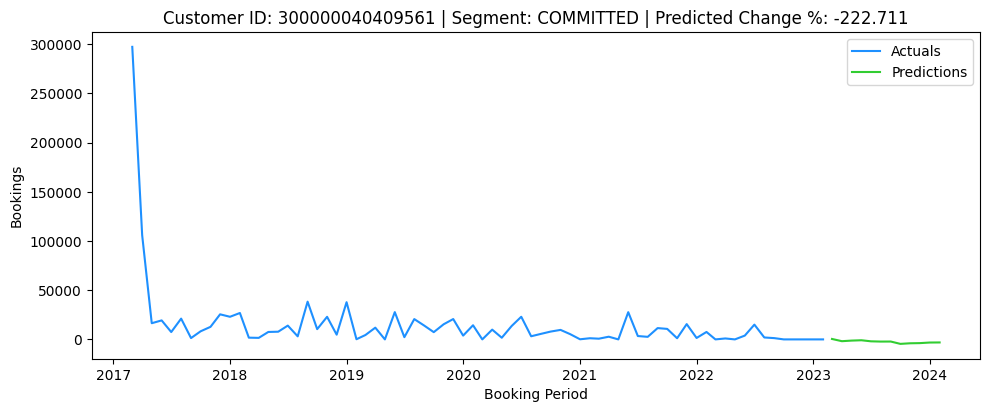

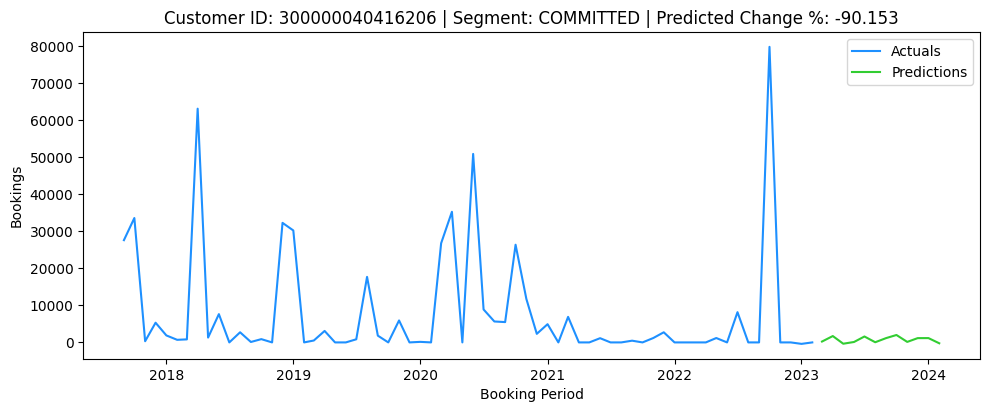

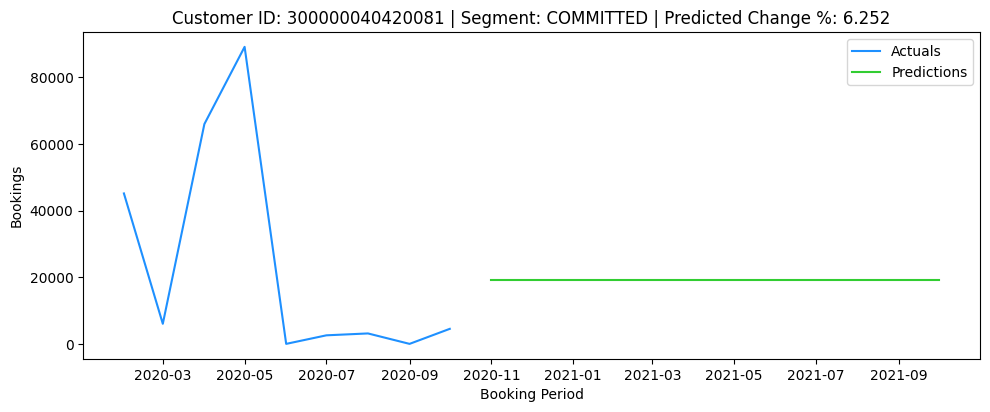

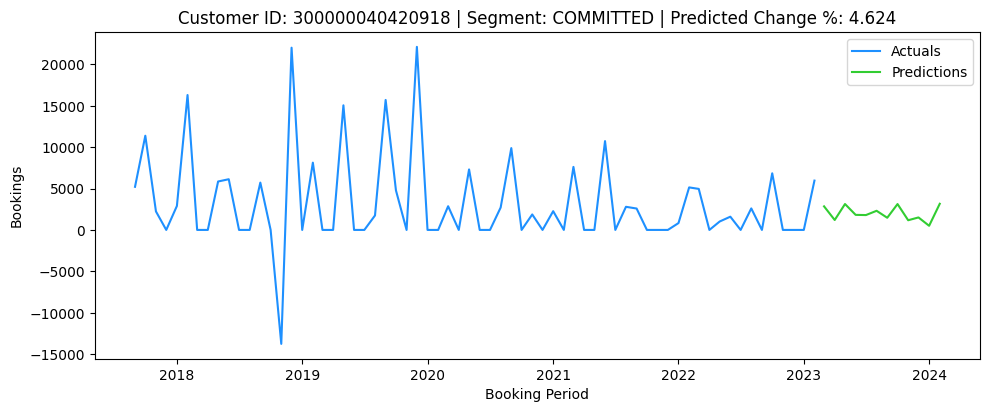

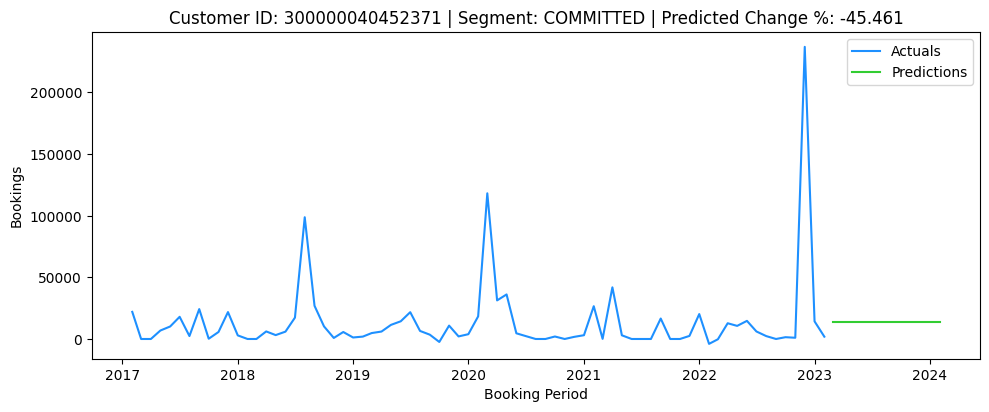

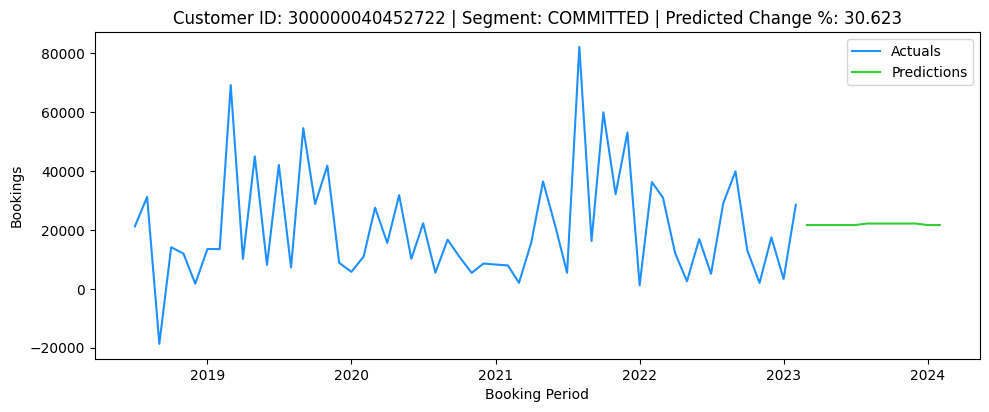

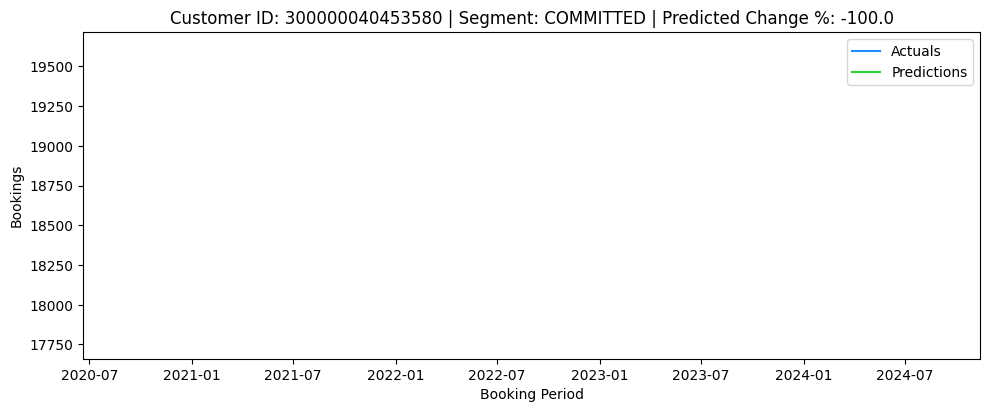

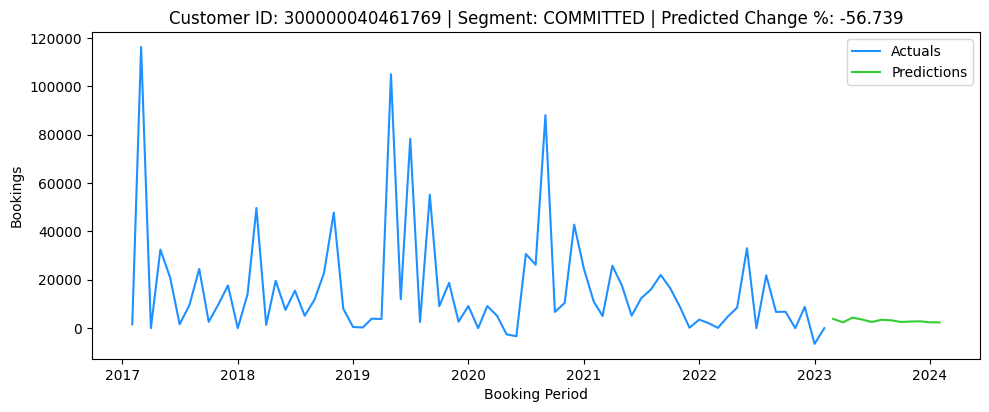

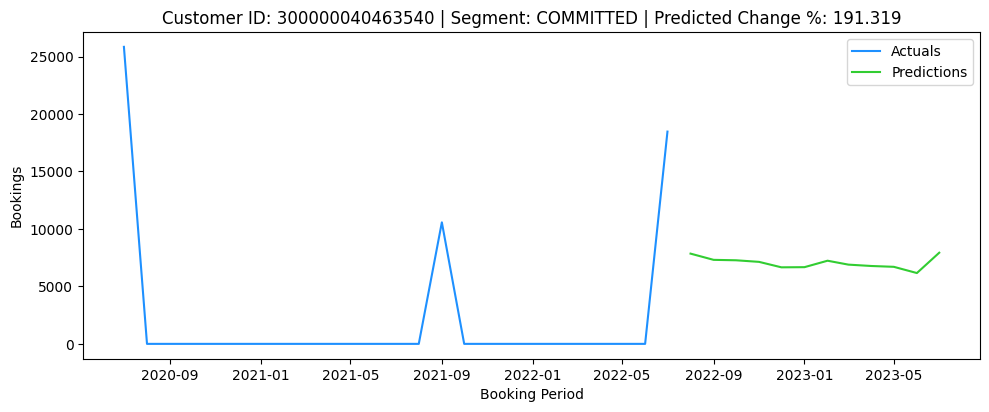

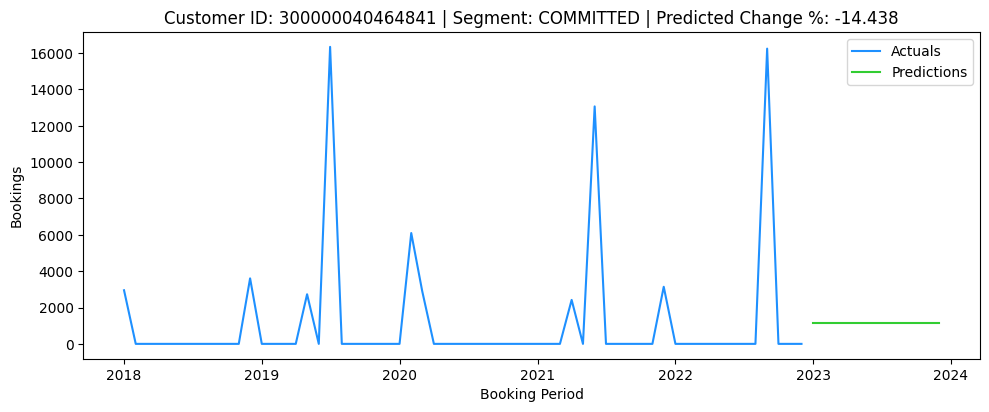

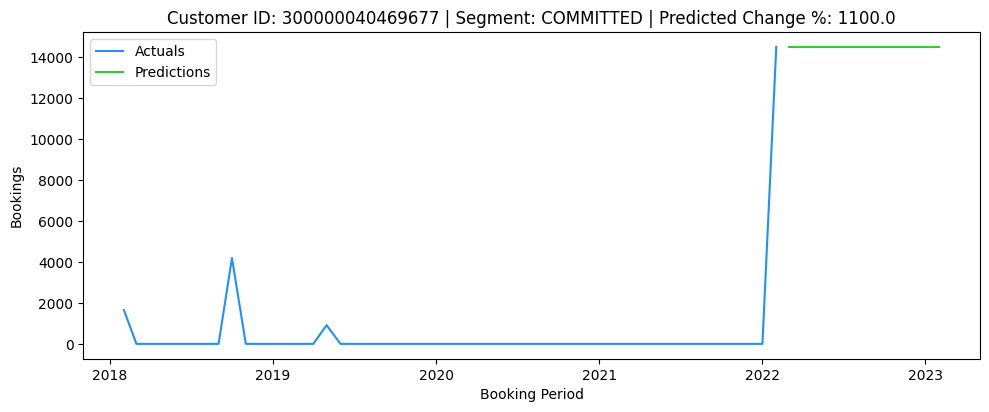

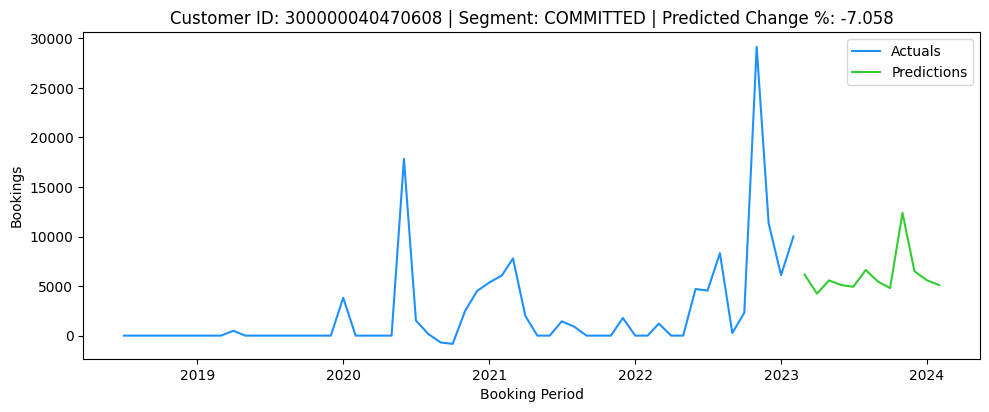

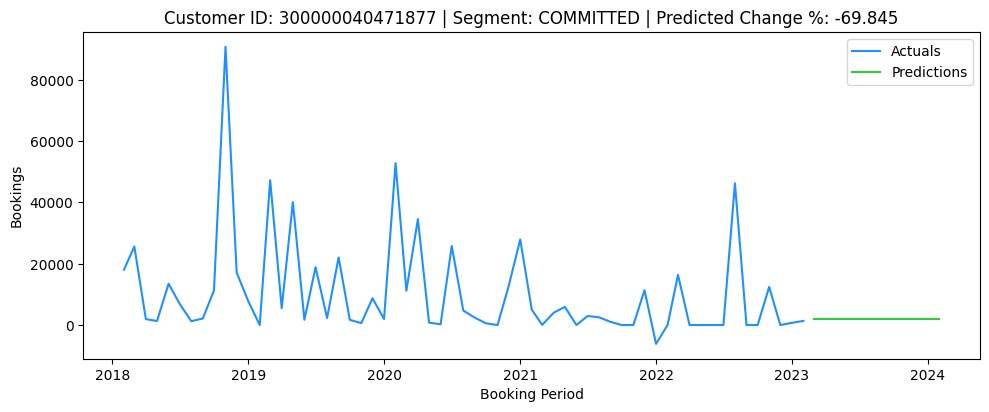

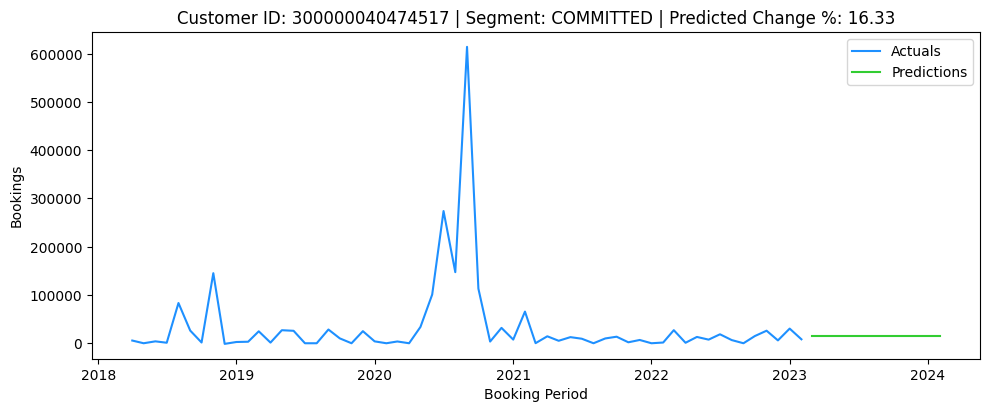

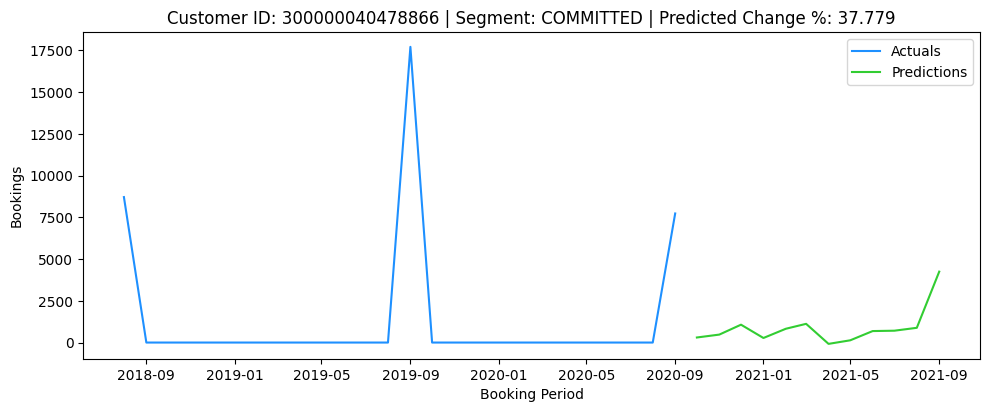

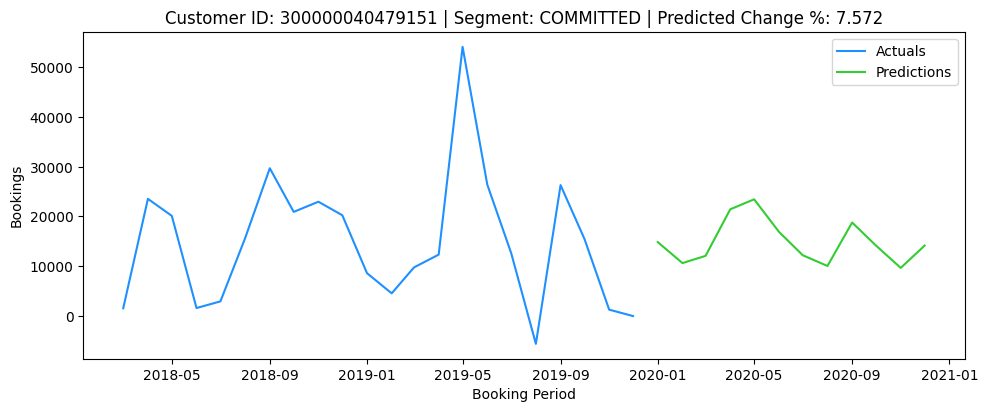

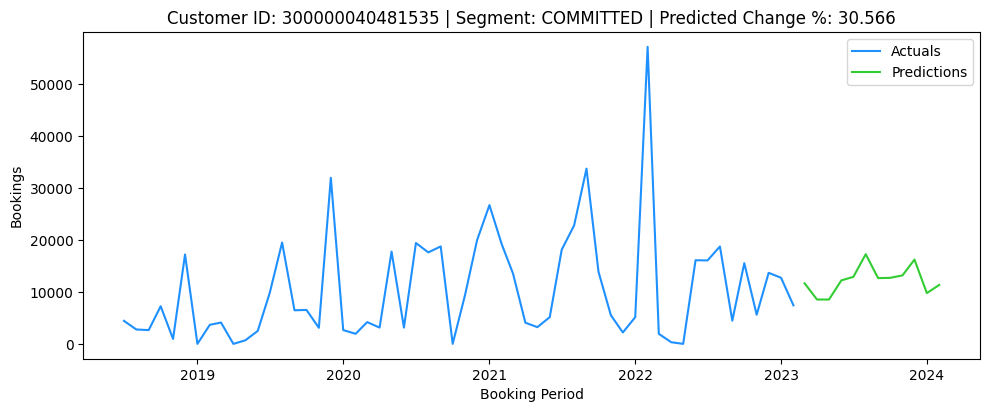

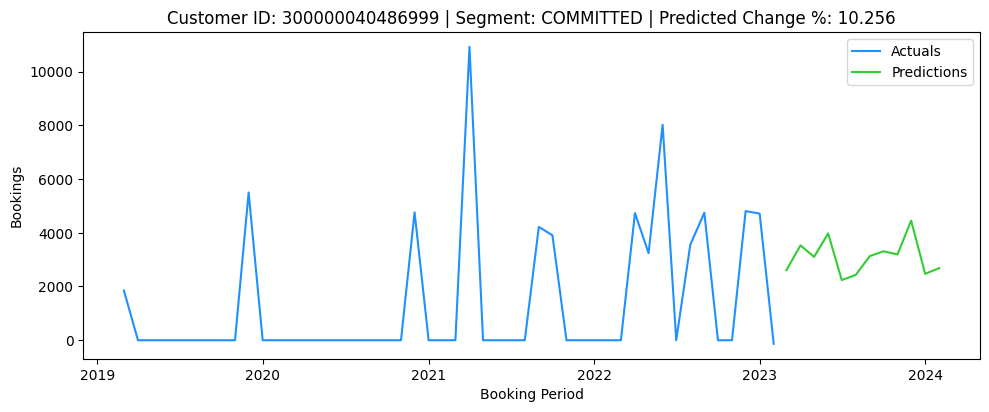

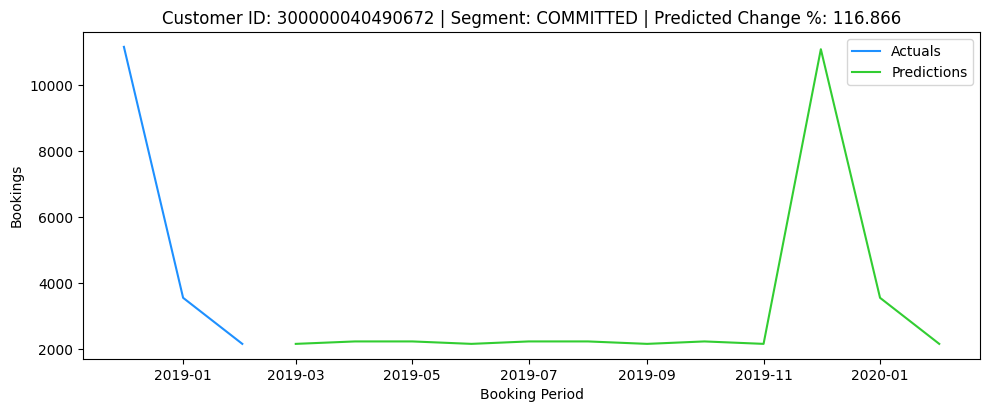

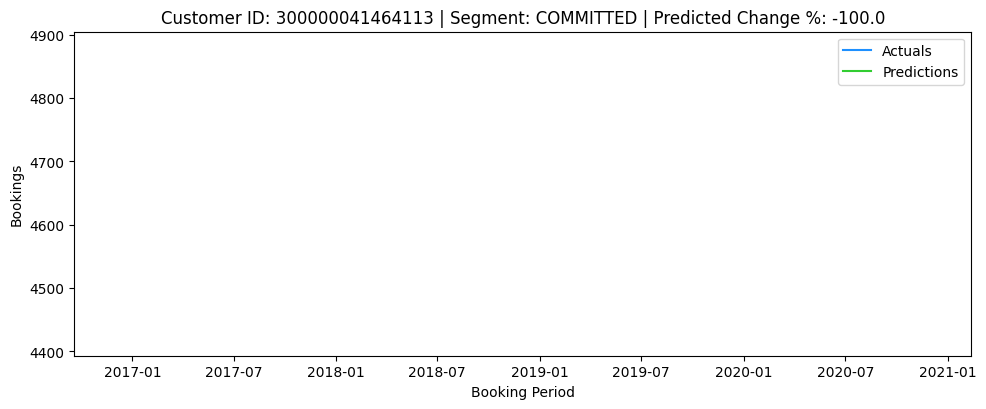

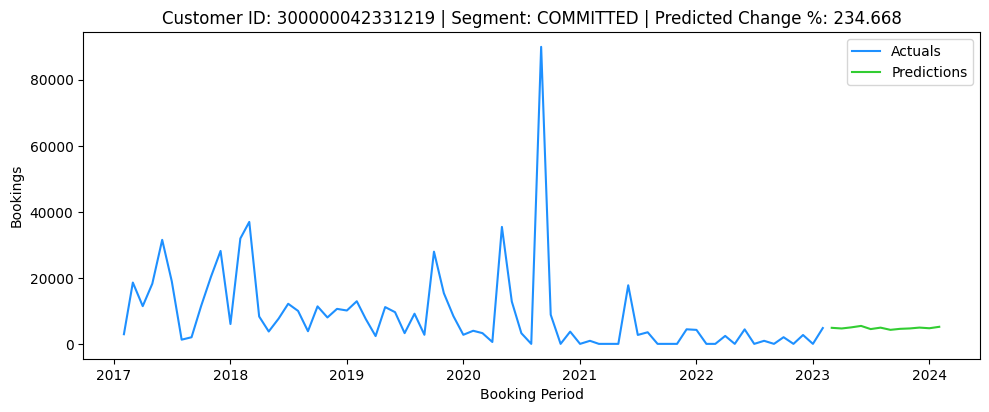

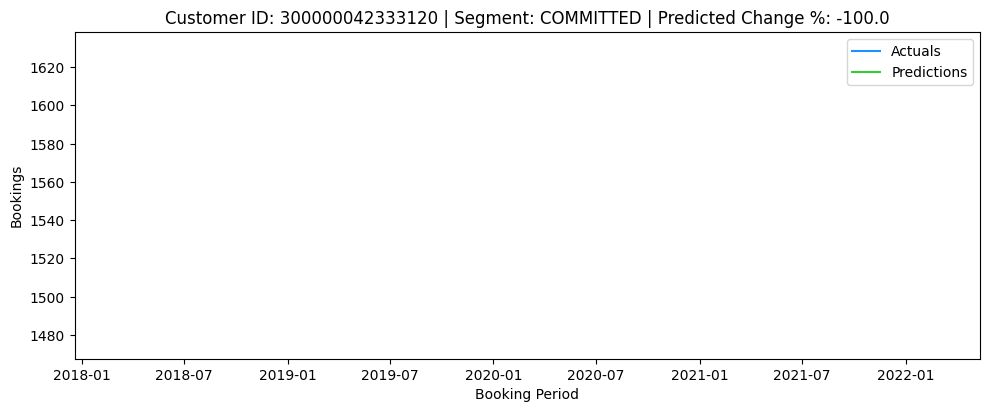

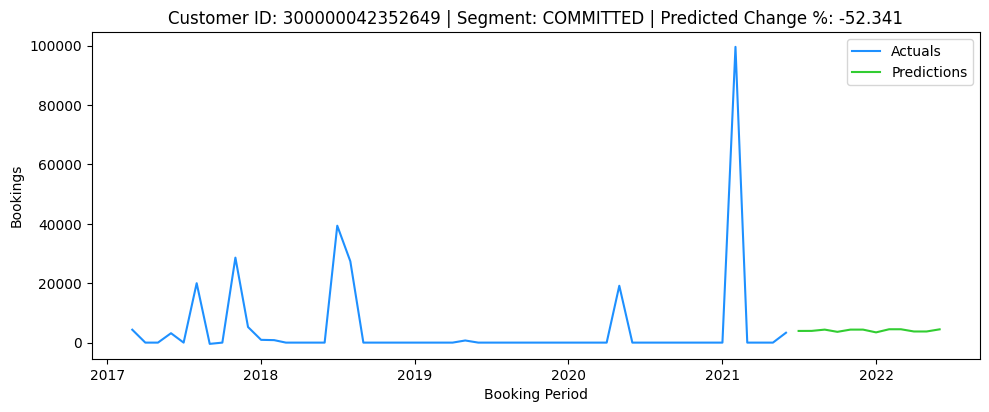

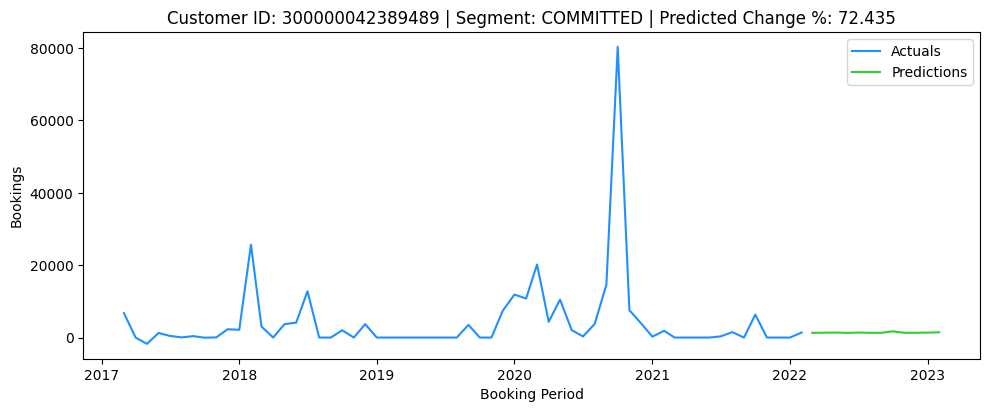

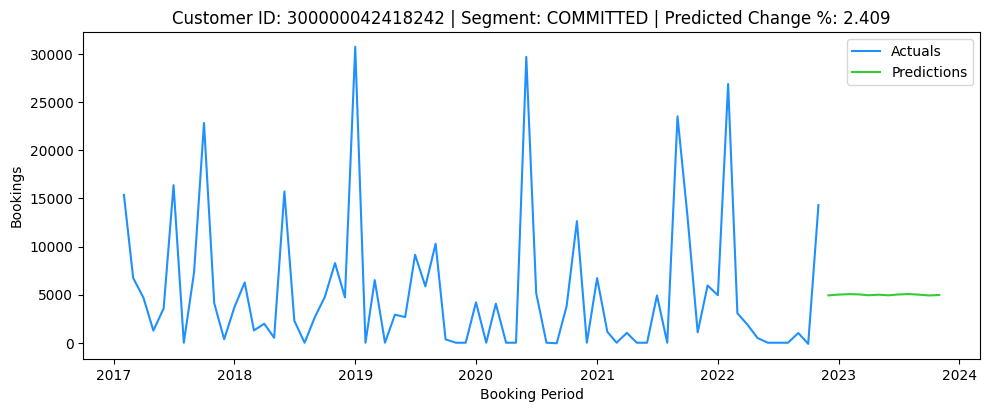

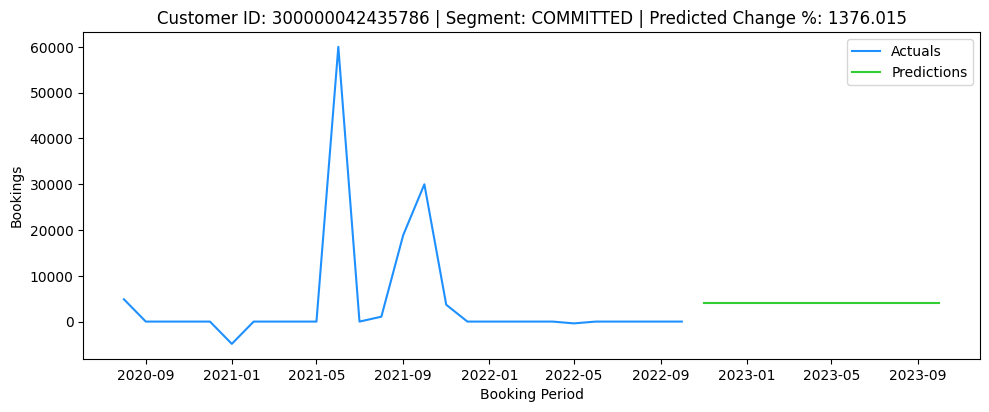

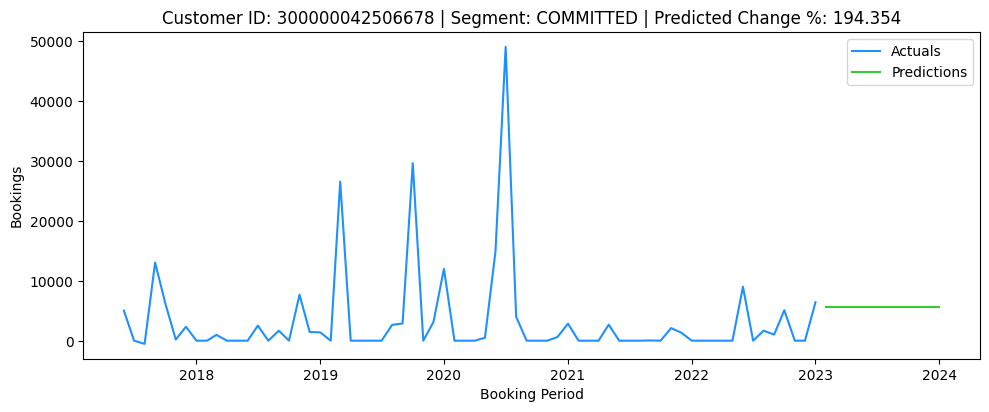

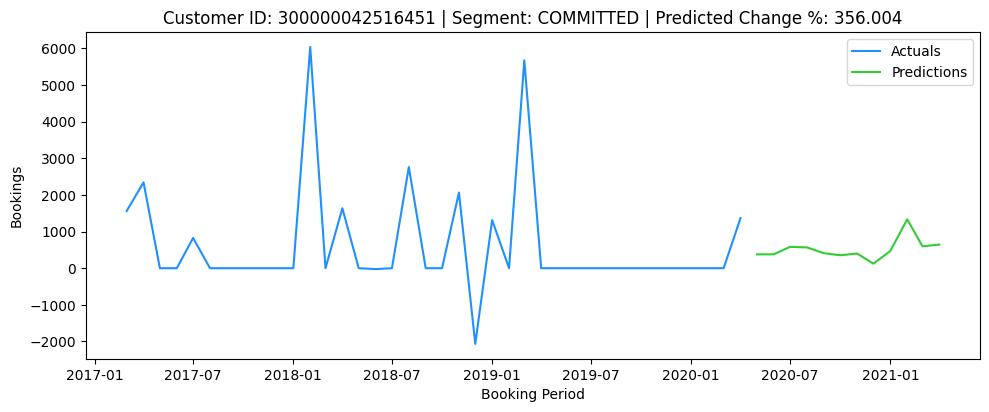

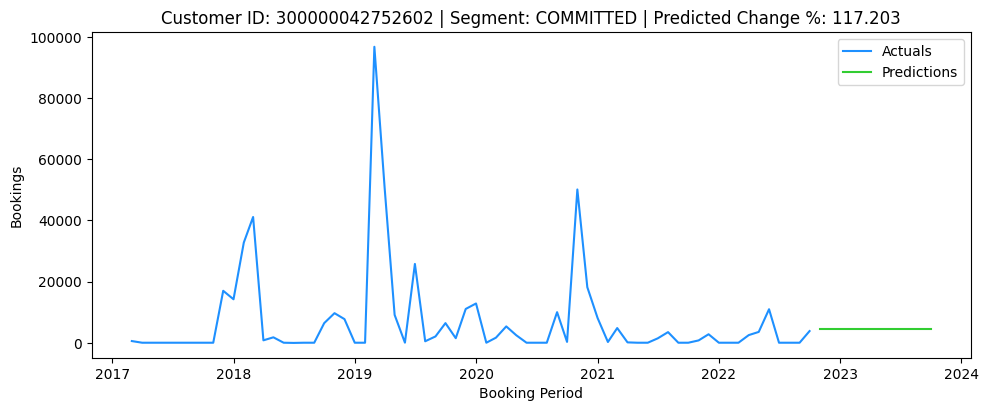

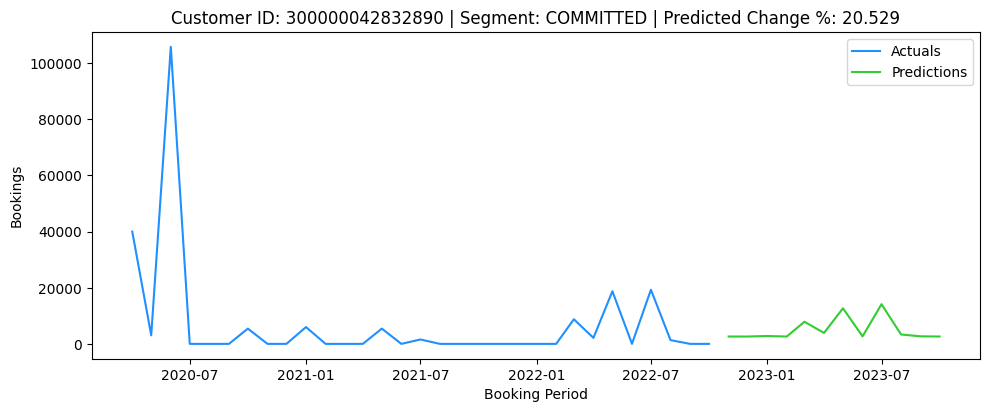

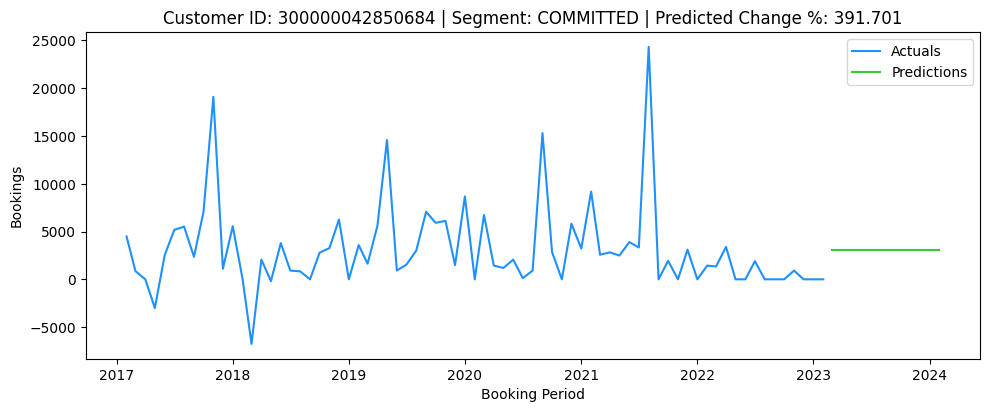

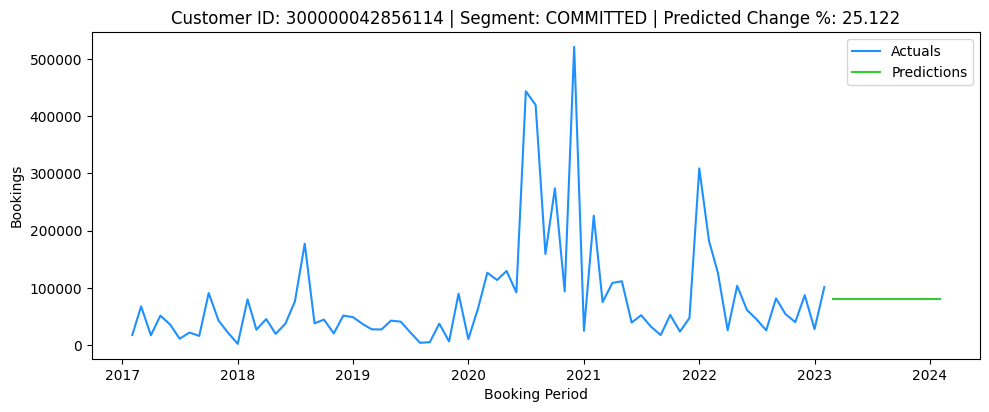

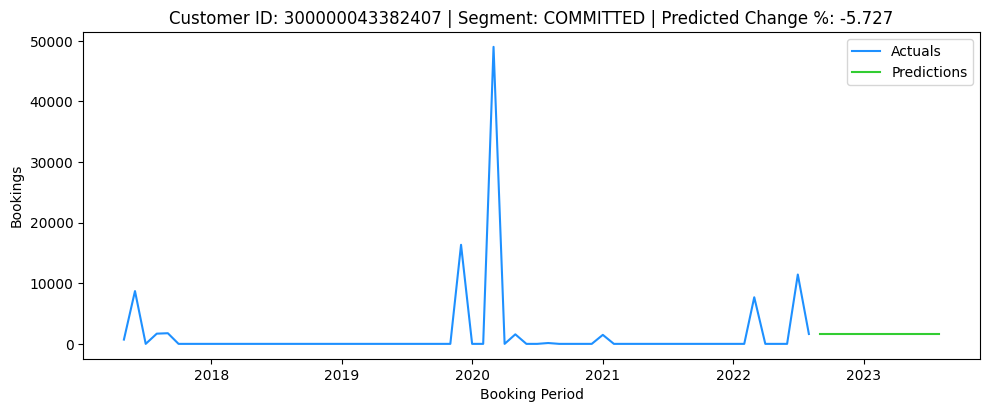

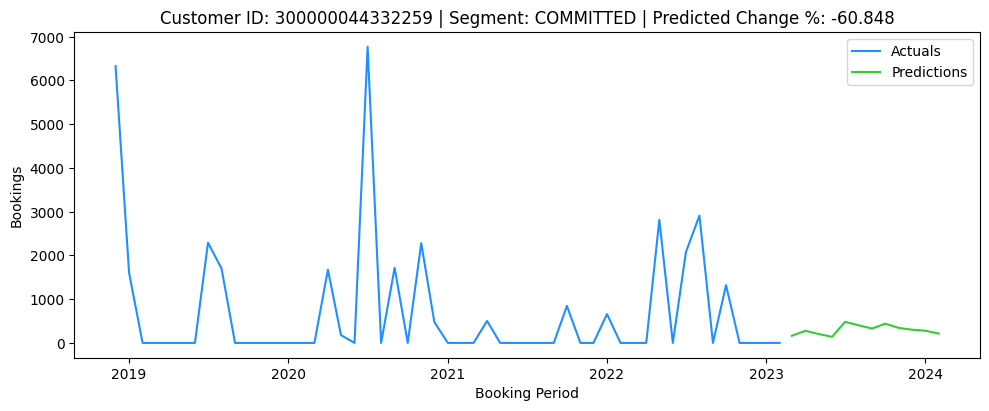

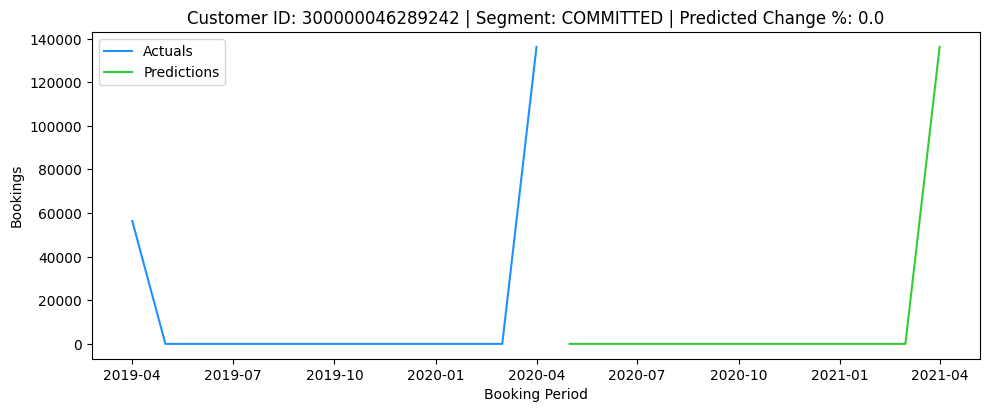

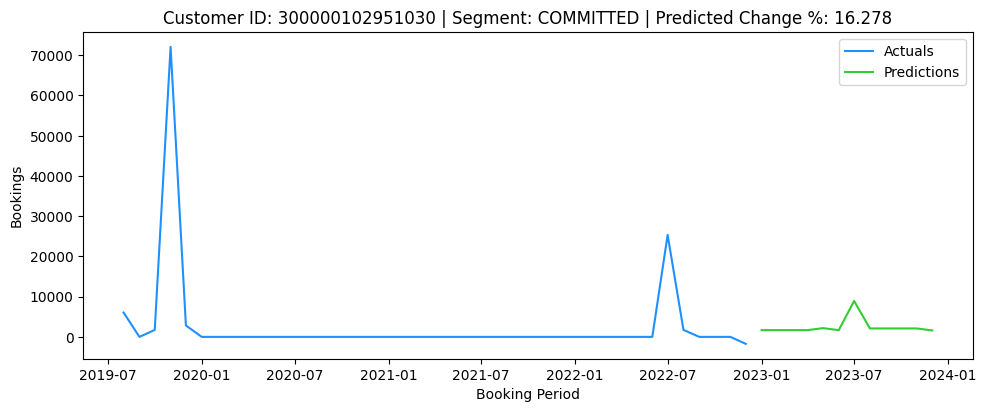

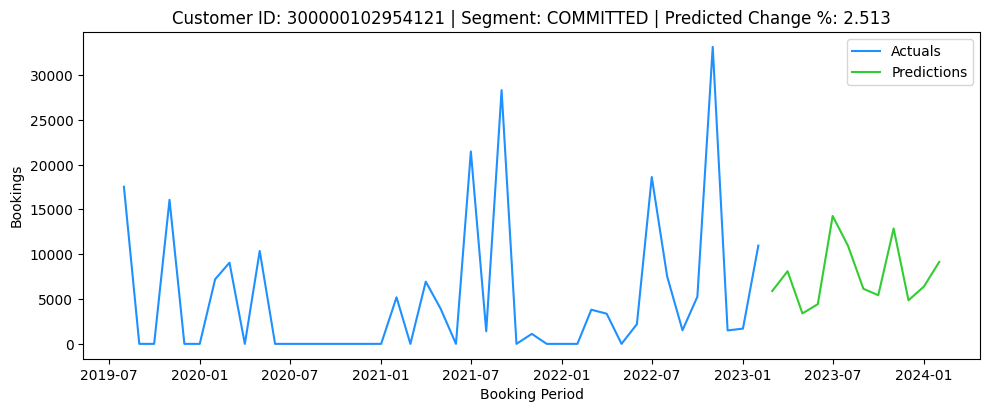

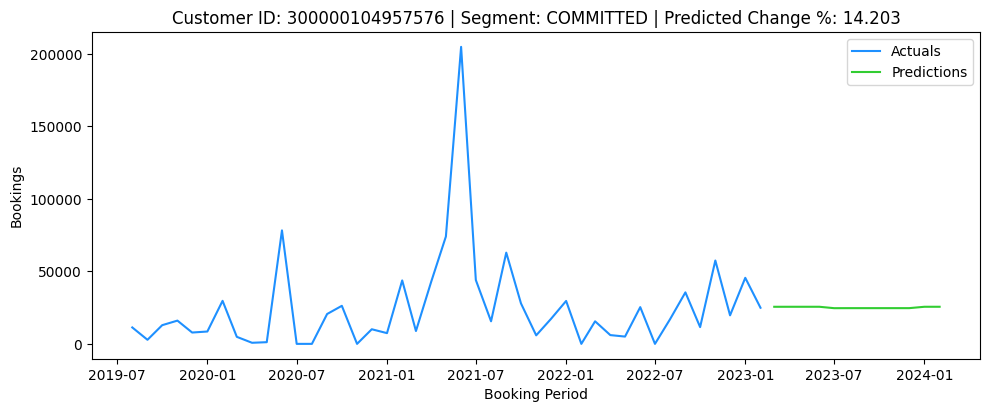

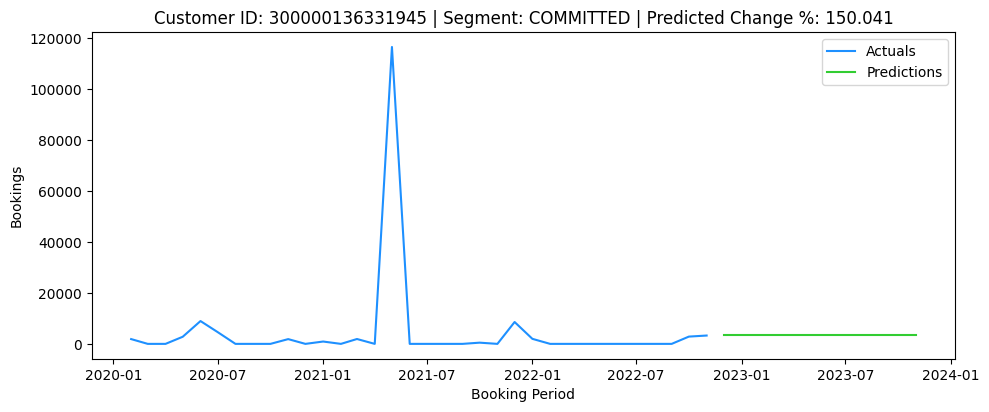

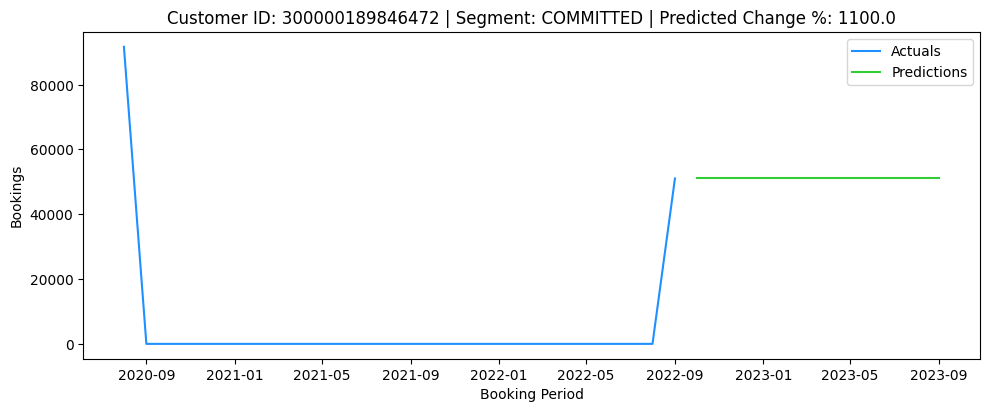

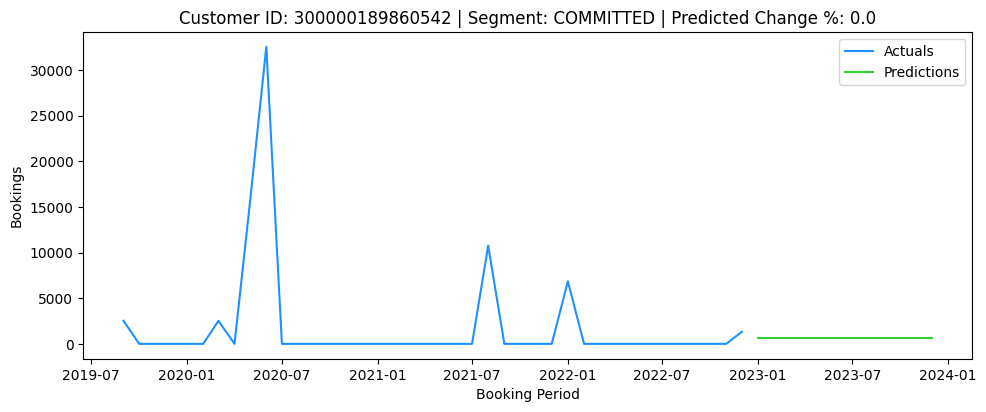

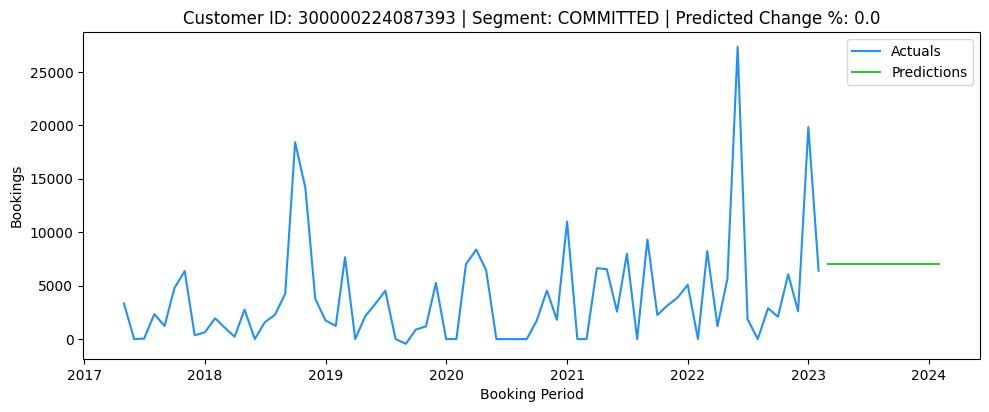

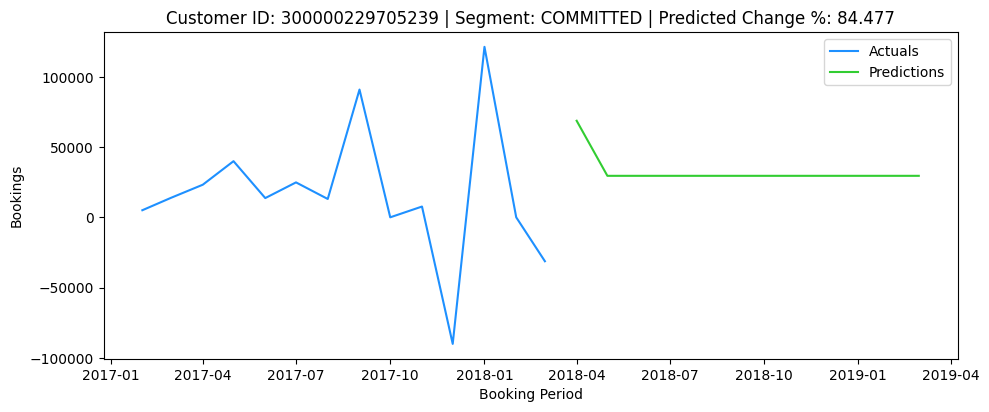

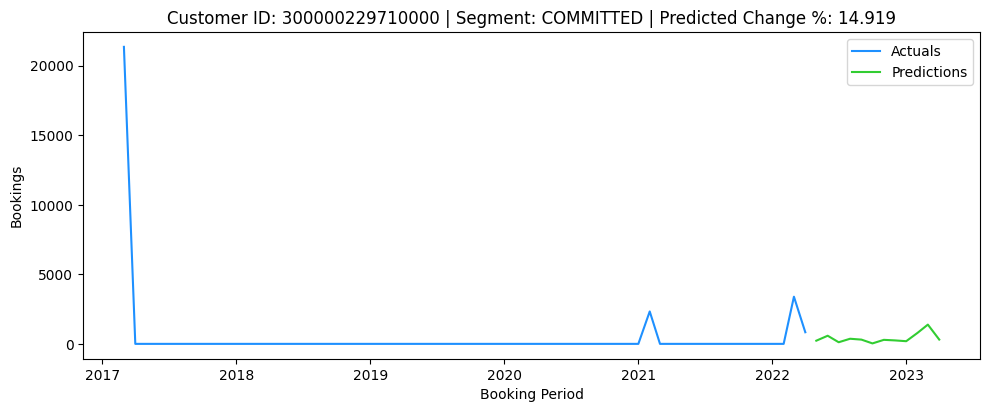

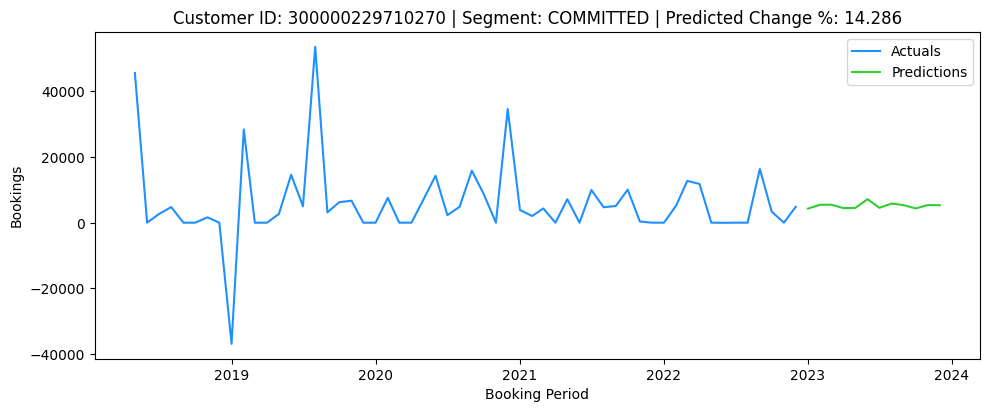

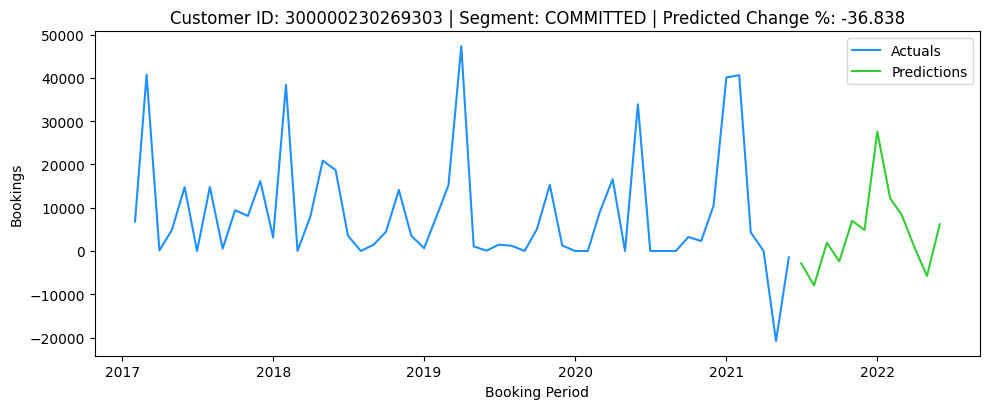

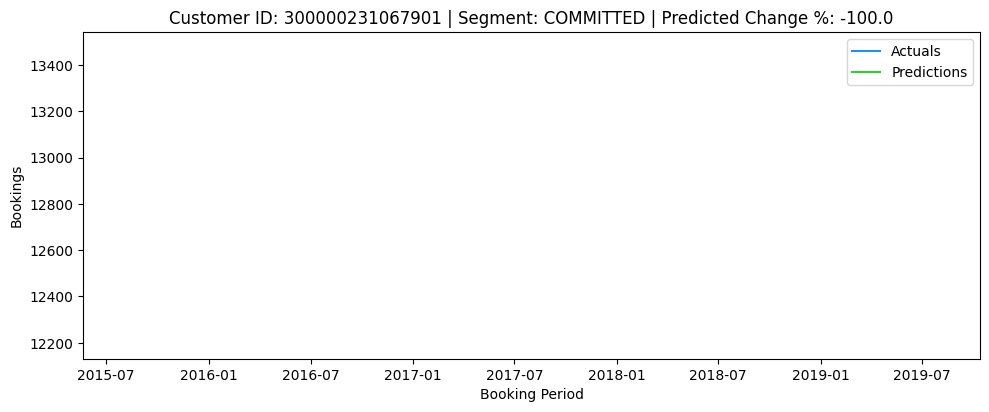

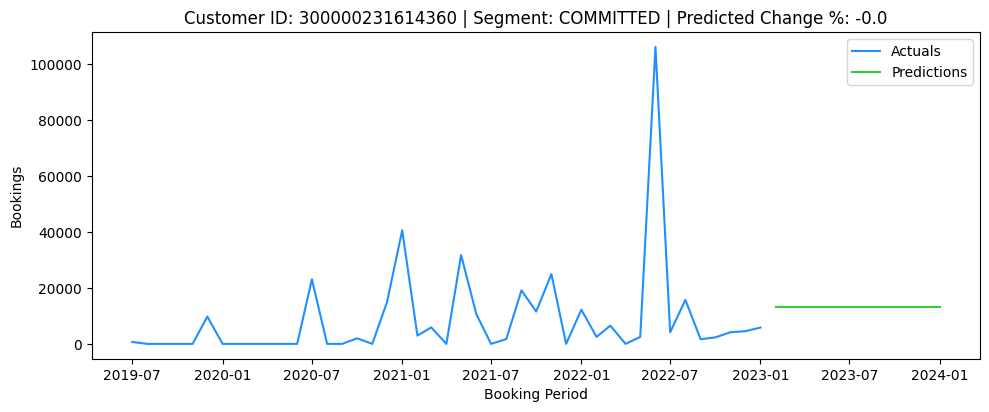

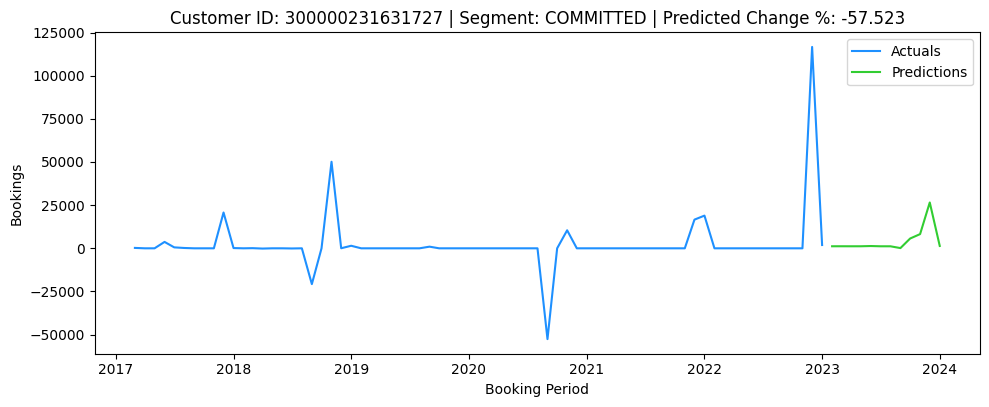

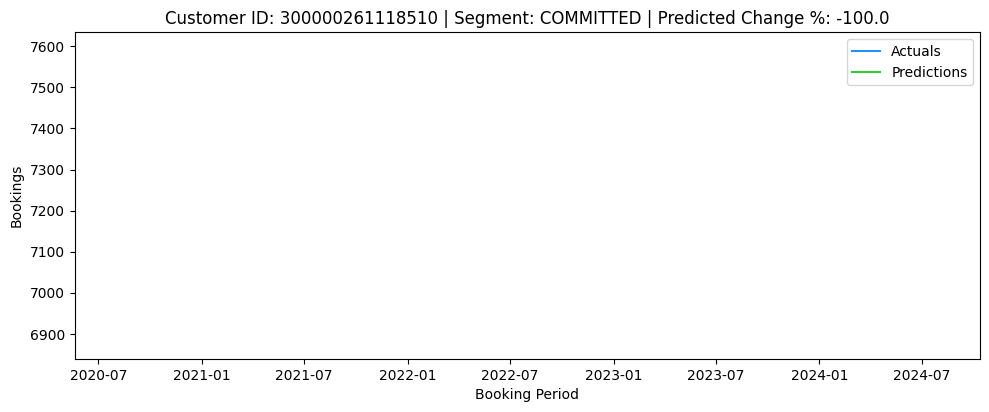

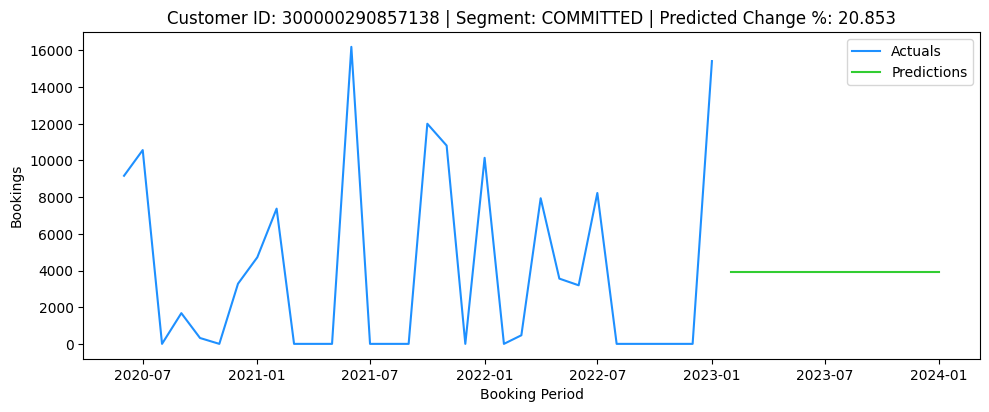

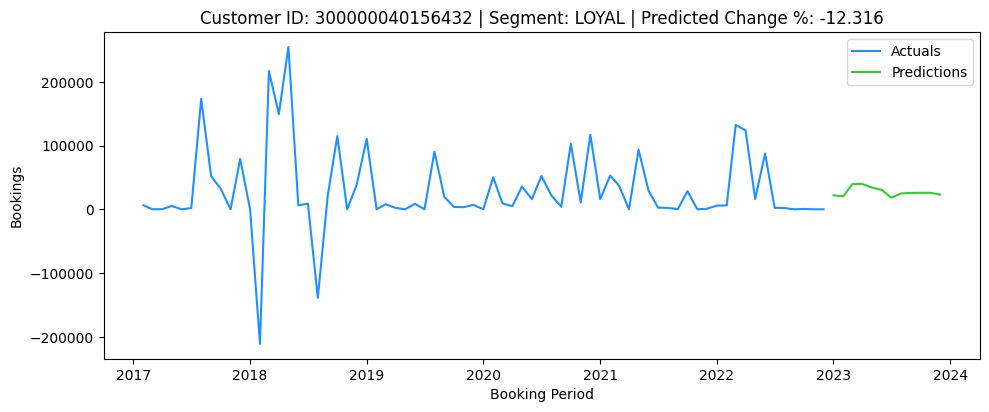

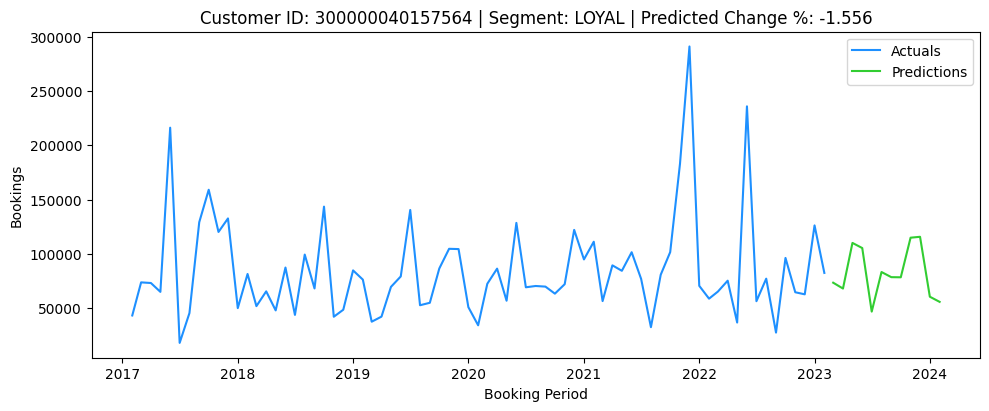

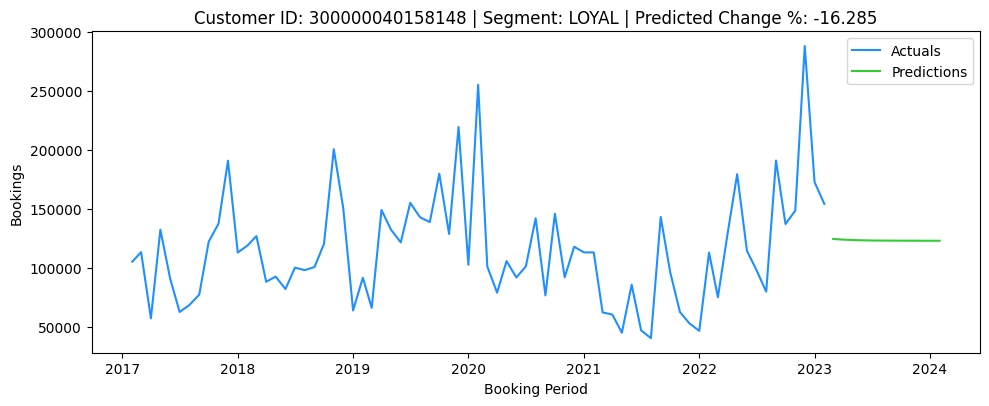

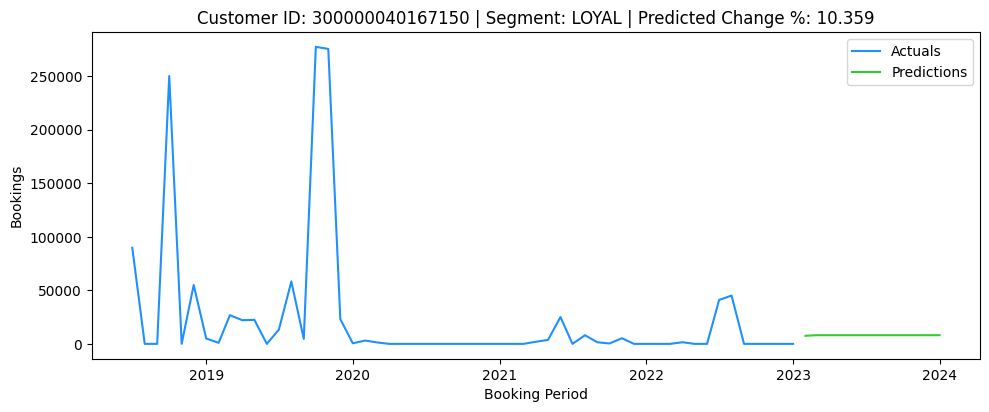

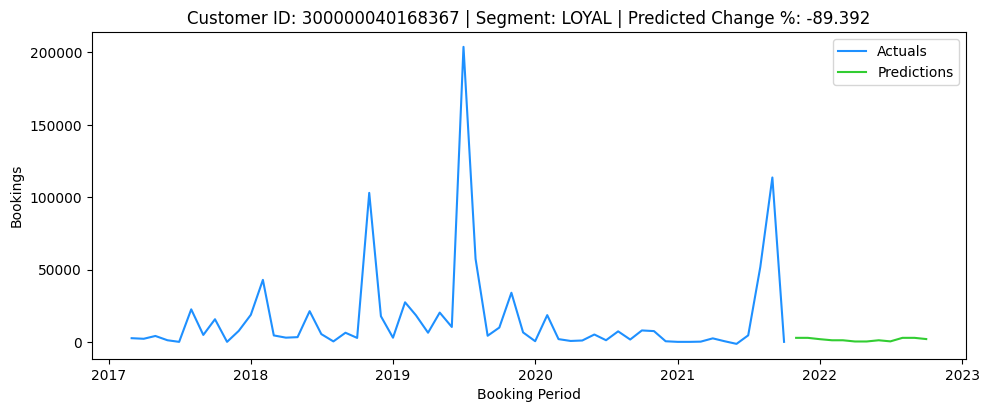

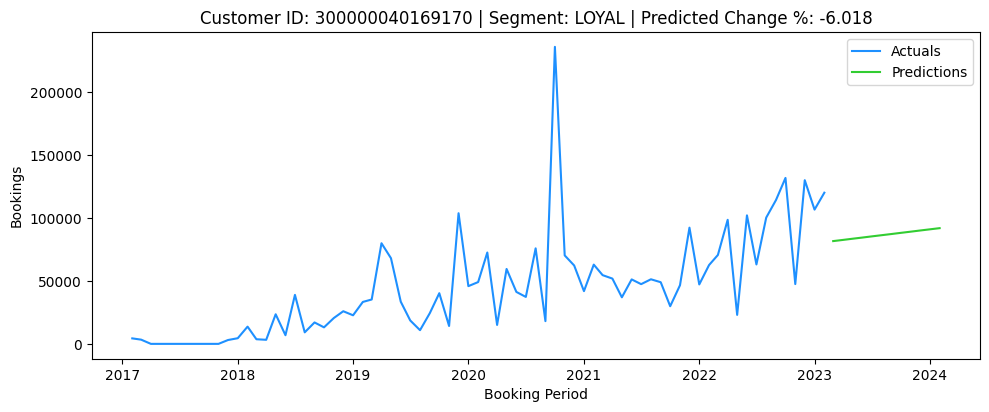

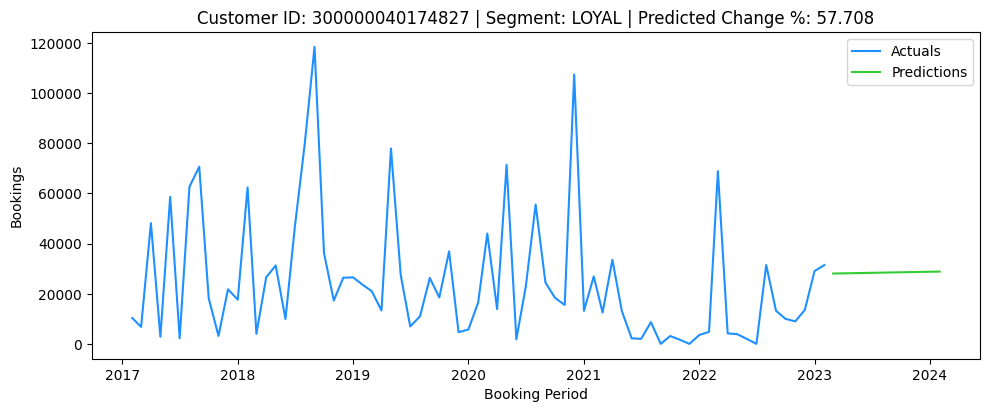

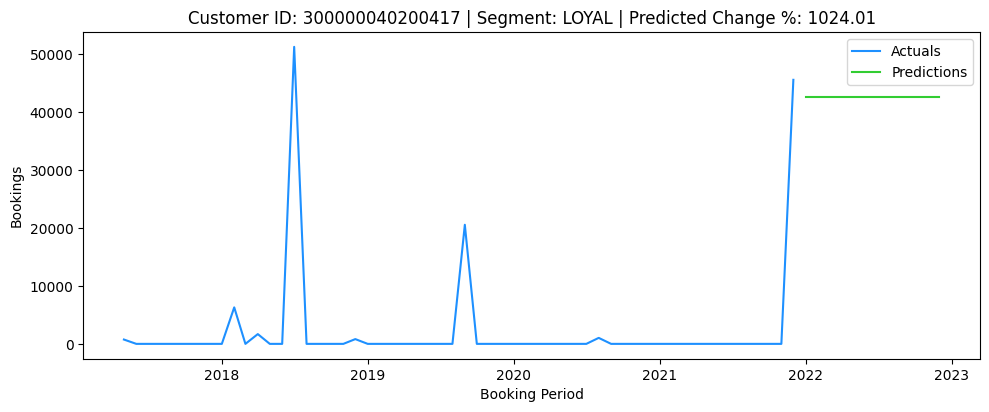

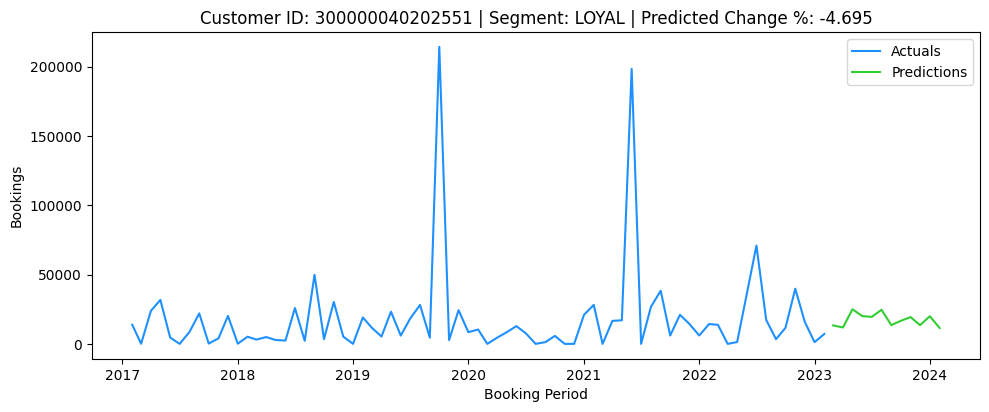

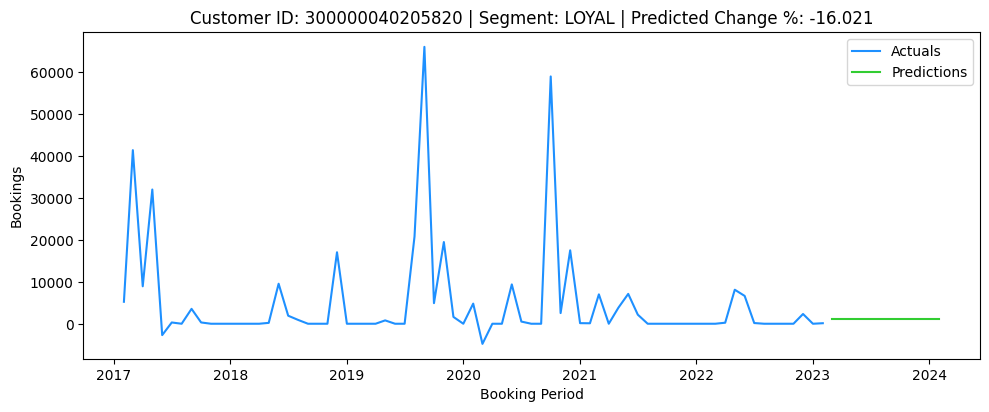

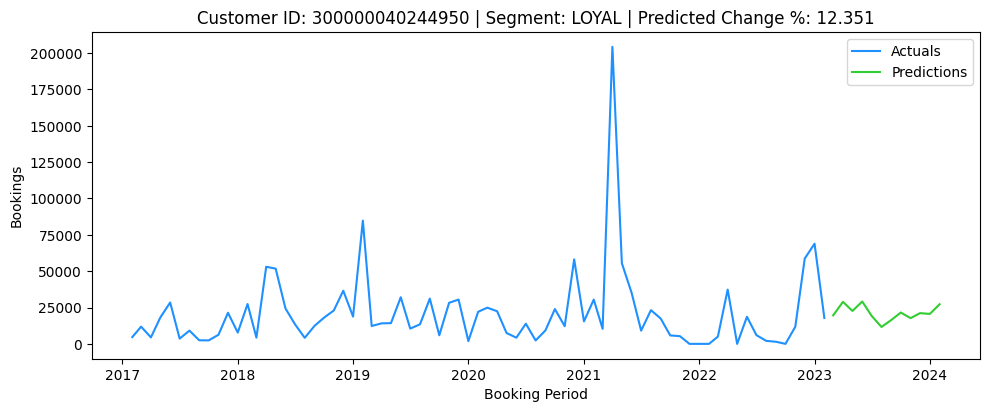

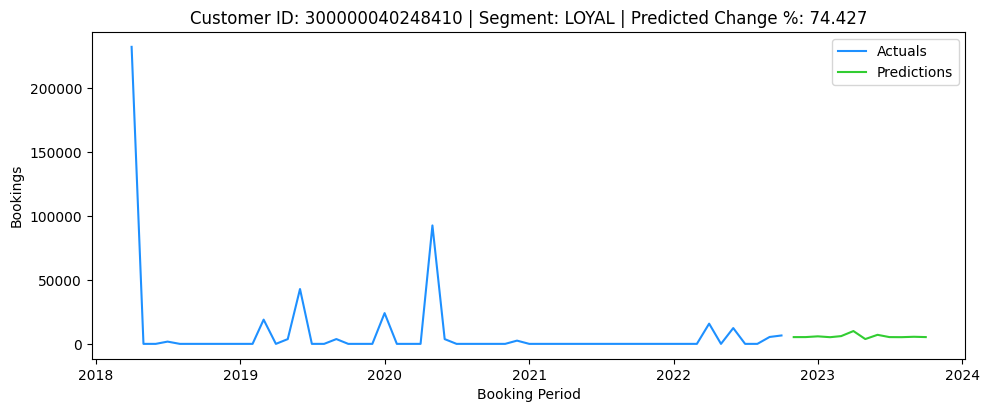

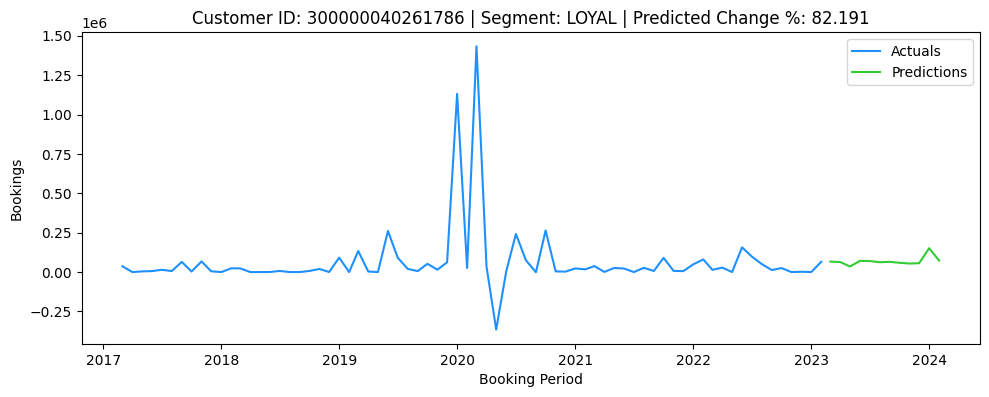

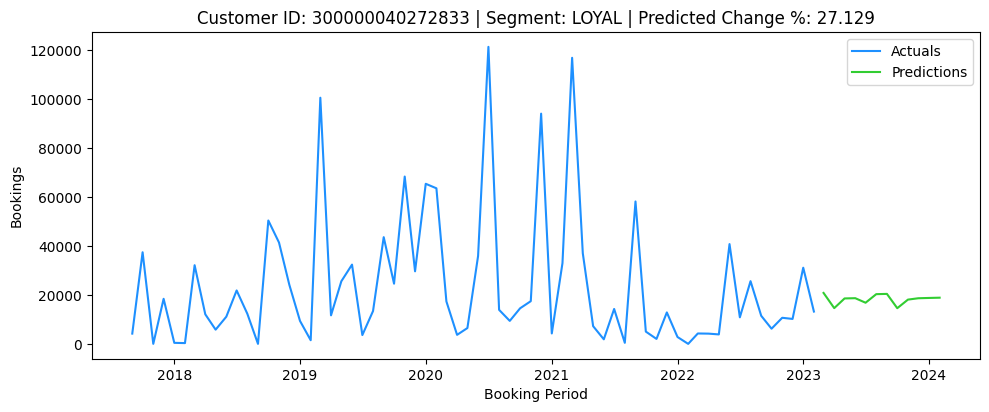

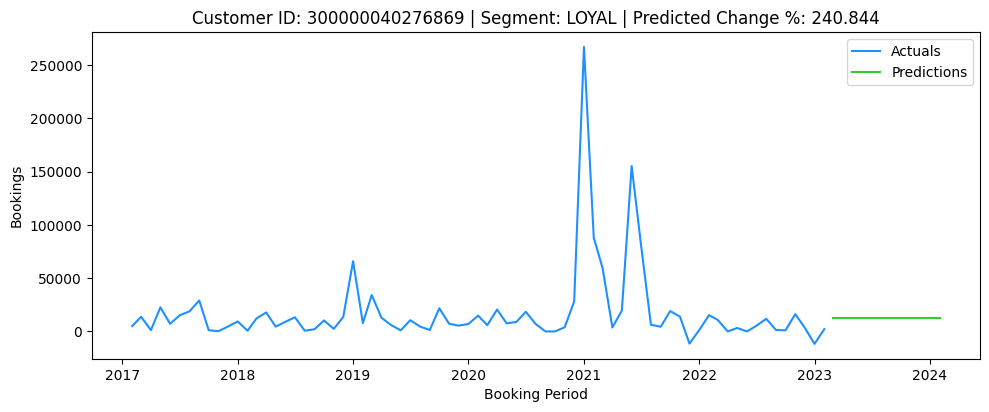

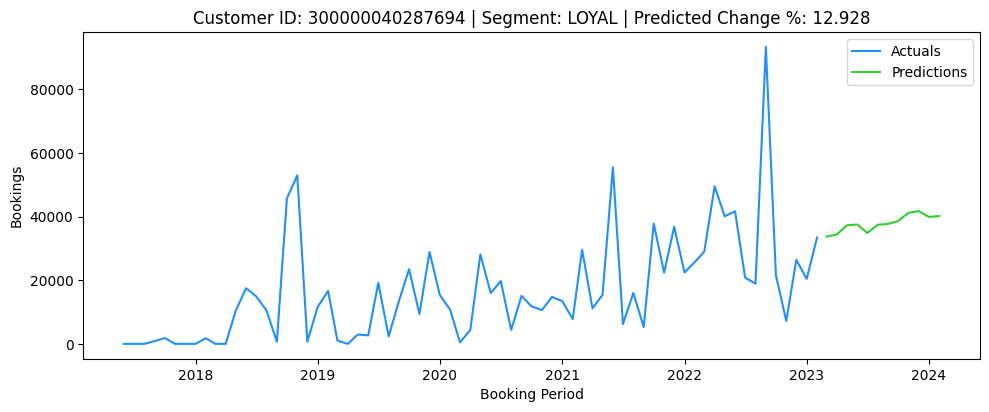

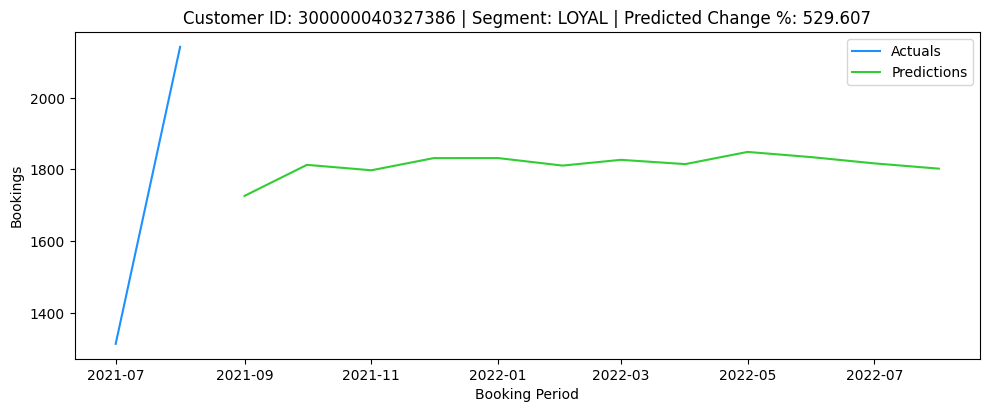

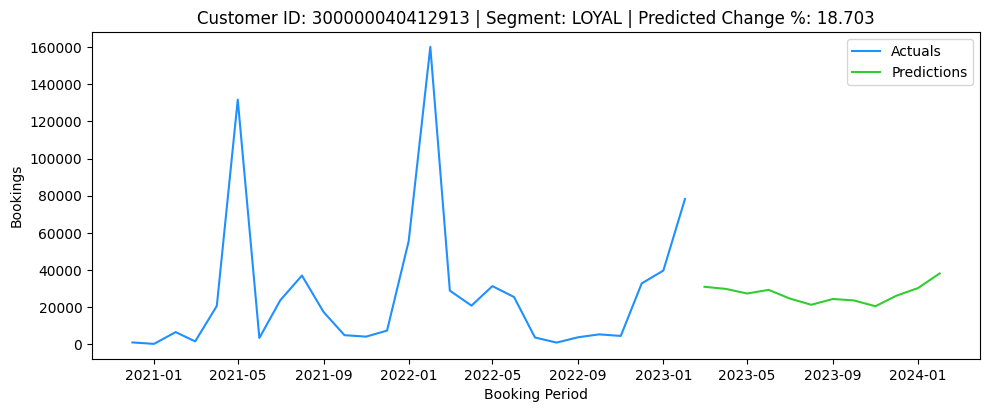

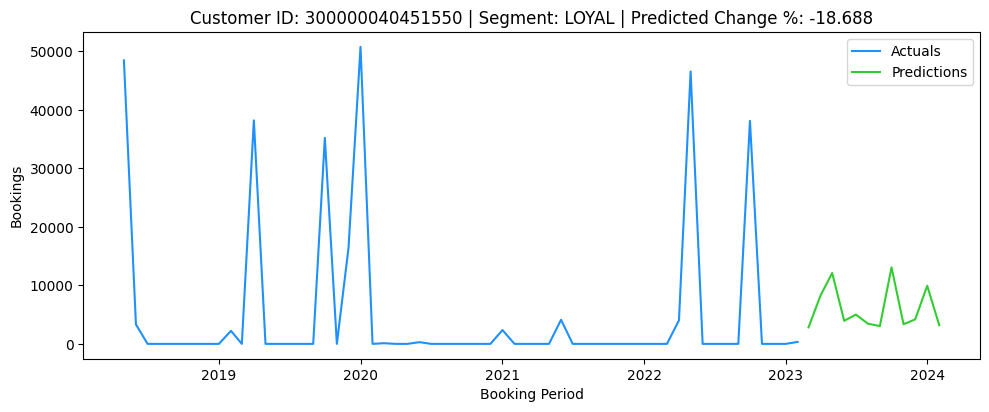

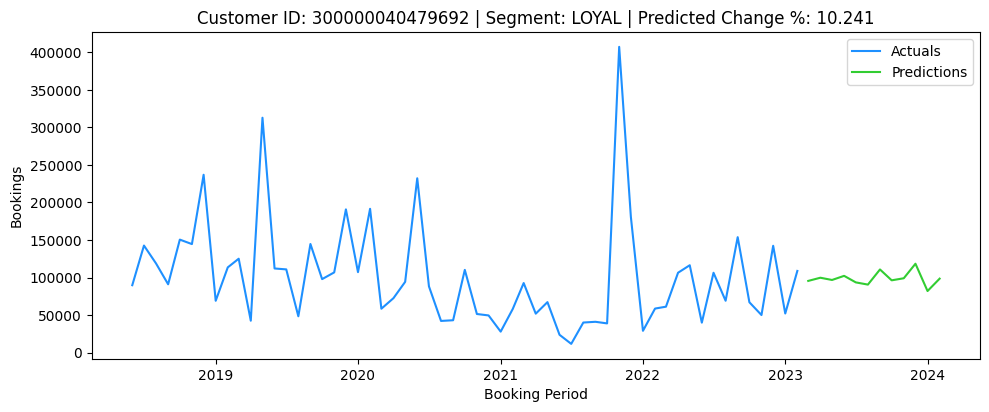

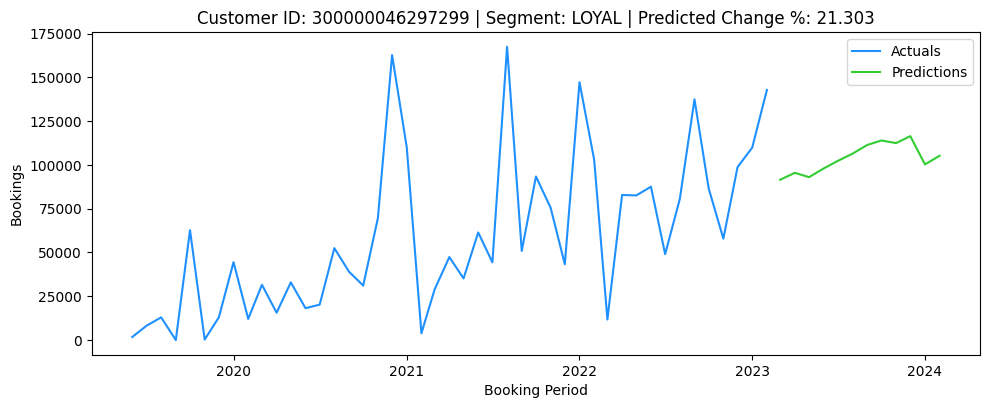

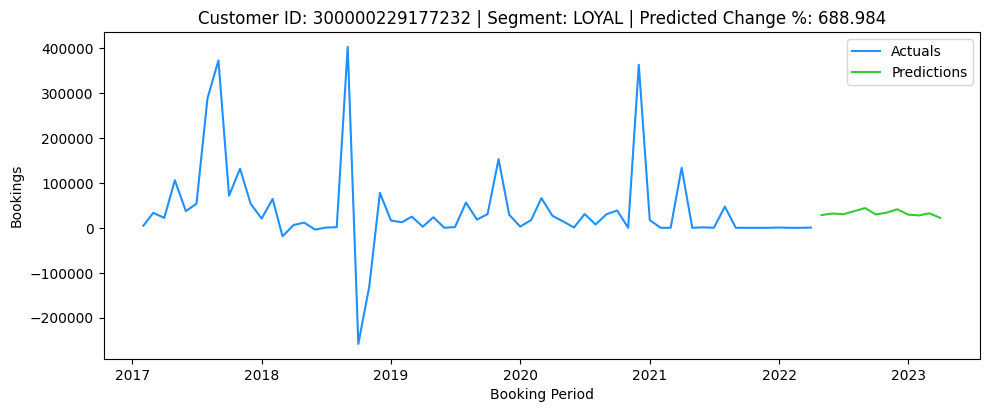

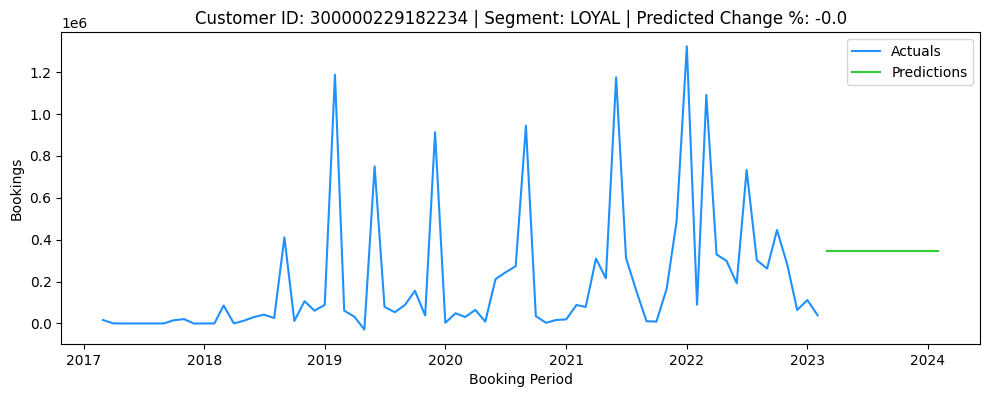

-0.0

In [16]:
percent_delta_data = []

def generate_plot(acts, preds, title):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.plot(acts['Booking Period'], acts['Bookings'], c='dodgerblue', label='Actuals')
    plt.plot(preds['Booking Period'], preds['Bookings'], c='limegreen', label='Predictions')
    plt.xlabel('Booking Period')
    plt.ylabel('Bookings')
    plt.legend(['Actuals', 'Predictions'])
    plt.tight_layout()
    plt.title(title)
    plt.show()

for _, grp in final_df.groupby(['Segment', 'Customer ID']):
    grp = grp.sort_values(by='Booking Period')
    segment = grp.iloc[0]['Segment']
    cust_id = grp.iloc[0]['Customer ID']
    preds = grp[grp['Predicted']==True]
    acts = grp[grp['Predicted']==False].tail(12)
    year_one_cumulative = sum(acts['Bookings'])
    year_two_cumulative = sum(preds['Bookings'])
    if year_one_cumulative > 0:
        delta_percent = ((year_two_cumulative - year_one_cumulative) / year_one_cumulative) * 100
        delta_percent = round(delta_percent, 3)
        percent_delta_data.append({
            'Segment': segment,
            'Customer ID': cust_id,
            'Predicted Change % (Forecast vs. Last 12 Months)': delta_percent
        })
        # if delta_percent < 0:
        acts = grp[grp['Predicted']==False]
        title = f'Customer ID: {cust_id} | Segment: {segment} | Predicted Change %: {str(delta_percent)}'
        generate_plot(acts, preds, title)
            # break
# grp
delta_percent

In [17]:
cust_ids = []
for _, row in final_df.iterrows():
    cust_ids.append('_' + str(row['Customer ID']))

final_df['Customer ID'] = cust_ids
final_df.to_csv('EMERSON_many_models_run_results.csv', index=False)

In [18]:
percent_delta_df = pd.DataFrame(percent_delta_data)

cust_ids = []
for _, row in percent_delta_df.iterrows():
    cust_ids.append('_' + str(row['Customer ID']))
percent_delta_df['Customer ID'] = cust_ids
percent_delta_df.to_csv('EMERSON_many_models_change_calculations.csv', index=False)